# Training

This code is trained by adding various attention blocks to the ResNet18 and VGG19. <br>
The specific settings are as follows.

||VGG19|ResNet18|
|:---:|:---|:---|
|__Dataset__|CIFAR-10|CIFAR-100|
|__Block position__|1st layer|1st-2nd layer|
|__Block type__|SE (residual) + SA<br>SE + SA<br>CBAM<br>Our model|SE (residual) + SA<br>CBAM<br>Our model|

 
This code converts the existing 'main.py' file in 'resnet_cifar' and 'vgg_cifar' folders into a jupyter notebook file.

## 1. Training of VGG19 with CIFAR-10

### 1.1 Set arguments and load CIFAR-10

In [24]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from vgg_cifar import vgg

import numpy as np
import random
#import wandb
#################### Random Seed 고정 ####################
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
##########################################################

model_names = sorted(name for name in vgg.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("vgg")
                     and callable(vgg.__dict__[name]))


parser = argparse.ArgumentParser(description='PyTorch VGG Trainer')
parser.add_argument('-a', '--arch', metavar='ARCH', default='vgg19_bn',
                    choices=model_names,
                    help='model architecture: ' + ' | '.join(model_names) +
                    ' (default: vgg19)')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=300, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=128, type=int,
                    metavar='N', help='mini-batch size (default: 128)')
parser.add_argument('--lr', '--learning-rate', default=0.05, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=5e-4, type=float,
                    metavar='W', help='weight decay (default: 5e-4)')
parser.add_argument('--print-freq', '-p', default=100, type=int,
                    metavar='N', help='print frequency (default: 20)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')
parser.add_argument('--pretrained', dest='pretrained', action='store_true',
                    help='use pre-trained model')
parser.add_argument('--half', dest='half', action='store_true',
                    help='use half-precision(16-bit) ')
parser.add_argument('--cpu', dest='cpu', action='store_true',
                    help='use cpu')
parser.add_argument('--save-dir', dest='save_dir',
                    help='The directory used to save the trained models',
                    default='save_temp', type=str)
parser.add_argument('--dataset', help='choose one of dataset : cifar10 or cifar100', default='cifar10', type=str)
parser.add_argument('--block', help='block_type', default='VGG19', type=str)

args = parser.parse_args(args=[])
print(args)
if args.dataset == "cifar10" :
    num_classes = 10
elif args.dataset == "cifar100" :
    num_classes = 100
print("dataset : ", args.dataset)
print("num classes : ", num_classes)

# Check the save_dir exists or not
#save_path = os.path.join(args.save_dir, args.dataset, args.block)
#if not os.path.exists(save_path):
#    os.makedirs(save_path)


# cudnn.benchmark = False
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
if args.dataset == "cifar10":
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=args.batch_size, shuffle=False,
    num_workers=args.workers, pin_memory=True)
elif args.dataset == "cifar100" :
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR100(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR100(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=args.batch_size, shuffle=False,
    num_workers=args.workers, pin_memory=True)


Namespace(arch='vgg19_bn', workers=4, epochs=300, start_epoch=0, batch_size=128, lr=0.05, momentum=0.9, weight_decay=0.0005, print_freq=100, resume='', evaluate=False, pretrained=False, half=False, cpu=False, save_dir='save_temp', dataset='cifar10', block='VGG19')
dataset :  cifar10
num classes :  10
Files already downloaded and verified


### 1.2 Implement funcions

In [1]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        if args.cpu == False:
            input = input.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)
        if args.half:
            input = input.half()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        if args.cpu == False:
            input = input.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

        if args.half:
            input = input.half()

        # compute output
        with torch.no_grad():
            output = model(input)
            loss = criterion(output, target)

        output = output.float()
        loss = loss.float()

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        

        if i % args.print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses,
                      top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))

    return top1.avg


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 2 every 30 epochs"""
    lr = args.lr * (0.5 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

### 1.3 Implement main function for training

In [2]:
# define loss function (criterion) and pptimizer      
def run_model(model):
    if args.cpu:
        model.cpu()
    else:
        model.cuda()
    criterion = nn.CrossEntropyLoss()
    if args.cpu:
        criterion = criterion.cpu()
    else:
        criterion = criterion.cuda()

    if args.half:
        model.half()
        criterion.half()

    best_prec1 = 0
    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)
    if args.evaluate:
        validate(val_loader, model, criterion)

    test_accuracy = []
    for epoch in range(args.start_epoch, args.epochs):
        adjust_learning_rate(optimizer, epoch)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        #save_checkpoint({
        #    'epoch': epoch + 1,
        #    'state_dict': model.state_dict(),
        #    'best_prec1': best_prec1,
        #}, is_best, filename=os.path.join(save_path, 'checkpoint_{}.tar'.format(epoch)))
        test_accuracy.append(prec1)
    return test_accuracy

#### 1.3.1 Train VGG19 (base model)

In [4]:
args.block = "VGG19"
model = vgg.__dict__[args.arch](num_classes, args.block)
model.features = torch.nn.DataParallel(model.features)

vgg19_accuracy = run_model(model)

features :  Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), 

Test: [0/79]	Time 2.224 (2.224)	Loss 0.5329 (0.5329)	Prec@1 84.375 (84.375)
 * Prec@1 79.270
Epoch: [9][0/391]	Time 3.313 (3.313)	Data 3.166 (3.166)	Loss 0.4129 (0.4129)	Prec@1 89.844 (89.844)
Epoch: [9][100/391]	Time 0.024 (0.059)	Data 0.000 (0.031)	Loss 0.6488 (0.5627)	Prec@1 78.906 (82.263)
Epoch: [9][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.5728 (0.5663)	Prec@1 82.812 (82.051)
Epoch: [9][300/391]	Time 0.024 (0.036)	Data 0.000 (0.011)	Loss 0.4804 (0.5671)	Prec@1 86.719 (82.039)
Test: [0/79]	Time 2.233 (2.233)	Loss 0.6924 (0.6924)	Prec@1 78.906 (78.906)
 * Prec@1 79.540
Epoch: [10][0/391]	Time 3.271 (3.271)	Data 3.139 (3.139)	Loss 0.4328 (0.4328)	Prec@1 88.281 (88.281)
Epoch: [10][100/391]	Time 0.024 (0.058)	Data 0.000 (0.031)	Loss 0.6181 (0.5189)	Prec@1 79.688 (83.772)
Epoch: [10][200/391]	Time 0.024 (0.041)	Data 0.000 (0.016)	Loss 0.7254 (0.5399)	Prec@1 76.562 (82.991)
Epoch: [10][300/391]	Time 0.024 (0.036)	Data 0.000 (0.010)	Loss 0.5983 (0.5394)	Prec@1 82.031 (82.997

Epoch: [25][100/391]	Time 0.024 (0.057)	Data 0.000 (0.031)	Loss 0.3302 (0.4088)	Prec@1 86.719 (87.353)
Epoch: [25][200/391]	Time 0.025 (0.041)	Data 0.000 (0.016)	Loss 0.3493 (0.4021)	Prec@1 88.281 (87.523)
Epoch: [25][300/391]	Time 0.023 (0.035)	Data 0.000 (0.011)	Loss 0.3168 (0.4050)	Prec@1 90.625 (87.596)
Test: [0/79]	Time 2.219 (2.219)	Loss 0.4749 (0.4749)	Prec@1 84.375 (84.375)
 * Prec@1 84.330
Epoch: [26][0/391]	Time 3.310 (3.310)	Data 3.160 (3.160)	Loss 0.4327 (0.4327)	Prec@1 89.062 (89.062)
Epoch: [26][100/391]	Time 0.024 (0.059)	Data 0.000 (0.031)	Loss 0.3113 (0.3699)	Prec@1 89.844 (88.297)
Epoch: [26][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.3866 (0.3888)	Prec@1 88.281 (87.912)
Epoch: [26][300/391]	Time 0.024 (0.037)	Data 0.000 (0.011)	Loss 0.3826 (0.3902)	Prec@1 86.719 (87.786)
Test: [0/79]	Time 2.232 (2.232)	Loss 0.4333 (0.4333)	Prec@1 86.719 (86.719)
 * Prec@1 84.720
Epoch: [27][0/391]	Time 3.229 (3.229)	Data 3.155 (3.155)	Loss 0.3186 (0.3186)	Prec@1 91.406 (91

Epoch: [41][300/391]	Time 0.026 (0.036)	Data 0.000 (0.011)	Loss 0.1346 (0.2229)	Prec@1 95.312 (92.940)
Test: [0/79]	Time 2.219 (2.219)	Loss 0.2685 (0.2685)	Prec@1 89.844 (89.844)
 * Prec@1 88.580
Epoch: [42][0/391]	Time 3.278 (3.278)	Data 3.139 (3.139)	Loss 0.2062 (0.2062)	Prec@1 92.969 (92.969)
Epoch: [42][100/391]	Time 0.026 (0.058)	Data 0.000 (0.031)	Loss 0.3698 (0.2023)	Prec@1 88.281 (93.781)
Epoch: [42][200/391]	Time 0.023 (0.041)	Data 0.000 (0.016)	Loss 0.1900 (0.2111)	Prec@1 91.406 (93.525)
Epoch: [42][300/391]	Time 0.023 (0.036)	Data 0.000 (0.010)	Loss 0.2149 (0.2162)	Prec@1 92.969 (93.306)
Test: [0/79]	Time 2.321 (2.321)	Loss 0.2626 (0.2626)	Prec@1 92.188 (92.188)
 * Prec@1 87.420
Epoch: [43][0/391]	Time 3.332 (3.332)	Data 3.255 (3.255)	Loss 0.1290 (0.1290)	Prec@1 94.531 (94.531)
Epoch: [43][100/391]	Time 0.024 (0.059)	Data 0.001 (0.032)	Loss 0.2806 (0.2024)	Prec@1 92.188 (93.611)
Epoch: [43][200/391]	Time 0.024 (0.042)	Data 0.000 (0.016)	Loss 0.1857 (0.2084)	Prec@1 94.531 (93

 * Prec@1 88.340
Epoch: [58][0/391]	Time 3.331 (3.331)	Data 3.254 (3.254)	Loss 0.2406 (0.2406)	Prec@1 91.406 (91.406)
Epoch: [58][100/391]	Time 0.025 (0.058)	Data 0.001 (0.032)	Loss 0.1415 (0.1863)	Prec@1 95.312 (94.114)
Epoch: [58][200/391]	Time 0.025 (0.041)	Data 0.001 (0.016)	Loss 0.2880 (0.2007)	Prec@1 91.406 (93.672)
Epoch: [58][300/391]	Time 0.024 (0.036)	Data 0.000 (0.011)	Loss 0.1755 (0.2058)	Prec@1 95.312 (93.548)
Test: [0/79]	Time 2.292 (2.292)	Loss 0.4521 (0.4521)	Prec@1 85.156 (85.156)
 * Prec@1 85.920
Epoch: [59][0/391]	Time 3.315 (3.315)	Data 3.239 (3.239)	Loss 0.2163 (0.2163)	Prec@1 94.531 (94.531)
Epoch: [59][100/391]	Time 0.025 (0.058)	Data 0.000 (0.032)	Loss 0.2680 (0.1970)	Prec@1 92.188 (93.727)
Epoch: [59][200/391]	Time 0.025 (0.041)	Data 0.000 (0.016)	Loss 0.2087 (0.1955)	Prec@1 94.531 (93.839)
Epoch: [59][300/391]	Time 0.025 (0.036)	Data 0.000 (0.011)	Loss 0.2629 (0.2036)	Prec@1 91.406 (93.563)
Test: [0/79]	Time 2.294 (2.294)	Loss 0.4921 (0.4921)	Prec@1 85.938 (85

Epoch: [74][200/391]	Time 0.024 (0.041)	Data 0.000 (0.016)	Loss 0.1051 (0.0930)	Prec@1 95.312 (97.065)
Epoch: [74][300/391]	Time 0.025 (0.035)	Data 0.000 (0.010)	Loss 0.0376 (0.0925)	Prec@1 98.438 (97.083)
Test: [0/79]	Time 2.219 (2.219)	Loss 0.2395 (0.2395)	Prec@1 92.969 (92.969)
 * Prec@1 90.010
Epoch: [75][0/391]	Time 3.198 (3.198)	Data 3.120 (3.120)	Loss 0.0413 (0.0413)	Prec@1 99.219 (99.219)
Epoch: [75][100/391]	Time 0.023 (0.056)	Data 0.000 (0.031)	Loss 0.1221 (0.0929)	Prec@1 96.875 (97.006)
Epoch: [75][200/391]	Time 0.025 (0.040)	Data 0.000 (0.016)	Loss 0.0978 (0.0910)	Prec@1 96.094 (97.128)
Epoch: [75][300/391]	Time 0.024 (0.035)	Data 0.000 (0.010)	Loss 0.1753 (0.0954)	Prec@1 95.312 (96.976)
Test: [0/79]	Time 2.229 (2.229)	Loss 0.2073 (0.2073)	Prec@1 93.750 (93.750)
 * Prec@1 90.630
Epoch: [76][0/391]	Time 3.213 (3.213)	Data 3.137 (3.137)	Loss 0.1289 (0.1289)	Prec@1 96.094 (96.094)
Epoch: [76][100/391]	Time 0.025 (0.057)	Data 0.000 (0.031)	Loss 0.1124 (0.0943)	Prec@1 96.094 (97

Test: [0/79]	Time 2.260 (2.260)	Loss 0.2175 (0.2175)	Prec@1 94.531 (94.531)
 * Prec@1 91.510
Epoch: [91][0/391]	Time 3.257 (3.257)	Data 3.181 (3.181)	Loss 0.0412 (0.0412)	Prec@1 99.219 (99.219)
Epoch: [91][100/391]	Time 0.024 (0.058)	Data 0.001 (0.032)	Loss 0.1266 (0.0353)	Prec@1 96.875 (98.940)
Epoch: [91][200/391]	Time 0.026 (0.041)	Data 0.000 (0.016)	Loss 0.0230 (0.0350)	Prec@1 99.219 (98.900)
Epoch: [91][300/391]	Time 0.024 (0.035)	Data 0.000 (0.011)	Loss 0.0147 (0.0347)	Prec@1 100.000 (98.905)
Test: [0/79]	Time 2.231 (2.231)	Loss 0.2094 (0.2094)	Prec@1 93.750 (93.750)
 * Prec@1 91.910
Epoch: [92][0/391]	Time 3.228 (3.228)	Data 3.157 (3.157)	Loss 0.0092 (0.0092)	Prec@1 100.000 (100.000)
Epoch: [92][100/391]	Time 0.025 (0.057)	Data 0.000 (0.031)	Loss 0.0079 (0.0379)	Prec@1 100.000 (98.801)
Epoch: [92][200/391]	Time 0.024 (0.041)	Data 0.000 (0.016)	Loss 0.0291 (0.0347)	Prec@1 99.219 (98.954)
Epoch: [92][300/391]	Time 0.024 (0.035)	Data 0.000 (0.011)	Loss 0.0214 (0.0350)	Prec@1 99.219

Epoch: [107][0/391]	Time 3.277 (3.277)	Data 3.203 (3.203)	Loss 0.0308 (0.0308)	Prec@1 98.438 (98.438)
Epoch: [107][100/391]	Time 0.025 (0.058)	Data 0.000 (0.032)	Loss 0.0053 (0.0325)	Prec@1 100.000 (99.018)
Epoch: [107][200/391]	Time 0.024 (0.041)	Data 0.000 (0.016)	Loss 0.0259 (0.0305)	Prec@1 99.219 (99.090)
Epoch: [107][300/391]	Time 0.025 (0.036)	Data 0.000 (0.011)	Loss 0.0807 (0.0370)	Prec@1 96.875 (98.835)
Test: [0/79]	Time 2.254 (2.254)	Loss 0.3072 (0.3072)	Prec@1 92.969 (92.969)
 * Prec@1 91.240
Epoch: [108][0/391]	Time 3.258 (3.258)	Data 3.187 (3.187)	Loss 0.0150 (0.0150)	Prec@1 100.000 (100.000)
Epoch: [108][100/391]	Time 0.026 (0.058)	Data 0.000 (0.032)	Loss 0.0099 (0.0379)	Prec@1 100.000 (98.863)
Epoch: [108][200/391]	Time 0.025 (0.041)	Data 0.000 (0.016)	Loss 0.0160 (0.0388)	Prec@1 99.219 (98.842)
Epoch: [108][300/391]	Time 0.025 (0.036)	Data 0.000 (0.011)	Loss 0.0574 (0.0388)	Prec@1 98.438 (98.837)
Test: [0/79]	Time 2.266 (2.266)	Loss 0.2057 (0.2057)	Prec@1 94.531 (94.531)

Epoch: [123][100/391]	Time 0.025 (0.058)	Data 0.000 (0.032)	Loss 0.0182 (0.0093)	Prec@1 99.219 (99.729)
Epoch: [123][200/391]	Time 0.025 (0.041)	Data 0.000 (0.016)	Loss 0.0151 (0.0107)	Prec@1 99.219 (99.705)
Epoch: [123][300/391]	Time 0.026 (0.036)	Data 0.000 (0.011)	Loss 0.0112 (0.0114)	Prec@1 99.219 (99.663)
Test: [0/79]	Time 2.291 (2.291)	Loss 0.2795 (0.2795)	Prec@1 94.531 (94.531)
 * Prec@1 92.540
Epoch: [124][0/391]	Time 3.259 (3.259)	Data 3.187 (3.187)	Loss 0.0011 (0.0011)	Prec@1 100.000 (100.000)
Epoch: [124][100/391]	Time 0.024 (0.058)	Data 0.000 (0.032)	Loss 0.0021 (0.0098)	Prec@1 100.000 (99.722)
Epoch: [124][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0062 (0.0095)	Prec@1 100.000 (99.720)
Epoch: [124][300/391]	Time 0.024 (0.036)	Data 0.000 (0.011)	Loss 0.0016 (0.0107)	Prec@1 100.000 (99.694)
Test: [0/79]	Time 2.241 (2.241)	Loss 0.2457 (0.2457)	Prec@1 95.312 (95.312)
 * Prec@1 92.450
Epoch: [125][0/391]	Time 3.258 (3.258)	Data 3.178 (3.178)	Loss 0.0052 (0.0052)	Prec

Epoch: [139][200/391]	Time 0.023 (0.041)	Data 0.000 (0.016)	Loss 0.0021 (0.0136)	Prec@1 100.000 (99.619)
Epoch: [139][300/391]	Time 0.024 (0.036)	Data 0.000 (0.011)	Loss 0.0025 (0.0131)	Prec@1 100.000 (99.644)
Test: [0/79]	Time 2.238 (2.238)	Loss 0.1940 (0.1940)	Prec@1 93.750 (93.750)
 * Prec@1 92.370
Epoch: [140][0/391]	Time 3.226 (3.226)	Data 3.150 (3.150)	Loss 0.0035 (0.0035)	Prec@1 100.000 (100.000)
Epoch: [140][100/391]	Time 0.023 (0.057)	Data 0.000 (0.031)	Loss 0.0015 (0.0102)	Prec@1 100.000 (99.698)
Epoch: [140][200/391]	Time 0.024 (0.041)	Data 0.000 (0.016)	Loss 0.0023 (0.0096)	Prec@1 100.000 (99.724)
Epoch: [140][300/391]	Time 0.023 (0.035)	Data 0.000 (0.011)	Loss 0.0022 (0.0107)	Prec@1 100.000 (99.694)
Test: [0/79]	Time 2.262 (2.262)	Loss 0.2604 (0.2604)	Prec@1 92.969 (92.969)
 * Prec@1 92.320
Epoch: [141][0/391]	Time 3.245 (3.245)	Data 3.164 (3.164)	Loss 0.0038 (0.0038)	Prec@1 100.000 (100.000)
Epoch: [141][100/391]	Time 0.027 (0.058)	Data 0.000 (0.031)	Loss 0.0016 (0.0084)	

Epoch: [155][300/391]	Time 0.024 (0.036)	Data 0.000 (0.011)	Loss 0.0009 (0.0035)	Prec@1 100.000 (99.909)
Test: [0/79]	Time 2.253 (2.253)	Loss 0.2638 (0.2638)	Prec@1 95.312 (95.312)
 * Prec@1 92.970
Epoch: [156][0/391]	Time 3.294 (3.294)	Data 3.157 (3.157)	Loss 0.0012 (0.0012)	Prec@1 100.000 (100.000)
Epoch: [156][100/391]	Time 0.026 (0.058)	Data 0.000 (0.031)	Loss 0.0009 (0.0031)	Prec@1 100.000 (99.915)
Epoch: [156][200/391]	Time 0.025 (0.041)	Data 0.000 (0.016)	Loss 0.0010 (0.0029)	Prec@1 100.000 (99.926)
Epoch: [156][300/391]	Time 0.025 (0.036)	Data 0.000 (0.011)	Loss 0.0008 (0.0035)	Prec@1 100.000 (99.914)
Test: [0/79]	Time 2.231 (2.231)	Loss 0.2007 (0.2007)	Prec@1 96.094 (96.094)
 * Prec@1 92.800
Epoch: [157][0/391]	Time 3.322 (3.322)	Data 3.184 (3.184)	Loss 0.0011 (0.0011)	Prec@1 100.000 (100.000)
Epoch: [157][100/391]	Time 0.026 (0.058)	Data 0.000 (0.032)	Loss 0.0031 (0.0018)	Prec@1 100.000 (99.969)
Epoch: [157][200/391]	Time 0.024 (0.042)	Data 0.000 (0.016)	Loss 0.0009 (0.0025)	

Test: [0/79]	Time 2.299 (2.299)	Loss 0.2869 (0.2869)	Prec@1 93.750 (93.750)
 * Prec@1 92.900
Epoch: [172][0/391]	Time 3.297 (3.297)	Data 3.224 (3.224)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [172][100/391]	Time 0.024 (0.059)	Data 0.000 (0.032)	Loss 0.0009 (0.0034)	Prec@1 100.000 (99.907)
Epoch: [172][200/391]	Time 0.026 (0.042)	Data 0.001 (0.016)	Loss 0.0009 (0.0029)	Prec@1 100.000 (99.934)
Epoch: [172][300/391]	Time 0.024 (0.036)	Data 0.000 (0.011)	Loss 0.0006 (0.0032)	Prec@1 100.000 (99.920)
Test: [0/79]	Time 2.225 (2.225)	Loss 0.3005 (0.3005)	Prec@1 93.750 (93.750)
 * Prec@1 92.980
Epoch: [173][0/391]	Time 3.314 (3.314)	Data 3.237 (3.237)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [173][100/391]	Time 0.024 (0.058)	Data 0.000 (0.032)	Loss 0.0007 (0.0024)	Prec@1 100.000 (99.923)
Epoch: [173][200/391]	Time 0.024 (0.041)	Data 0.000 (0.016)	Loss 0.0010 (0.0027)	Prec@1 100.000 (99.926)
Epoch: [173][300/391]	Time 0.024 (0.036)	Data 0.000 (0.011)	Loss 0.0007 (0.0030)	

 * Prec@1 93.050
Epoch: [188][0/391]	Time 3.258 (3.258)	Data 3.187 (3.187)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [188][100/391]	Time 0.023 (0.057)	Data 0.000 (0.032)	Loss 0.0006 (0.0017)	Prec@1 100.000 (99.985)
Epoch: [188][200/391]	Time 0.024 (0.041)	Data 0.000 (0.016)	Loss 0.0009 (0.0015)	Prec@1 100.000 (99.981)
Epoch: [188][300/391]	Time 0.024 (0.035)	Data 0.000 (0.011)	Loss 0.0009 (0.0014)	Prec@1 100.000 (99.982)
Test: [0/79]	Time 2.239 (2.239)	Loss 0.2524 (0.2524)	Prec@1 94.531 (94.531)
 * Prec@1 93.070
Epoch: [189][0/391]	Time 3.242 (3.242)	Data 3.165 (3.165)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [189][100/391]	Time 0.024 (0.058)	Data 0.000 (0.031)	Loss 0.0010 (0.0014)	Prec@1 100.000 (99.977)
Epoch: [189][200/391]	Time 0.024 (0.041)	Data 0.000 (0.016)	Loss 0.0008 (0.0015)	Prec@1 100.000 (99.977)
Epoch: [189][300/391]	Time 0.024 (0.035)	Data 0.000 (0.011)	Loss 0.0010 (0.0014)	Prec@1 100.000 (99.982)
Test: [0/79]	Time 2.267 (2.267)	Loss 0.2341 (0.2341)

 * Prec@1 93.460
Epoch: [204][0/391]	Time 3.276 (3.276)	Data 3.199 (3.199)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [204][100/391]	Time 0.024 (0.058)	Data 0.000 (0.032)	Loss 0.0018 (0.0015)	Prec@1 100.000 (99.977)
Epoch: [204][200/391]	Time 0.024 (0.041)	Data 0.000 (0.016)	Loss 0.0009 (0.0013)	Prec@1 100.000 (99.984)
Epoch: [204][300/391]	Time 0.024 (0.035)	Data 0.000 (0.011)	Loss 0.0007 (0.0013)	Prec@1 100.000 (99.987)
Test: [0/79]	Time 2.241 (2.241)	Loss 0.2689 (0.2689)	Prec@1 96.094 (96.094)
 * Prec@1 93.340
Epoch: [205][0/391]	Time 3.304 (3.304)	Data 3.168 (3.168)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [205][100/391]	Time 0.024 (0.058)	Data 0.000 (0.031)	Loss 0.0007 (0.0017)	Prec@1 100.000 (99.977)
Epoch: [205][200/391]	Time 0.024 (0.041)	Data 0.001 (0.016)	Loss 0.0009 (0.0014)	Prec@1 100.000 (99.981)
Epoch: [205][300/391]	Time 0.023 (0.035)	Data 0.000 (0.011)	Loss 0.0009 (0.0014)	Prec@1 100.000 (99.979)
Test: [0/79]	Time 2.243 (2.243)	Loss 0.2934 (0.2934)

 * Prec@1 93.350
Epoch: [220][0/391]	Time 3.234 (3.234)	Data 3.163 (3.163)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [220][100/391]	Time 0.024 (0.057)	Data 0.000 (0.031)	Loss 0.0007 (0.0011)	Prec@1 100.000 (99.992)
Epoch: [220][200/391]	Time 0.024 (0.040)	Data 0.000 (0.016)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [220][300/391]	Time 0.024 (0.035)	Data 0.000 (0.011)	Loss 0.0011 (0.0010)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.249 (2.249)	Loss 0.2373 (0.2373)	Prec@1 96.875 (96.875)
 * Prec@1 93.370
Epoch: [221][0/391]	Time 3.365 (3.365)	Data 3.241 (3.241)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [221][100/391]	Time 0.024 (0.058)	Data 0.000 (0.032)	Loss 0.0005 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [221][200/391]	Time 0.024 (0.041)	Data 0.001 (0.016)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.996)
Epoch: [221][300/391]	Time 0.024 (0.035)	Data 0.000 (0.011)	Loss 0.0009 (0.0009)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.257 (2.257)	Loss 0.2500 (0.2500

 * Prec@1 93.440
Epoch: [236][0/391]	Time 3.232 (3.232)	Data 3.155 (3.155)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [236][100/391]	Time 0.023 (0.057)	Data 0.000 (0.031)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [236][200/391]	Time 0.023 (0.040)	Data 0.000 (0.016)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [236][300/391]	Time 0.024 (0.035)	Data 0.000 (0.011)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.992)
Test: [0/79]	Time 2.205 (2.205)	Loss 0.2595 (0.2595)	Prec@1 95.312 (95.312)
 * Prec@1 93.480
Epoch: [237][0/391]	Time 3.280 (3.280)	Data 3.150 (3.150)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [237][100/391]	Time 0.024 (0.057)	Data 0.000 (0.031)	Loss 0.0007 (0.0012)	Prec@1 100.000 (99.985)
Epoch: [237][200/391]	Time 0.024 (0.040)	Data 0.001 (0.016)	Loss 0.0011 (0.0011)	Prec@1 100.000 (99.988)
Epoch: [237][300/391]	Time 0.024 (0.035)	Data 0.000 (0.011)	Loss 0.0010 (0.0010)	Prec@1 100.000 (99.992)
Test: [0/79]	Time 2.260 (2.260)	Loss 0.2657 (0.2657)

 * Prec@1 93.480
Epoch: [252][0/391]	Time 5.244 (5.244)	Data 5.013 (5.013)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [252][100/391]	Time 0.028 (0.079)	Data 0.000 (0.050)	Loss 0.0008 (0.0013)	Prec@1 100.000 (99.985)
Epoch: [252][200/391]	Time 0.027 (0.053)	Data 0.000 (0.025)	Loss 0.0009 (0.0011)	Prec@1 100.000 (99.992)
Epoch: [252][300/391]	Time 0.027 (0.045)	Data 0.000 (0.017)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.574 (2.574)	Loss 0.2837 (0.2837)	Prec@1 95.312 (95.312)
 * Prec@1 93.430
Epoch: [253][0/391]	Time 5.191 (5.191)	Data 4.962 (4.962)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [253][100/391]	Time 0.027 (0.079)	Data 0.000 (0.049)	Loss 0.0011 (0.0009)	Prec@1 100.000 (99.992)
Epoch: [253][200/391]	Time 0.027 (0.053)	Data 0.000 (0.025)	Loss 0.0009 (0.0009)	Prec@1 100.000 (99.992)
Epoch: [253][300/391]	Time 0.027 (0.045)	Data 0.000 (0.017)	Loss 0.0006 (0.0009)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.551 (2.551)	Loss 0.2817 (0.2817)

 * Prec@1 93.560
Epoch: [268][0/391]	Time 5.185 (5.185)	Data 4.954 (4.954)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [268][100/391]	Time 0.027 (0.079)	Data 0.000 (0.049)	Loss 0.0007 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [268][200/391]	Time 0.027 (0.053)	Data 0.000 (0.025)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [268][300/391]	Time 0.027 (0.045)	Data 0.000 (0.017)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Test: [0/79]	Time 2.642 (2.642)	Loss 0.2846 (0.2846)	Prec@1 95.312 (95.312)
 * Prec@1 93.520
Epoch: [269][0/391]	Time 5.229 (5.229)	Data 4.997 (4.997)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [269][100/391]	Time 0.027 (0.079)	Data 0.000 (0.050)	Loss 0.0010 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [269][200/391]	Time 0.028 (0.053)	Data 0.000 (0.025)	Loss 0.0011 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [269][300/391]	Time 0.028 (0.044)	Data 0.001 (0.017)	Loss 0.0010 (0.0008)	Prec@1 100.000 (100.000)
Test: [0/79]	Time 2.622 (2.622)	Loss 0.2769 (0

 * Prec@1 93.500
Epoch: [284][0/391]	Time 5.200 (5.200)	Data 4.970 (4.970)	Loss 0.0013 (0.0013)	Prec@1 100.000 (100.000)
Epoch: [284][100/391]	Time 0.028 (0.079)	Data 0.001 (0.049)	Loss 0.0006 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [284][200/391]	Time 0.027 (0.053)	Data 0.000 (0.025)	Loss 0.0009 (0.0012)	Prec@1 100.000 (99.988)
Epoch: [284][300/391]	Time 0.028 (0.045)	Data 0.000 (0.017)	Loss 0.0008 (0.0011)	Prec@1 100.000 (99.990)
Test: [0/79]	Time 2.597 (2.597)	Loss 0.2653 (0.2653)	Prec@1 95.312 (95.312)
 * Prec@1 93.510
Epoch: [285][0/391]	Time 5.091 (5.091)	Data 4.907 (4.907)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [285][100/391]	Time 0.027 (0.078)	Data 0.000 (0.049)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [285][200/391]	Time 0.027 (0.053)	Data 0.000 (0.024)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.996)
Epoch: [285][300/391]	Time 0.027 (0.044)	Data 0.000 (0.016)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.606 (2.606)	Loss 0.2562 (0.2562)

 * Prec@1 93.470


#### 1.3.2 Train VGG19 with SE (residual) + SA

In [27]:
args.block = "SE_SA_1"
model = vgg.__dict__[args.arch](num_classes, args.block)
model.features = torch.nn.DataParallel(model.features)
se_sa_accuracy_vgg = run_model(model)

features :  Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): SEBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=64, out_features=8, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=8, out_features=64, bias=False)
      (3): Sigmoid()
    )
  )
  (7): SpatialGate(
    (compress): ChannelPool()
    (spatial): BasicConv(
      (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn): BatchNorm2d(1, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    )
  )
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

Test: [0/79]	Time 2.222 (2.222)	Loss 0.8786 (0.8786)	Prec@1 76.562 (76.562)
 * Prec@1 74.040
Epoch: [8][0/391]	Time 3.246 (3.246)	Data 3.170 (3.170)	Loss 0.3473 (0.3473)	Prec@1 86.719 (86.719)
Epoch: [8][100/391]	Time 0.026 (0.059)	Data 0.000 (0.031)	Loss 0.4888 (0.5770)	Prec@1 83.594 (82.147)
Epoch: [8][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.4625 (0.5791)	Prec@1 88.281 (81.767)
Epoch: [8][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.4876 (0.5828)	Prec@1 83.594 (81.637)
Test: [0/79]	Time 2.214 (2.214)	Loss 0.7053 (0.7053)	Prec@1 75.000 (75.000)
 * Prec@1 77.940
Epoch: [9][0/391]	Time 3.242 (3.242)	Data 3.166 (3.166)	Loss 0.5072 (0.5072)	Prec@1 81.250 (81.250)
Epoch: [9][100/391]	Time 0.025 (0.059)	Data 0.000 (0.031)	Loss 0.5163 (0.5432)	Prec@1 83.594 (82.511)
Epoch: [9][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.4164 (0.5462)	Prec@1 86.719 (82.603)
Epoch: [9][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.5157 (0.5569)	Prec@1 83.594 (82.247)
Te

Epoch: [24][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.3608 (0.3899)	Prec@1 88.281 (87.817)
Epoch: [24][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.2971 (0.3939)	Prec@1 89.844 (87.698)
Epoch: [24][300/391]	Time 0.026 (0.037)	Data 0.001 (0.011)	Loss 0.3998 (0.3918)	Prec@1 89.844 (87.718)
Test: [0/79]	Time 2.287 (2.287)	Loss 0.8364 (0.8364)	Prec@1 76.562 (76.562)
 * Prec@1 73.440
Epoch: [25][0/391]	Time 3.314 (3.314)	Data 3.238 (3.238)	Loss 0.3173 (0.3173)	Prec@1 90.625 (90.625)
Epoch: [25][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.2900 (0.3953)	Prec@1 93.750 (87.864)
Epoch: [25][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.4574 (0.3895)	Prec@1 83.594 (87.877)
Epoch: [25][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.3378 (0.3881)	Prec@1 87.500 (87.895)
Test: [0/79]	Time 2.297 (2.297)	Loss 0.4728 (0.4728)	Prec@1 82.812 (82.812)
 * Prec@1 82.320
Epoch: [26][0/391]	Time 3.304 (3.304)	Data 3.223 (3.223)	Loss 0.4202 (0.4202)	Prec@1 85.156 (85

Epoch: [40][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.2030 (0.2230)	Prec@1 93.750 (93.049)
Test: [0/79]	Time 2.228 (2.228)	Loss 0.4515 (0.4515)	Prec@1 87.500 (87.500)
 * Prec@1 86.790
Epoch: [41][0/391]	Time 3.318 (3.318)	Data 3.242 (3.242)	Loss 0.2321 (0.2321)	Prec@1 94.531 (94.531)
Epoch: [41][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.1970 (0.2182)	Prec@1 96.094 (93.178)
Epoch: [41][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.2288 (0.2193)	Prec@1 94.531 (93.155)
Epoch: [41][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.2416 (0.2242)	Prec@1 92.188 (93.047)
Test: [0/79]	Time 2.236 (2.236)	Loss 0.5241 (0.5241)	Prec@1 86.719 (86.719)
 * Prec@1 85.410
Epoch: [42][0/391]	Time 3.256 (3.256)	Data 3.180 (3.180)	Loss 0.1846 (0.1846)	Prec@1 92.969 (92.969)
Epoch: [42][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.2347 (0.2206)	Prec@1 93.750 (92.976)
Epoch: [42][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0988 (0.2179)	Prec@1 96.875 (93

 * Prec@1 88.330
Epoch: [57][0/391]	Time 3.362 (3.362)	Data 3.209 (3.209)	Loss 0.1372 (0.1372)	Prec@1 96.875 (96.875)
Epoch: [57][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.2193 (0.1927)	Prec@1 93.750 (94.044)
Epoch: [57][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.1568 (0.1982)	Prec@1 95.312 (93.851)
Epoch: [57][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.1581 (0.1985)	Prec@1 95.312 (93.815)
Test: [0/79]	Time 2.219 (2.219)	Loss 0.3319 (0.3319)	Prec@1 90.625 (90.625)
 * Prec@1 89.180
Epoch: [58][0/391]	Time 3.315 (3.315)	Data 3.183 (3.183)	Loss 0.1690 (0.1690)	Prec@1 95.312 (95.312)
Epoch: [58][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.2691 (0.2057)	Prec@1 90.625 (93.549)
Epoch: [58][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.1674 (0.1968)	Prec@1 93.750 (93.758)
Epoch: [58][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.2625 (0.1988)	Prec@1 93.750 (93.742)
Test: [0/79]	Time 2.258 (2.258)	Loss 0.3723 (0.3723)	Prec@1 90.625 (90

Epoch: [73][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0728 (0.0860)	Prec@1 96.875 (97.365)
Epoch: [73][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0995 (0.0874)	Prec@1 96.875 (97.347)
Test: [0/79]	Time 2.254 (2.254)	Loss 0.3383 (0.3383)	Prec@1 89.844 (89.844)
 * Prec@1 89.380
Epoch: [74][0/391]	Time 3.286 (3.286)	Data 3.210 (3.210)	Loss 0.1044 (0.1044)	Prec@1 97.656 (97.656)
Epoch: [74][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.1417 (0.0965)	Prec@1 95.312 (97.022)
Epoch: [74][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0772 (0.0936)	Prec@1 95.312 (97.065)
Epoch: [74][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0674 (0.0969)	Prec@1 96.094 (96.932)
Test: [0/79]	Time 2.233 (2.233)	Loss 0.1933 (0.1933)	Prec@1 94.531 (94.531)
 * Prec@1 90.670
Epoch: [75][0/391]	Time 3.274 (3.274)	Data 3.198 (3.198)	Loss 0.0817 (0.0817)	Prec@1 98.438 (98.438)
Epoch: [75][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0996 (0.0921)	Prec@1 96.094 (97

Test: [0/79]	Time 2.249 (2.249)	Loss 0.2143 (0.2143)	Prec@1 92.188 (92.188)
 * Prec@1 90.530
Epoch: [90][0/391]	Time 3.264 (3.264)	Data 3.189 (3.189)	Loss 0.1517 (0.1517)	Prec@1 96.094 (96.094)
Epoch: [90][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.1009 (0.0592)	Prec@1 97.656 (98.221)
Epoch: [90][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0703 (0.0532)	Prec@1 96.094 (98.434)
Epoch: [90][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0331 (0.0476)	Prec@1 99.219 (98.565)
Test: [0/79]	Time 2.264 (2.264)	Loss 0.2370 (0.2370)	Prec@1 94.531 (94.531)
 * Prec@1 92.220
Epoch: [91][0/391]	Time 3.338 (3.338)	Data 3.193 (3.193)	Loss 0.0040 (0.0040)	Prec@1 100.000 (100.000)
Epoch: [91][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0136 (0.0367)	Prec@1 100.000 (98.755)
Epoch: [91][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0096 (0.0365)	Prec@1 100.000 (98.826)
Epoch: [91][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0553 (0.0370)	Prec@1 97.656

Epoch: [106][0/391]	Time 3.282 (3.282)	Data 3.207 (3.207)	Loss 0.0368 (0.0368)	Prec@1 96.875 (96.875)
Epoch: [106][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0138 (0.0314)	Prec@1 99.219 (99.033)
Epoch: [106][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0874 (0.0312)	Prec@1 97.656 (99.032)
Epoch: [106][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0851 (0.0329)	Prec@1 97.656 (98.959)
Test: [0/79]	Time 2.261 (2.261)	Loss 0.2770 (0.2770)	Prec@1 92.969 (92.969)
 * Prec@1 91.790
Epoch: [107][0/391]	Time 3.289 (3.289)	Data 3.213 (3.213)	Loss 0.0116 (0.0116)	Prec@1 100.000 (100.000)
Epoch: [107][100/391]	Time 0.026 (0.059)	Data 0.000 (0.032)	Loss 0.0156 (0.0290)	Prec@1 100.000 (99.126)
Epoch: [107][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0319 (0.0301)	Prec@1 98.438 (99.087)
Epoch: [107][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0502 (0.0307)	Prec@1 98.438 (99.045)
Test: [0/79]	Time 2.264 (2.264)	Loss 0.1608 (0.1608)	Prec@1 95.312 (95.312)


Epoch: [122][100/391]	Time 0.026 (0.059)	Data 0.000 (0.032)	Loss 0.0022 (0.0111)	Prec@1 100.000 (99.660)
Epoch: [122][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0122 (0.0109)	Prec@1 99.219 (99.705)
Epoch: [122][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0055 (0.0126)	Prec@1 100.000 (99.637)
Test: [0/79]	Time 2.277 (2.277)	Loss 0.1791 (0.1791)	Prec@1 96.094 (96.094)
 * Prec@1 92.860
Epoch: [123][0/391]	Time 3.292 (3.292)	Data 3.217 (3.217)	Loss 0.0152 (0.0152)	Prec@1 99.219 (99.219)
Epoch: [123][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0293 (0.0099)	Prec@1 99.219 (99.737)
Epoch: [123][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0325 (0.0121)	Prec@1 99.219 (99.677)
Epoch: [123][300/391]	Time 0.026 (0.037)	Data 0.001 (0.011)	Loss 0.0009 (0.0116)	Prec@1 100.000 (99.681)
Test: [0/79]	Time 2.284 (2.284)	Loss 0.2966 (0.2966)	Prec@1 93.750 (93.750)
 * Prec@1 92.950
Epoch: [124][0/391]	Time 3.382 (3.382)	Data 3.228 (3.228)	Loss 0.0035 (0.0035)	Prec@1

Epoch: [138][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0058 (0.0093)	Prec@1 100.000 (99.716)
Epoch: [138][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0251 (0.0094)	Prec@1 98.438 (99.702)
Test: [0/79]	Time 2.329 (2.329)	Loss 0.3897 (0.3897)	Prec@1 92.969 (92.969)
 * Prec@1 91.730
Epoch: [139][0/391]	Time 3.307 (3.307)	Data 3.228 (3.228)	Loss 0.0023 (0.0023)	Prec@1 100.000 (100.000)
Epoch: [139][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0031 (0.0134)	Prec@1 100.000 (99.636)
Epoch: [139][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0094 (0.0146)	Prec@1 100.000 (99.604)
Epoch: [139][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0015 (0.0136)	Prec@1 100.000 (99.613)
Test: [0/79]	Time 2.265 (2.265)	Loss 0.2940 (0.2940)	Prec@1 93.750 (93.750)
 * Prec@1 92.620
Epoch: [140][0/391]	Time 3.312 (3.312)	Data 3.236 (3.236)	Loss 0.0033 (0.0033)	Prec@1 100.000 (100.000)
Epoch: [140][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0016 (0.0142)	P

Epoch: [154][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0012 (0.0038)	Prec@1 100.000 (99.909)
Test: [0/79]	Time 2.282 (2.282)	Loss 0.2436 (0.2436)	Prec@1 94.531 (94.531)
 * Prec@1 93.000
Epoch: [155][0/391]	Time 3.348 (3.348)	Data 3.271 (3.271)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [155][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0020 (0.0029)	Prec@1 100.000 (99.946)
Epoch: [155][200/391]	Time 0.026 (0.044)	Data 0.000 (0.016)	Loss 0.0010 (0.0031)	Prec@1 100.000 (99.934)
Epoch: [155][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0008 (0.0031)	Prec@1 100.000 (99.933)
Test: [0/79]	Time 2.315 (2.315)	Loss 0.2560 (0.2560)	Prec@1 95.312 (95.312)
 * Prec@1 93.020
Epoch: [156][0/391]	Time 3.456 (3.456)	Data 3.277 (3.277)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [156][100/391]	Time 0.027 (0.061)	Data 0.000 (0.033)	Loss 0.0012 (0.0021)	Prec@1 100.000 (99.946)
Epoch: [156][200/391]	Time 0.026 (0.044)	Data 0.000 (0.016)	Loss 0.0011 (0.0026)	

Test: [0/79]	Time 2.277 (2.277)	Loss 0.3084 (0.3084)	Prec@1 92.969 (92.969)
 * Prec@1 92.670
Epoch: [171][0/391]	Time 3.285 (3.285)	Data 3.209 (3.209)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [171][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0025 (0.0025)	Prec@1 100.000 (99.930)
Epoch: [171][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0065 (0.0031)	Prec@1 99.219 (99.914)
Epoch: [171][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0014 (0.0036)	Prec@1 100.000 (99.896)
Test: [0/79]	Time 2.239 (2.239)	Loss 0.3458 (0.3458)	Prec@1 94.531 (94.531)
 * Prec@1 92.840
Epoch: [172][0/391]	Time 3.290 (3.290)	Data 3.214 (3.214)	Loss 0.0055 (0.0055)	Prec@1 100.000 (100.000)
Epoch: [172][100/391]	Time 0.026 (0.059)	Data 0.000 (0.032)	Loss 0.0018 (0.0061)	Prec@1 100.000 (99.853)
Epoch: [172][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0013 (0.0053)	Prec@1 100.000 (99.872)
Epoch: [172][300/391]	Time 0.026 (0.037)	Data 0.001 (0.011)	Loss 0.0010 (0.0054)	P

 * Prec@1 93.070
Epoch: [187][0/391]	Time 3.301 (3.301)	Data 3.225 (3.225)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [187][100/391]	Time 0.026 (0.059)	Data 0.000 (0.032)	Loss 0.0008 (0.0015)	Prec@1 100.000 (99.977)
Epoch: [187][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0013)	Prec@1 100.000 (99.981)
Epoch: [187][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0010 (0.0016)	Prec@1 100.000 (99.977)
Test: [0/79]	Time 2.236 (2.236)	Loss 0.3194 (0.3194)	Prec@1 96.875 (96.875)
 * Prec@1 93.300
Epoch: [188][0/391]	Time 3.291 (3.291)	Data 3.215 (3.215)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [188][100/391]	Time 0.026 (0.059)	Data 0.001 (0.032)	Loss 0.0009 (0.0016)	Prec@1 100.000 (99.961)
Epoch: [188][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0007 (0.0015)	Prec@1 100.000 (99.973)
Epoch: [188][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0008 (0.0016)	Prec@1 100.000 (99.979)
Test: [0/79]	Time 2.263 (2.263)	Loss 0.3083 (0.3083)

Epoch: [203][0/391]	Time 3.291 (3.291)	Data 3.215 (3.215)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [203][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0009 (0.0013)	Prec@1 100.000 (99.992)
Epoch: [203][200/391]	Time 0.028 (0.043)	Data 0.000 (0.016)	Loss 0.0006 (0.0014)	Prec@1 100.000 (99.988)
Epoch: [203][300/391]	Time 0.026 (0.037)	Data 0.001 (0.011)	Loss 0.0007 (0.0013)	Prec@1 100.000 (99.990)
Test: [0/79]	Time 2.254 (2.254)	Loss 0.2550 (0.2550)	Prec@1 95.312 (95.312)
 * Prec@1 93.360
Epoch: [204][0/391]	Time 3.308 (3.308)	Data 3.233 (3.233)	Loss 0.0012 (0.0012)	Prec@1 100.000 (100.000)
Epoch: [204][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0008 (0.0018)	Prec@1 100.000 (99.977)
Epoch: [204][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0007 (0.0013)	Prec@1 100.000 (99.988)
Epoch: [204][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0011 (0.0013)	Prec@1 100.000 (99.984)
Test: [0/79]	Time 2.273 (2.273)	Loss 0.3107 (0.3107)	Prec@1 94.531 (9

Epoch: [219][0/391]	Time 3.245 (3.245)	Data 3.169 (3.169)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [219][100/391]	Time 0.025 (0.058)	Data 0.000 (0.031)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.992)
Epoch: [219][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0011 (0.0014)	Prec@1 100.000 (99.984)
Epoch: [219][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0008 (0.0012)	Prec@1 100.000 (99.990)
Test: [0/79]	Time 2.216 (2.216)	Loss 0.2394 (0.2394)	Prec@1 94.531 (94.531)
 * Prec@1 93.520
Epoch: [220][0/391]	Time 3.256 (3.256)	Data 3.181 (3.181)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [220][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0008 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [220][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0024 (0.0010)	Prec@1 100.000 (99.996)
Epoch: [220][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0012 (0.0010)	Prec@1 100.000 (99.992)
Test: [0/79]	Time 2.202 (2.202)	Loss 0.2056 (0.2056)	Prec@1 95.312 (9

Epoch: [235][0/391]	Time 3.285 (3.285)	Data 3.165 (3.165)	Loss 0.0011 (0.0011)	Prec@1 100.000 (100.000)
Epoch: [235][100/391]	Time 0.028 (0.060)	Data 0.000 (0.031)	Loss 0.0028 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [235][200/391]	Time 0.026 (0.043)	Data 0.001 (0.016)	Loss 0.0014 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [235][300/391]	Time 0.025 (0.038)	Data 0.000 (0.011)	Loss 0.0011 (0.0010)	Prec@1 100.000 (99.997)
Test: [0/79]	Time 2.298 (2.298)	Loss 0.2968 (0.2968)	Prec@1 94.531 (94.531)
 * Prec@1 93.390
Epoch: [236][0/391]	Time 3.370 (3.370)	Data 3.294 (3.294)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [236][100/391]	Time 0.026 (0.060)	Data 0.000 (0.033)	Loss 0.0009 (0.0011)	Prec@1 100.000 (99.992)
Epoch: [236][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0009 (0.0011)	Prec@1 100.000 (99.992)
Epoch: [236][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0009 (0.0011)	Prec@1 100.000 (99.990)
Test: [0/79]	Time 2.226 (2.226)	Loss 0.3065 (0.3065)	Prec@1 93.750 

Epoch: [251][0/391]	Time 3.348 (3.348)	Data 3.267 (3.267)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [251][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [251][200/391]	Time 0.025 (0.044)	Data 0.000 (0.016)	Loss 0.0007 (0.0009)	Prec@1 100.000 (99.996)
Epoch: [251][300/391]	Time 0.025 (0.038)	Data 0.000 (0.011)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.260 (2.260)	Loss 0.2693 (0.2693)	Prec@1 93.750 (93.750)
 * Prec@1 93.520
Epoch: [252][0/391]	Time 3.305 (3.305)	Data 3.214 (3.214)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [252][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0010 (0.0011)	Prec@1 100.000 (99.992)
Epoch: [252][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0009 (0.0010)	Prec@1 100.000 (99.996)
Epoch: [252][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0007 (0.0009)	Prec@1 100.000 (99.997)
Test: [0/79]	Time 2.257 (2.257)	Loss 0.2063 (0.2063)	Prec@1 94.531 (

Epoch: [267][0/391]	Time 3.255 (3.255)	Data 3.180 (3.180)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [267][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0008 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [267][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0007 (0.0011)	Prec@1 100.000 (99.988)
Epoch: [267][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.992)
Test: [0/79]	Time 2.241 (2.241)	Loss 0.2344 (0.2344)	Prec@1 94.531 (94.531)
 * Prec@1 93.580
Epoch: [268][0/391]	Time 3.320 (3.320)	Data 3.234 (3.234)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [268][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.992)
Epoch: [268][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0009 (0.0009)	Prec@1 100.000 (99.992)
Epoch: [268][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0009 (0.0009)	Prec@1 100.000 (99.992)
Test: [0/79]	Time 2.236 (2.236)	Loss 0.2045 (0.2045)	Prec@1 95.312 (

 * Prec@1 93.670
Epoch: [283][0/391]	Time 3.298 (3.298)	Data 3.223 (3.223)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [283][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0008 (0.0011)	Prec@1 100.000 (99.992)
Epoch: [283][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0007 (0.0009)	Prec@1 100.000 (99.996)
Epoch: [283][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.997)
Test: [0/79]	Time 2.279 (2.279)	Loss 0.2209 (0.2209)	Prec@1 95.312 (95.312)
 * Prec@1 93.630
Epoch: [284][0/391]	Time 3.268 (3.268)	Data 3.182 (3.182)	Loss 0.0006 (0.0006)	Prec@1 100.000 (100.000)
Epoch: [284][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.992)
Epoch: [284][200/391]	Time 0.027 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [284][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0009 (0.0009)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.196 (2.196)	Loss 0.2039 (0.2039)

 * Prec@1 93.670
Epoch: [299][0/391]	Time 3.242 (3.242)	Data 3.166 (3.166)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [299][100/391]	Time 0.026 (0.058)	Data 0.000 (0.031)	Loss 0.0010 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [299][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0007 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [299][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0007 (0.0009)	Prec@1 100.000 (99.997)
Test: [0/79]	Time 2.259 (2.259)	Loss 0.2169 (0.2169)	Prec@1 95.312 (95.312)
 * Prec@1 93.590


#### 1.3.3 Train VGG19 with SE + SA

In [28]:
args.block = "SEC_SA_1"
model = vgg.__dict__[args.arch](num_classes, args.block)
model.features = torch.nn.DataParallel(model.features)
sec_sa_accuracy_vgg = run_model(model)

features :  Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): SEBlockCon(
    (pool): AdaptiveAvgPool2d(output_size=1)
    (conv1): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (activ): ReLU(inplace=True)
    (conv2): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
    (sigmoid): Sigmoid()
  )
  (7): SpatialGate(
    (compress): ChannelPool()
    (spatial): BasicConv(
      (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn): BatchNorm2d(1, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    )
  )
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 

Test: [0/79]	Time 2.251 (2.251)	Loss 0.6103 (0.6103)	Prec@1 82.812 (82.812)
 * Prec@1 78.030
Epoch: [8][0/391]	Time 3.331 (3.331)	Data 3.182 (3.182)	Loss 0.7737 (0.7737)	Prec@1 77.344 (77.344)
Epoch: [8][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.6741 (0.5702)	Prec@1 78.906 (81.699)
Epoch: [8][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.5840 (0.5801)	Prec@1 82.812 (81.534)
Epoch: [8][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.6359 (0.5812)	Prec@1 77.344 (81.437)
Test: [0/79]	Time 2.240 (2.240)	Loss 0.6340 (0.6340)	Prec@1 81.250 (81.250)
 * Prec@1 80.270
Epoch: [9][0/391]	Time 3.294 (3.294)	Data 3.219 (3.219)	Loss 0.4706 (0.4706)	Prec@1 86.719 (86.719)
Epoch: [9][100/391]	Time 0.026 (0.059)	Data 0.000 (0.032)	Loss 0.6266 (0.5519)	Prec@1 79.688 (82.488)
Epoch: [9][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.6388 (0.5505)	Prec@1 78.125 (82.564)
Epoch: [9][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.6760 (0.5498)	Prec@1 76.562 (82.569)
Te

Epoch: [24][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.4558 (0.3634)	Prec@1 87.500 (88.861)
Epoch: [24][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.3499 (0.3751)	Prec@1 90.625 (88.635)
Epoch: [24][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.5089 (0.3815)	Prec@1 82.812 (88.437)
Test: [0/79]	Time 2.262 (2.262)	Loss 0.4868 (0.4868)	Prec@1 83.594 (83.594)
 * Prec@1 83.210
Epoch: [25][0/391]	Time 3.337 (3.337)	Data 3.193 (3.193)	Loss 0.3789 (0.3789)	Prec@1 85.938 (85.938)
Epoch: [25][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.4255 (0.3803)	Prec@1 87.500 (88.289)
Epoch: [25][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.4925 (0.3869)	Prec@1 85.938 (88.099)
Epoch: [25][300/391]	Time 0.026 (0.037)	Data 0.001 (0.011)	Loss 0.3848 (0.3904)	Prec@1 89.844 (87.952)
Test: [0/79]	Time 2.239 (2.239)	Loss 0.5318 (0.5318)	Prec@1 81.250 (81.250)
 * Prec@1 77.150
Epoch: [26][0/391]	Time 3.285 (3.285)	Data 3.209 (3.209)	Loss 0.4359 (0.4359)	Prec@1 82.812 (82

Epoch: [40][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.2159 (0.2217)	Prec@1 92.969 (92.966)
Test: [0/79]	Time 2.276 (2.276)	Loss 0.3015 (0.3015)	Prec@1 90.625 (90.625)
 * Prec@1 87.680
Epoch: [41][0/391]	Time 3.386 (3.386)	Data 3.237 (3.237)	Loss 0.3081 (0.3081)	Prec@1 90.625 (90.625)
Epoch: [41][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.1642 (0.2144)	Prec@1 95.312 (93.479)
Epoch: [41][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.1783 (0.2138)	Prec@1 94.531 (93.350)
Epoch: [41][300/391]	Time 0.028 (0.037)	Data 0.000 (0.011)	Loss 0.1888 (0.2135)	Prec@1 92.969 (93.293)
Test: [0/79]	Time 2.286 (2.286)	Loss 0.3551 (0.3551)	Prec@1 89.062 (89.062)
 * Prec@1 87.910
Epoch: [42][0/391]	Time 3.293 (3.293)	Data 3.209 (3.209)	Loss 0.1807 (0.1807)	Prec@1 92.969 (92.969)
Epoch: [42][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.2458 (0.2071)	Prec@1 92.188 (93.170)
Epoch: [42][200/391]	Time 0.026 (0.042)	Data 0.001 (0.016)	Loss 0.1388 (0.2055)	Prec@1 95.312 (93

 * Prec@1 87.340
Epoch: [57][0/391]	Time 3.287 (3.287)	Data 3.211 (3.211)	Loss 0.2667 (0.2667)	Prec@1 90.625 (90.625)
Epoch: [57][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.1288 (0.1834)	Prec@1 94.531 (94.114)
Epoch: [57][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.1558 (0.1882)	Prec@1 95.312 (94.088)
Epoch: [57][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.1433 (0.1958)	Prec@1 96.094 (93.958)
Test: [0/79]	Time 2.244 (2.244)	Loss 0.2758 (0.2758)	Prec@1 92.969 (92.969)
 * Prec@1 87.960
Epoch: [58][0/391]	Time 3.251 (3.251)	Data 3.176 (3.176)	Loss 0.2065 (0.2065)	Prec@1 93.750 (93.750)
Epoch: [58][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.2548 (0.1848)	Prec@1 92.188 (94.183)
Epoch: [58][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.1916 (0.1900)	Prec@1 92.969 (94.042)
Epoch: [58][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.2283 (0.1947)	Prec@1 94.531 (93.939)
Test: [0/79]	Time 2.256 (2.256)	Loss 0.4657 (0.4657)	Prec@1 82.812 (82

Epoch: [73][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0319 (0.0882)	Prec@1 99.219 (97.240)
Epoch: [73][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0904 (0.0918)	Prec@1 96.875 (97.155)
Test: [0/79]	Time 2.254 (2.254)	Loss 0.2958 (0.2958)	Prec@1 89.062 (89.062)
 * Prec@1 89.850
Epoch: [74][0/391]	Time 3.285 (3.285)	Data 3.206 (3.206)	Loss 0.1322 (0.1322)	Prec@1 95.312 (95.312)
Epoch: [74][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0937 (0.0919)	Prec@1 96.094 (97.092)
Epoch: [74][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0840 (0.0924)	Prec@1 96.875 (97.030)
Epoch: [74][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0621 (0.0964)	Prec@1 97.656 (96.930)
Test: [0/79]	Time 2.255 (2.255)	Loss 0.2371 (0.2371)	Prec@1 92.188 (92.188)
 * Prec@1 90.190
Epoch: [75][0/391]	Time 3.279 (3.279)	Data 3.204 (3.204)	Loss 0.0495 (0.0495)	Prec@1 98.438 (98.438)
Epoch: [75][100/391]	Time 0.026 (0.059)	Data 0.001 (0.032)	Loss 0.0792 (0.1028)	Prec@1 96.094 (96

Test: [0/79]	Time 2.238 (2.238)	Loss 0.2618 (0.2618)	Prec@1 93.750 (93.750)
 * Prec@1 90.420
Epoch: [90][0/391]	Time 3.272 (3.272)	Data 3.197 (3.197)	Loss 0.1018 (0.1018)	Prec@1 96.094 (96.094)
Epoch: [90][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0206 (0.0632)	Prec@1 100.000 (97.919)
Epoch: [90][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0353 (0.0533)	Prec@1 98.438 (98.336)
Epoch: [90][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0364 (0.0489)	Prec@1 99.219 (98.474)
Test: [0/79]	Time 2.256 (2.256)	Loss 0.3038 (0.3038)	Prec@1 92.969 (92.969)
 * Prec@1 92.070
Epoch: [91][0/391]	Time 3.258 (3.258)	Data 3.183 (3.183)	Loss 0.0195 (0.0195)	Prec@1 100.000 (100.000)
Epoch: [91][100/391]	Time 0.026 (0.059)	Data 0.000 (0.032)	Loss 0.0783 (0.0373)	Prec@1 98.438 (98.809)
Epoch: [91][200/391]	Time 0.026 (0.042)	Data 0.001 (0.016)	Loss 0.0769 (0.0399)	Prec@1 96.875 (98.741)
Epoch: [91][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0049 (0.0393)	Prec@1 100.000

Epoch: [106][0/391]	Time 3.306 (3.306)	Data 3.231 (3.231)	Loss 0.0466 (0.0466)	Prec@1 97.656 (97.656)
Epoch: [106][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0517 (0.0350)	Prec@1 97.656 (98.840)
Epoch: [106][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0076 (0.0352)	Prec@1 100.000 (98.857)
Epoch: [106][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0039 (0.0353)	Prec@1 100.000 (98.876)
Test: [0/79]	Time 2.276 (2.276)	Loss 0.3235 (0.3235)	Prec@1 92.188 (92.188)
 * Prec@1 91.960
Epoch: [107][0/391]	Time 3.372 (3.372)	Data 3.223 (3.223)	Loss 0.0228 (0.0228)	Prec@1 99.219 (99.219)
Epoch: [107][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0511 (0.0290)	Prec@1 98.438 (99.134)
Epoch: [107][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0132 (0.0310)	Prec@1 99.219 (98.982)
Epoch: [107][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0157 (0.0319)	Prec@1 100.000 (98.949)
Test: [0/79]	Time 2.264 (2.264)	Loss 0.3491 (0.3491)	Prec@1 92.969 (92.969)


Epoch: [122][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0049 (0.0094)	Prec@1 100.000 (99.714)
Epoch: [122][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0026 (0.0099)	Prec@1 100.000 (99.697)
Epoch: [122][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0229 (0.0103)	Prec@1 99.219 (99.694)
Test: [0/79]	Time 2.277 (2.277)	Loss 0.2449 (0.2449)	Prec@1 93.750 (93.750)
 * Prec@1 93.010
Epoch: [123][0/391]	Time 3.307 (3.307)	Data 3.231 (3.231)	Loss 0.0054 (0.0054)	Prec@1 100.000 (100.000)
Epoch: [123][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0074 (0.0110)	Prec@1 100.000 (99.683)
Epoch: [123][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0491 (0.0117)	Prec@1 98.438 (99.666)
Epoch: [123][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0420 (0.0122)	Prec@1 99.219 (99.639)
Test: [0/79]	Time 2.246 (2.246)	Loss 0.2898 (0.2898)	Prec@1 92.969 (92.969)
 * Prec@1 92.370
Epoch: [124][0/391]	Time 3.314 (3.314)	Data 3.240 (3.240)	Loss 0.0035 (0.0035)	Prec

Epoch: [138][200/391]	Time 0.026 (0.043)	Data 0.001 (0.016)	Loss 0.0031 (0.0103)	Prec@1 100.000 (99.681)
Epoch: [138][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0016 (0.0102)	Prec@1 100.000 (99.699)
Test: [0/79]	Time 2.271 (2.271)	Loss 0.3583 (0.3583)	Prec@1 92.969 (92.969)
 * Prec@1 92.410
Epoch: [139][0/391]	Time 3.295 (3.295)	Data 3.220 (3.220)	Loss 0.0027 (0.0027)	Prec@1 100.000 (100.000)
Epoch: [139][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0028 (0.0114)	Prec@1 100.000 (99.636)
Epoch: [139][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0231 (0.0117)	Prec@1 99.219 (99.646)
Epoch: [139][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0049 (0.0111)	Prec@1 100.000 (99.670)
Test: [0/79]	Time 2.268 (2.268)	Loss 0.2429 (0.2429)	Prec@1 93.750 (93.750)
 * Prec@1 92.530
Epoch: [140][0/391]	Time 3.374 (3.374)	Data 3.226 (3.226)	Loss 0.0080 (0.0080)	Prec@1 99.219 (99.219)
Epoch: [140][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0319 (0.0094)	Pre

Epoch: [154][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0017 (0.0036)	Prec@1 100.000 (99.894)
Test: [0/79]	Time 2.255 (2.255)	Loss 0.2228 (0.2228)	Prec@1 95.312 (95.312)
 * Prec@1 92.900
Epoch: [155][0/391]	Time 3.281 (3.281)	Data 3.205 (3.205)	Loss 0.0014 (0.0014)	Prec@1 100.000 (100.000)
Epoch: [155][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0020 (0.0043)	Prec@1 100.000 (99.884)
Epoch: [155][200/391]	Time 0.026 (0.043)	Data 0.001 (0.016)	Loss 0.0009 (0.0036)	Prec@1 100.000 (99.911)
Epoch: [155][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0025 (0.0039)	Prec@1 100.000 (99.904)
Test: [0/79]	Time 2.253 (2.253)	Loss 0.2697 (0.2697)	Prec@1 93.750 (93.750)
 * Prec@1 92.990
Epoch: [156][0/391]	Time 3.300 (3.300)	Data 3.225 (3.225)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [156][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0038 (0.0036)	Prec@1 100.000 (99.938)
Epoch: [156][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0477 (0.0031)	

Test: [0/79]	Time 2.255 (2.255)	Loss 0.2317 (0.2317)	Prec@1 95.312 (95.312)
 * Prec@1 93.020
Epoch: [171][0/391]	Time 3.370 (3.370)	Data 3.218 (3.218)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [171][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0008 (0.0032)	Prec@1 100.000 (99.946)
Epoch: [171][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0006 (0.0035)	Prec@1 100.000 (99.922)
Epoch: [171][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0008 (0.0036)	Prec@1 100.000 (99.920)
Test: [0/79]	Time 2.282 (2.282)	Loss 0.2941 (0.2941)	Prec@1 94.531 (94.531)
 * Prec@1 92.900
Epoch: [172][0/391]	Time 3.364 (3.364)	Data 3.212 (3.212)	Loss 0.0015 (0.0015)	Prec@1 100.000 (100.000)
Epoch: [172][100/391]	Time 0.027 (0.061)	Data 0.000 (0.032)	Loss 0.0036 (0.0040)	Prec@1 100.000 (99.915)
Epoch: [172][200/391]	Time 0.026 (0.044)	Data 0.000 (0.016)	Loss 0.0022 (0.0036)	Prec@1 100.000 (99.918)
Epoch: [172][300/391]	Time 0.028 (0.038)	Data 0.000 (0.011)	Loss 0.0166 (0.0033)	

 * Prec@1 93.230
Epoch: [187][0/391]	Time 3.326 (3.326)	Data 3.176 (3.176)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [187][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0006 (0.0014)	Prec@1 100.000 (99.985)
Epoch: [187][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0017)	Prec@1 100.000 (99.973)
Epoch: [187][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0012 (0.0016)	Prec@1 100.000 (99.974)
Test: [0/79]	Time 2.234 (2.234)	Loss 0.2564 (0.2564)	Prec@1 94.531 (94.531)
 * Prec@1 93.260
Epoch: [188][0/391]	Time 3.257 (3.257)	Data 3.182 (3.182)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [188][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0008 (0.0019)	Prec@1 100.000 (99.977)
Epoch: [188][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0008 (0.0019)	Prec@1 100.000 (99.969)
Epoch: [188][300/391]	Time 0.026 (0.037)	Data 0.001 (0.011)	Loss 0.0008 (0.0017)	Prec@1 100.000 (99.974)
Test: [0/79]	Time 2.237 (2.237)	Loss 0.2695 (0.2695)

 * Prec@1 93.510
Epoch: [203][0/391]	Time 3.343 (3.343)	Data 3.194 (3.194)	Loss 0.0019 (0.0019)	Prec@1 100.000 (100.000)
Epoch: [203][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0009 (0.0015)	Prec@1 100.000 (99.977)
Epoch: [203][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0018)	Prec@1 100.000 (99.969)
Epoch: [203][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0006 (0.0016)	Prec@1 100.000 (99.977)
Test: [0/79]	Time 2.262 (2.262)	Loss 0.2407 (0.2407)	Prec@1 93.750 (93.750)
 * Prec@1 93.390
Epoch: [204][0/391]	Time 3.295 (3.295)	Data 3.220 (3.220)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [204][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0009 (0.0011)	Prec@1 100.000 (99.992)
Epoch: [204][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0012)	Prec@1 100.000 (99.988)
Epoch: [204][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0027 (0.0012)	Prec@1 100.000 (99.990)
Test: [0/79]	Time 2.290 (2.290)	Loss 0.2511 (0.2511)

 * Prec@1 93.360
Epoch: [219][0/391]	Time 3.249 (3.249)	Data 3.174 (3.174)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [219][100/391]	Time 0.027 (0.060)	Data 0.000 (0.031)	Loss 0.0008 (0.0012)	Prec@1 100.000 (99.985)
Epoch: [219][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0007 (0.0013)	Prec@1 100.000 (99.984)
Epoch: [219][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0007 (0.0012)	Prec@1 100.000 (99.987)
Test: [0/79]	Time 2.239 (2.239)	Loss 0.2626 (0.2626)	Prec@1 94.531 (94.531)
 * Prec@1 93.300
Epoch: [220][0/391]	Time 3.206 (3.206)	Data 3.132 (3.132)	Loss 0.0036 (0.0036)	Prec@1 100.000 (100.000)
Epoch: [220][100/391]	Time 0.027 (0.059)	Data 0.000 (0.031)	Loss 0.0007 (0.0012)	Prec@1 100.000 (99.985)
Epoch: [220][200/391]	Time 0.026 (0.043)	Data 0.001 (0.016)	Loss 0.0008 (0.0011)	Prec@1 100.000 (99.992)
Epoch: [220][300/391]	Time 0.025 (0.037)	Data 0.000 (0.010)	Loss 0.0008 (0.0010)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.236 (2.236)	Loss 0.2483 (0.2483)

 * Prec@1 93.450
Epoch: [235][0/391]	Time 3.318 (3.318)	Data 3.169 (3.169)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [235][100/391]	Time 0.025 (0.058)	Data 0.000 (0.031)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.992)
Epoch: [235][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [235][300/391]	Time 0.025 (0.036)	Data 0.000 (0.011)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.219 (2.219)	Loss 0.2780 (0.2780)	Prec@1 93.750 (93.750)
 * Prec@1 93.410
Epoch: [236][0/391]	Time 3.238 (3.238)	Data 3.163 (3.163)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [236][100/391]	Time 0.025 (0.059)	Data 0.000 (0.031)	Loss 0.0009 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [236][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0006 (0.0009)	Prec@1 100.000 (99.996)
Epoch: [236][300/391]	Time 0.025 (0.036)	Data 0.000 (0.011)	Loss 0.0007 (0.0011)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.263 (2.263)	Loss 0.2697 (0.2697

 * Prec@1 93.480
Epoch: [251][0/391]	Time 3.425 (3.425)	Data 3.215 (3.215)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [251][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [251][200/391]	Time 0.026 (0.042)	Data 0.001 (0.016)	Loss 0.0007 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [251][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0007 (0.0009)	Prec@1 100.000 (100.000)
Test: [0/79]	Time 2.236 (2.236)	Loss 0.3073 (0.3073)	Prec@1 93.750 (93.750)
 * Prec@1 93.430
Epoch: [252][0/391]	Time 3.221 (3.221)	Data 3.145 (3.145)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [252][100/391]	Time 0.026 (0.058)	Data 0.000 (0.031)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [252][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0009 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [252][300/391]	Time 0.026 (0.036)	Data 0.000 (0.011)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.992)
Test: [0/79]	Time 2.231 (2.231)	Loss 0.3058 (0.30

 * Prec@1 93.490
Epoch: [267][0/391]	Time 3.261 (3.261)	Data 3.185 (3.185)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [267][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0008 (0.0011)	Prec@1 100.000 (99.985)
Epoch: [267][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0008 (0.0010)	Prec@1 100.000 (99.988)
Epoch: [267][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0008 (0.0010)	Prec@1 100.000 (99.992)
Test: [0/79]	Time 2.262 (2.262)	Loss 0.2659 (0.2659)	Prec@1 93.750 (93.750)
 * Prec@1 93.420
Epoch: [268][0/391]	Time 3.271 (3.271)	Data 3.155 (3.155)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [268][100/391]	Time 0.026 (0.059)	Data 0.000 (0.031)	Loss 0.0009 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [268][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [268][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0009 (0.0008)	Prec@1 100.000 (100.000)
Test: [0/79]	Time 2.242 (2.242)	Loss 0.2609 (0.26

 * Prec@1 93.390
Epoch: [283][0/391]	Time 3.373 (3.373)	Data 3.224 (3.224)	Loss 0.0024 (0.0024)	Prec@1 100.000 (100.000)
Epoch: [283][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0012 (0.0011)	Prec@1 100.000 (99.985)
Epoch: [283][200/391]	Time 0.026 (0.043)	Data 0.001 (0.016)	Loss 0.0009 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [283][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0007 (0.0009)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.289 (2.289)	Loss 0.2946 (0.2946)	Prec@1 93.750 (93.750)
 * Prec@1 93.390
Epoch: [284][0/391]	Time 3.393 (3.393)	Data 3.243 (3.243)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [284][100/391]	Time 0.025 (0.061)	Data 0.000 (0.032)	Loss 0.0010 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [284][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.996)
Epoch: [284][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0007 (0.0009)	Prec@1 100.000 (99.997)
Test: [0/79]	Time 2.263 (2.263)	Loss 0.2864 (0.2864

 * Prec@1 93.520
Epoch: [299][0/391]	Time 3.379 (3.379)	Data 3.230 (3.230)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [299][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [299][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.996)
Epoch: [299][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0012 (0.0009)	Prec@1 100.000 (99.997)
Test: [0/79]	Time 2.260 (2.260)	Loss 0.2755 (0.2755)	Prec@1 93.750 (93.750)
 * Prec@1 93.480


#### 1.3.4 Train VGG19 with CBAM

In [29]:
args.block = "CBAM_1"
model = vgg.__dict__[args.arch](num_classes, args.block)
model.features = torch.nn.DataParallel(model.features)
cbam_accuracy_vgg = run_model(model)

features :  Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): CBAM(
    (ChannelGate): ChannelGate(
      (mlp): Sequential(
        (0): Flatten()
        (1): Linear(in_features=64, out_features=4, bias=True)
        (2): ReLU()
        (3): Linear(in_features=4, out_features=64, bias=True)
      )
    )
    (SpatialGate): SpatialGate(
      (compress): ChannelPool()
      (spatial): BasicConv(
        (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (bn): BatchNorm2d(1, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

Test: [0/79]	Time 2.267 (2.267)	Loss 0.4955 (0.4955)	Prec@1 85.156 (85.156)
 * Prec@1 80.070
Epoch: [8][0/391]	Time 3.312 (3.312)	Data 3.234 (3.234)	Loss 0.7851 (0.7851)	Prec@1 80.469 (80.469)
Epoch: [8][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.5301 (0.5700)	Prec@1 85.156 (81.993)
Epoch: [8][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.6750 (0.5851)	Prec@1 75.000 (81.417)
Epoch: [8][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.4886 (0.5896)	Prec@1 86.719 (81.227)
Test: [0/79]	Time 2.275 (2.275)	Loss 0.6439 (0.6439)	Prec@1 78.906 (78.906)
 * Prec@1 77.590
Epoch: [9][0/391]	Time 3.323 (3.323)	Data 3.245 (3.245)	Loss 0.5832 (0.5832)	Prec@1 78.906 (78.906)
Epoch: [9][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.4421 (0.5305)	Prec@1 85.938 (82.843)
Epoch: [9][200/391]	Time 0.027 (0.043)	Data 0.001 (0.016)	Loss 0.5887 (0.5427)	Prec@1 83.594 (82.525)
Epoch: [9][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.6639 (0.5481)	Prec@1 82.812 (82.522)
Te

Epoch: [24][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.2993 (0.3951)	Prec@1 89.062 (87.771)
Epoch: [24][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.4740 (0.4037)	Prec@1 84.375 (87.500)
Epoch: [24][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.3819 (0.4042)	Prec@1 89.844 (87.497)
Test: [0/79]	Time 2.246 (2.246)	Loss 0.4375 (0.4375)	Prec@1 82.812 (82.812)
 * Prec@1 83.850
Epoch: [25][0/391]	Time 3.377 (3.377)	Data 3.225 (3.225)	Loss 0.3833 (0.3833)	Prec@1 90.625 (90.625)
Epoch: [25][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.4315 (0.3836)	Prec@1 86.719 (88.018)
Epoch: [25][200/391]	Time 0.026 (0.044)	Data 0.000 (0.016)	Loss 0.5816 (0.3852)	Prec@1 85.938 (87.998)
Epoch: [25][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.3460 (0.3904)	Prec@1 87.500 (87.830)
Test: [0/79]	Time 2.293 (2.293)	Loss 0.5902 (0.5902)	Prec@1 86.719 (86.719)
 * Prec@1 81.780
Epoch: [26][0/391]	Time 3.339 (3.339)	Data 3.259 (3.259)	Loss 0.2794 (0.2794)	Prec@1 89.062 (89

Epoch: [40][300/391]	Time 0.028 (0.038)	Data 0.001 (0.011)	Loss 0.3056 (0.2254)	Prec@1 89.062 (92.886)
Test: [0/79]	Time 2.291 (2.291)	Loss 0.4102 (0.4102)	Prec@1 89.844 (89.844)
 * Prec@1 86.210
Epoch: [41][0/391]	Time 3.235 (3.235)	Data 3.157 (3.157)	Loss 0.2613 (0.2613)	Prec@1 92.188 (92.188)
Epoch: [41][100/391]	Time 0.029 (0.060)	Data 0.000 (0.031)	Loss 0.1840 (0.2123)	Prec@1 93.750 (93.572)
Epoch: [41][200/391]	Time 0.027 (0.043)	Data 0.000 (0.016)	Loss 0.1207 (0.2152)	Prec@1 96.094 (93.241)
Epoch: [41][300/391]	Time 0.028 (0.038)	Data 0.000 (0.011)	Loss 0.1837 (0.2163)	Prec@1 92.188 (93.189)
Test: [0/79]	Time 2.230 (2.230)	Loss 0.3725 (0.3725)	Prec@1 88.281 (88.281)
 * Prec@1 88.640
Epoch: [42][0/391]	Time 3.354 (3.354)	Data 3.199 (3.199)	Loss 0.1759 (0.1759)	Prec@1 93.750 (93.750)
Epoch: [42][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.2429 (0.2074)	Prec@1 90.625 (93.510)
Epoch: [42][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.2161 (0.2197)	Prec@1 91.406 (93

 * Prec@1 88.360
Epoch: [57][0/391]	Time 3.435 (3.435)	Data 3.232 (3.232)	Loss 0.1329 (0.1329)	Prec@1 96.094 (96.094)
Epoch: [57][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.2359 (0.1905)	Prec@1 93.750 (94.067)
Epoch: [57][200/391]	Time 0.029 (0.044)	Data 0.000 (0.016)	Loss 0.1069 (0.2004)	Prec@1 96.094 (93.630)
Epoch: [57][300/391]	Time 0.027 (0.038)	Data 0.001 (0.011)	Loss 0.1995 (0.2048)	Prec@1 92.969 (93.537)
Test: [0/79]	Time 2.255 (2.255)	Loss 0.4637 (0.4637)	Prec@1 87.500 (87.500)
 * Prec@1 85.250
Epoch: [58][0/391]	Time 3.295 (3.295)	Data 3.216 (3.216)	Loss 0.1937 (0.1937)	Prec@1 94.531 (94.531)
Epoch: [58][100/391]	Time 0.029 (0.060)	Data 0.000 (0.032)	Loss 0.2029 (0.1823)	Prec@1 92.969 (94.183)
Epoch: [58][200/391]	Time 0.027 (0.044)	Data 0.000 (0.016)	Loss 0.1721 (0.1920)	Prec@1 95.312 (93.940)
Epoch: [58][300/391]	Time 0.028 (0.038)	Data 0.000 (0.011)	Loss 0.1587 (0.1961)	Prec@1 95.312 (93.875)
Test: [0/79]	Time 2.323 (2.323)	Loss 0.3557 (0.3557)	Prec@1 91.406 (91

Epoch: [73][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.1486 (0.0932)	Prec@1 93.750 (97.100)
Epoch: [73][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0598 (0.0894)	Prec@1 98.438 (97.212)
Test: [0/79]	Time 2.263 (2.263)	Loss 0.2801 (0.2801)	Prec@1 93.750 (93.750)
 * Prec@1 91.140
Epoch: [74][0/391]	Time 3.292 (3.292)	Data 3.202 (3.202)	Loss 0.0731 (0.0731)	Prec@1 98.438 (98.438)
Epoch: [74][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.1429 (0.0922)	Prec@1 96.094 (97.200)
Epoch: [74][200/391]	Time 0.027 (0.043)	Data 0.000 (0.016)	Loss 0.0983 (0.0930)	Prec@1 96.875 (97.054)
Epoch: [74][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0782 (0.0943)	Prec@1 97.656 (97.015)
Test: [0/79]	Time 2.302 (2.302)	Loss 0.5143 (0.5143)	Prec@1 86.719 (86.719)
 * Prec@1 90.340
Epoch: [75][0/391]	Time 3.333 (3.333)	Data 3.238 (3.238)	Loss 0.0354 (0.0354)	Prec@1 98.438 (98.438)
Epoch: [75][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0415 (0.0875)	Prec@1 98.438 (97

Test: [0/79]	Time 2.228 (2.228)	Loss 0.2197 (0.2197)	Prec@1 92.969 (92.969)
 * Prec@1 90.090
Epoch: [90][0/391]	Time 3.264 (3.264)	Data 3.186 (3.186)	Loss 0.1482 (0.1482)	Prec@1 95.312 (95.312)
Epoch: [90][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0551 (0.0567)	Prec@1 96.094 (98.043)
Epoch: [90][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0487 (0.0502)	Prec@1 98.438 (98.356)
Epoch: [90][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0469 (0.0464)	Prec@1 97.656 (98.526)
Test: [0/79]	Time 2.232 (2.232)	Loss 0.2512 (0.2512)	Prec@1 92.969 (92.969)
 * Prec@1 92.340
Epoch: [91][0/391]	Time 3.253 (3.253)	Data 3.176 (3.176)	Loss 0.0558 (0.0558)	Prec@1 99.219 (99.219)
Epoch: [91][100/391]	Time 0.028 (0.060)	Data 0.000 (0.032)	Loss 0.0068 (0.0362)	Prec@1 100.000 (99.025)
Epoch: [91][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0500 (0.0375)	Prec@1 97.656 (98.943)
Epoch: [91][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0479 (0.0364)	Prec@1 97.656 (9

Epoch: [106][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0701 (0.0316)	Prec@1 98.438 (99.056)
Epoch: [106][200/391]	Time 0.026 (0.044)	Data 0.000 (0.016)	Loss 0.0089 (0.0325)	Prec@1 100.000 (99.005)
Epoch: [106][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0521 (0.0332)	Prec@1 97.656 (98.972)
Test: [0/79]	Time 2.282 (2.282)	Loss 0.2277 (0.2277)	Prec@1 92.969 (92.969)
 * Prec@1 92.020
Epoch: [107][0/391]	Time 3.306 (3.306)	Data 3.228 (3.228)	Loss 0.0271 (0.0271)	Prec@1 99.219 (99.219)
Epoch: [107][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0393 (0.0332)	Prec@1 99.219 (98.948)
Epoch: [107][200/391]	Time 0.026 (0.043)	Data 0.001 (0.016)	Loss 0.0234 (0.0346)	Prec@1 99.219 (98.919)
Epoch: [107][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0369 (0.0393)	Prec@1 98.438 (98.806)
Test: [0/79]	Time 2.260 (2.260)	Loss 0.3464 (0.3464)	Prec@1 90.625 (90.625)
 * Prec@1 91.460
Epoch: [108][0/391]	Time 3.329 (3.329)	Data 3.241 (3.241)	Loss 0.0364 (0.0364)	Prec@1 9

Epoch: [122][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0076 (0.0135)	Prec@1 100.000 (99.619)
Epoch: [122][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0877 (0.0131)	Prec@1 97.656 (99.631)
Test: [0/79]	Time 2.235 (2.235)	Loss 0.2621 (0.2621)	Prec@1 91.406 (91.406)
 * Prec@1 93.020
Epoch: [123][0/391]	Time 3.261 (3.261)	Data 3.184 (3.184)	Loss 0.0253 (0.0253)	Prec@1 98.438 (98.438)
Epoch: [123][100/391]	Time 0.026 (0.059)	Data 0.000 (0.032)	Loss 0.0013 (0.0099)	Prec@1 100.000 (99.737)
Epoch: [123][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0019 (0.0098)	Prec@1 100.000 (99.712)
Epoch: [123][300/391]	Time 0.027 (0.037)	Data 0.000 (0.011)	Loss 0.0017 (0.0103)	Prec@1 100.000 (99.704)
Test: [0/79]	Time 2.224 (2.224)	Loss 0.3568 (0.3568)	Prec@1 91.406 (91.406)
 * Prec@1 92.640
Epoch: [124][0/391]	Time 3.248 (3.248)	Data 3.170 (3.170)	Loss 0.0041 (0.0041)	Prec@1 100.000 (100.000)
Epoch: [124][100/391]	Time 0.026 (0.059)	Data 0.000 (0.031)	Loss 0.0031 (0.0096)	Pre

Epoch: [138][300/391]	Time 0.027 (0.038)	Data 0.001 (0.011)	Loss 0.0185 (0.0141)	Prec@1 99.219 (99.590)
Test: [0/79]	Time 2.241 (2.241)	Loss 0.3114 (0.3114)	Prec@1 92.188 (92.188)
 * Prec@1 92.530
Epoch: [139][0/391]	Time 3.233 (3.233)	Data 3.155 (3.155)	Loss 0.0078 (0.0078)	Prec@1 100.000 (100.000)
Epoch: [139][100/391]	Time 0.026 (0.059)	Data 0.000 (0.031)	Loss 0.0014 (0.0119)	Prec@1 100.000 (99.652)
Epoch: [139][200/391]	Time 0.027 (0.043)	Data 0.000 (0.016)	Loss 0.0313 (0.0127)	Prec@1 98.438 (99.607)
Epoch: [139][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0092 (0.0136)	Prec@1 100.000 (99.605)
Test: [0/79]	Time 2.270 (2.270)	Loss 0.2542 (0.2542)	Prec@1 93.750 (93.750)
 * Prec@1 92.580
Epoch: [140][0/391]	Time 3.324 (3.324)	Data 3.245 (3.245)	Loss 0.0030 (0.0030)	Prec@1 100.000 (100.000)
Epoch: [140][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0076 (0.0086)	Prec@1 100.000 (99.776)
Epoch: [140][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0034 (0.0102)	Pr

Test: [0/79]	Time 2.291 (2.291)	Loss 0.3220 (0.3220)	Prec@1 93.750 (93.750)
 * Prec@1 93.200
Epoch: [155][0/391]	Time 3.319 (3.319)	Data 3.242 (3.242)	Loss 0.0065 (0.0065)	Prec@1 100.000 (100.000)
Epoch: [155][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0012 (0.0042)	Prec@1 100.000 (99.930)
Epoch: [155][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0011 (0.0043)	Prec@1 100.000 (99.903)
Epoch: [155][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0043 (0.0040)	Prec@1 100.000 (99.912)
Test: [0/79]	Time 2.279 (2.279)	Loss 0.3133 (0.3133)	Prec@1 93.750 (93.750)
 * Prec@1 93.110
Epoch: [156][0/391]	Time 3.352 (3.352)	Data 3.252 (3.252)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [156][100/391]	Time 0.025 (0.061)	Data 0.000 (0.032)	Loss 0.0010 (0.0029)	Prec@1 100.000 (99.930)
Epoch: [156][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0091 (0.0031)	Prec@1 99.219 (99.922)
Epoch: [156][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0010 (0.0034)	P

 * Prec@1 93.490
Epoch: [171][0/391]	Time 3.297 (3.297)	Data 3.219 (3.219)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [171][100/391]	Time 0.027 (0.060)	Data 0.001 (0.032)	Loss 0.0010 (0.0044)	Prec@1 100.000 (99.861)
Epoch: [171][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0009 (0.0037)	Prec@1 100.000 (99.891)
Epoch: [171][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0009 (0.0036)	Prec@1 100.000 (99.894)
Test: [0/79]	Time 2.291 (2.291)	Loss 0.2556 (0.2556)	Prec@1 94.531 (94.531)
 * Prec@1 93.390
Epoch: [172][0/391]	Time 3.376 (3.376)	Data 3.222 (3.222)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [172][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0011 (0.0032)	Prec@1 100.000 (99.938)
Epoch: [172][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0022 (0.0028)	Prec@1 100.000 (99.938)
Epoch: [172][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0011 (0.0029)	Prec@1 100.000 (99.938)
Test: [0/79]	Time 2.297 (2.297)	Loss 0.2742 (0.2742)

Epoch: [187][0/391]	Time 3.326 (3.326)	Data 3.249 (3.249)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [187][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0009 (0.0014)	Prec@1 100.000 (99.977)
Epoch: [187][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0017 (0.0016)	Prec@1 100.000 (99.977)
Epoch: [187][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0009 (0.0015)	Prec@1 100.000 (99.979)
Test: [0/79]	Time 2.267 (2.267)	Loss 0.3013 (0.3013)	Prec@1 93.750 (93.750)
 * Prec@1 93.690
Epoch: [188][0/391]	Time 3.400 (3.400)	Data 3.246 (3.246)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [188][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0014 (0.0012)	Prec@1 100.000 (99.992)
Epoch: [188][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0011 (0.0012)	Prec@1 100.000 (99.984)
Epoch: [188][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0006 (0.0014)	Prec@1 100.000 (99.974)
Test: [0/79]	Time 2.282 (2.282)	Loss 0.2825 (0.2825)	Prec@1 94.531 (9

Epoch: [203][0/391]	Time 3.306 (3.306)	Data 3.227 (3.227)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [203][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0091 (0.0012)	Prec@1 99.219 (99.977)
Epoch: [203][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0012)	Prec@1 100.000 (99.984)
Epoch: [203][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0009 (0.0012)	Prec@1 100.000 (99.984)
Test: [0/79]	Time 2.287 (2.287)	Loss 0.2198 (0.2198)	Prec@1 96.094 (96.094)
 * Prec@1 93.620
Epoch: [204][0/391]	Time 3.294 (3.294)	Data 3.216 (3.216)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [204][100/391]	Time 0.027 (0.060)	Data 0.001 (0.032)	Loss 0.0008 (0.0019)	Prec@1 100.000 (99.961)
Epoch: [204][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0011 (0.0014)	Prec@1 100.000 (99.977)
Epoch: [204][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0007 (0.0016)	Prec@1 100.000 (99.969)
Test: [0/79]	Time 2.263 (2.263)	Loss 0.2418 (0.2418)	Prec@1 94.531 (94

Epoch: [219][0/391]	Time 3.388 (3.388)	Data 3.235 (3.235)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [219][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0006 (0.0011)	Prec@1 100.000 (99.992)
Epoch: [219][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0007 (0.0011)	Prec@1 100.000 (99.988)
Epoch: [219][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0007 (0.0011)	Prec@1 100.000 (99.990)
Test: [0/79]	Time 2.275 (2.275)	Loss 0.3211 (0.3211)	Prec@1 93.750 (93.750)
 * Prec@1 93.690
Epoch: [220][0/391]	Time 3.303 (3.303)	Data 3.225 (3.225)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [220][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0007 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [220][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0010 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [220][300/391]	Time 0.027 (0.037)	Data 0.001 (0.011)	Loss 0.0010 (0.0010)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.253 (2.253)	Loss 0.3346 (0.3346)	Prec@1 93.750 (

Epoch: [235][0/391]	Time 3.308 (3.308)	Data 3.230 (3.230)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [235][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0011 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [235][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [235][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0007 (0.0009)	Prec@1 100.000 (100.000)
Test: [0/79]	Time 2.257 (2.257)	Loss 0.2463 (0.2463)	Prec@1 95.312 (95.312)
 * Prec@1 93.950
Epoch: [236][0/391]	Time 3.370 (3.370)	Data 3.217 (3.217)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [236][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0010 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [236][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0010)	Prec@1 100.000 (99.996)
Epoch: [236][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.270 (2.270)	Loss 0.2721 (0.2721)	Prec@1 94.53

Epoch: [251][0/391]	Time 3.323 (3.323)	Data 3.246 (3.246)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [251][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0009 (0.0012)	Prec@1 100.000 (99.985)
Epoch: [251][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0011 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [251][300/391]	Time 0.027 (0.038)	Data 0.000 (0.011)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.992)
Test: [0/79]	Time 2.273 (2.273)	Loss 0.2716 (0.2716)	Prec@1 95.312 (95.312)
 * Prec@1 93.880
Epoch: [252][0/391]	Time 3.369 (3.369)	Data 3.217 (3.217)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [252][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0007 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [252][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [252][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0009 (0.0009)	Prec@1 100.000 (99.997)
Test: [0/79]	Time 2.282 (2.282)	Loss 0.2642 (0.2642)	Prec@1 95.312 

Epoch: [267][0/391]	Time 3.298 (3.298)	Data 3.221 (3.221)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [267][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [267][200/391]	Time 0.027 (0.043)	Data 0.001 (0.016)	Loss 0.0009 (0.0013)	Prec@1 100.000 (99.981)
Epoch: [267][300/391]	Time 0.027 (0.038)	Data 0.001 (0.011)	Loss 0.0008 (0.0012)	Prec@1 100.000 (99.987)
Test: [0/79]	Time 2.291 (2.291)	Loss 0.2767 (0.2767)	Prec@1 93.750 (93.750)
 * Prec@1 93.870
Epoch: [268][0/391]	Time 3.384 (3.384)	Data 3.230 (3.230)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [268][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0007 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [268][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0011 (0.0011)	Prec@1 100.000 (99.988)
Epoch: [268][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0009 (0.0010)	Prec@1 100.000 (99.992)
Test: [0/79]	Time 2.285 (2.285)	Loss 0.3014 (0.3014)	Prec@1 95.312 (

Epoch: [283][0/391]	Time 3.384 (3.384)	Data 3.256 (3.256)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [283][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0009 (0.0009)	Prec@1 100.000 (99.992)
Epoch: [283][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.996)
Epoch: [283][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.282 (2.282)	Loss 0.2723 (0.2723)	Prec@1 95.312 (95.312)
 * Prec@1 93.930
Epoch: [284][0/391]	Time 3.366 (3.366)	Data 3.213 (3.213)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [284][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0010 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [284][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0007 (0.0009)	Prec@1 100.000 (99.996)
Epoch: [284][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.288 (2.288)	Loss 0.2764 (0.2764)	Prec@1 95.312 (

 * Prec@1 93.940
Epoch: [299][0/391]	Time 3.290 (3.290)	Data 3.212 (3.212)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [299][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [299][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [299][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0007 (0.0009)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.245 (2.245)	Loss 0.2695 (0.2695)	Prec@1 95.312 (95.312)
 * Prec@1 93.860


#### 1.3.5 Train VGG19 with our model

In [30]:
args.block = "NEW_1"
model = vgg.__dict__[args.arch](num_classes, args.block)
model.features = torch.nn.DataParallel(model.features)
ours_accuracy_vgg = run_model(model)

features :  Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): NewBlock(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=64, out_features=8, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=8, out_features=64, bias=False)
      (3): Sigmoid()
    )
    (sg): SpatialGate(
      (compress): ChannelPool()
      (spatial): BasicConv(
        (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (bn): BatchNorm2d(1, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

Test: [0/79]	Time 2.267 (2.267)	Loss 0.7021 (0.7021)	Prec@1 78.906 (78.906)
 * Prec@1 77.110
Epoch: [8][0/391]	Time 3.361 (3.361)	Data 3.208 (3.208)	Loss 0.5266 (0.5266)	Prec@1 81.250 (81.250)
Epoch: [8][100/391]	Time 0.026 (0.059)	Data 0.000 (0.032)	Loss 0.6887 (0.5942)	Prec@1 77.344 (81.018)
Epoch: [8][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.6049 (0.5950)	Prec@1 82.031 (81.215)
Epoch: [8][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.4698 (0.5861)	Prec@1 85.938 (81.660)
Test: [0/79]	Time 2.270 (2.270)	Loss 0.5987 (0.5987)	Prec@1 80.469 (80.469)
 * Prec@1 80.770
Epoch: [9][0/391]	Time 3.295 (3.295)	Data 3.220 (3.220)	Loss 0.4893 (0.4893)	Prec@1 83.594 (83.594)
Epoch: [9][100/391]	Time 0.026 (0.059)	Data 0.000 (0.032)	Loss 0.4141 (0.5400)	Prec@1 89.062 (82.696)
Epoch: [9][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.5898 (0.5412)	Prec@1 81.250 (82.921)
Epoch: [9][300/391]	Time 0.026 (0.037)	Data 0.001 (0.011)	Loss 0.5945 (0.5447)	Prec@1 85.156 (82.864)
Te

Epoch: [24][100/391]	Time 0.027 (0.061)	Data 0.000 (0.032)	Loss 0.3090 (0.3798)	Prec@1 90.625 (88.335)
Epoch: [24][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.2444 (0.3887)	Prec@1 92.188 (88.013)
Epoch: [24][300/391]	Time 0.025 (0.038)	Data 0.000 (0.011)	Loss 0.4766 (0.3953)	Prec@1 83.594 (87.710)
Test: [0/79]	Time 2.250 (2.250)	Loss 0.4265 (0.4265)	Prec@1 87.500 (87.500)
 * Prec@1 83.150
Epoch: [25][0/391]	Time 3.341 (3.341)	Data 3.188 (3.188)	Loss 0.4212 (0.4212)	Prec@1 81.250 (81.250)
Epoch: [25][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.4535 (0.3939)	Prec@1 84.375 (87.554)
Epoch: [25][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.5199 (0.3954)	Prec@1 82.812 (87.628)
Epoch: [25][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.3815 (0.3987)	Prec@1 91.406 (87.542)
Test: [0/79]	Time 2.261 (2.261)	Loss 0.5827 (0.5827)	Prec@1 82.031 (82.031)
 * Prec@1 82.590
Epoch: [26][0/391]	Time 3.339 (3.339)	Data 3.181 (3.181)	Loss 0.3155 (0.3155)	Prec@1 85.156 (85

Epoch: [40][300/391]	Time 0.027 (0.038)	Data 0.000 (0.011)	Loss 0.2508 (0.2198)	Prec@1 93.750 (93.135)
Test: [0/79]	Time 2.262 (2.262)	Loss 0.2015 (0.2015)	Prec@1 94.531 (94.531)
 * Prec@1 87.830
Epoch: [41][0/391]	Time 3.310 (3.310)	Data 3.235 (3.235)	Loss 0.2341 (0.2341)	Prec@1 91.406 (91.406)
Epoch: [41][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.1850 (0.2281)	Prec@1 95.312 (92.737)
Epoch: [41][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.1351 (0.2222)	Prec@1 95.312 (92.949)
Epoch: [41][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.2983 (0.2201)	Prec@1 90.625 (93.091)
Test: [0/79]	Time 2.322 (2.322)	Loss 0.3839 (0.3839)	Prec@1 87.500 (87.500)
 * Prec@1 87.060
Epoch: [42][0/391]	Time 3.325 (3.325)	Data 3.248 (3.248)	Loss 0.1908 (0.1908)	Prec@1 94.531 (94.531)
Epoch: [42][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.1366 (0.2097)	Prec@1 96.875 (93.425)
Epoch: [42][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.2086 (0.2155)	Prec@1 92.188 (93

 * Prec@1 88.400
Epoch: [57][0/391]	Time 3.411 (3.411)	Data 3.270 (3.270)	Loss 0.1409 (0.1409)	Prec@1 96.094 (96.094)
Epoch: [57][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.1791 (0.1879)	Prec@1 93.750 (94.021)
Epoch: [57][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.2516 (0.1855)	Prec@1 90.625 (94.185)
Epoch: [57][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.2351 (0.1946)	Prec@1 92.969 (93.921)
Test: [0/79]	Time 2.261 (2.261)	Loss 0.3156 (0.3156)	Prec@1 91.406 (91.406)
 * Prec@1 89.300
Epoch: [58][0/391]	Time 3.232 (3.232)	Data 3.156 (3.156)	Loss 0.1932 (0.1932)	Prec@1 92.969 (92.969)
Epoch: [58][100/391]	Time 0.025 (0.059)	Data 0.000 (0.031)	Loss 0.2759 (0.1876)	Prec@1 89.062 (94.075)
Epoch: [58][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.2083 (0.1973)	Prec@1 92.969 (93.940)
Epoch: [58][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.1749 (0.2018)	Prec@1 92.969 (93.781)
Test: [0/79]	Time 2.224 (2.224)	Loss 0.2819 (0.2819)	Prec@1 89.062 (89

Epoch: [73][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0892 (0.0837)	Prec@1 96.875 (97.361)
Epoch: [73][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.1627 (0.0876)	Prec@1 94.531 (97.264)
Test: [0/79]	Time 2.262 (2.262)	Loss 0.1308 (0.1308)	Prec@1 94.531 (94.531)
 * Prec@1 90.130
Epoch: [74][0/391]	Time 3.296 (3.296)	Data 3.220 (3.220)	Loss 0.1052 (0.1052)	Prec@1 97.656 (97.656)
Epoch: [74][100/391]	Time 0.027 (0.060)	Data 0.000 (0.032)	Loss 0.2197 (0.0912)	Prec@1 93.750 (97.092)
Epoch: [74][200/391]	Time 0.027 (0.043)	Data 0.001 (0.016)	Loss 0.0426 (0.0940)	Prec@1 99.219 (96.984)
Epoch: [74][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0987 (0.0940)	Prec@1 95.312 (96.987)
Test: [0/79]	Time 2.356 (2.356)	Loss 0.1327 (0.1327)	Prec@1 96.094 (96.094)
 * Prec@1 91.010
Epoch: [75][0/391]	Time 3.414 (3.414)	Data 3.276 (3.276)	Loss 0.0613 (0.0613)	Prec@1 97.656 (97.656)
Epoch: [75][100/391]	Time 0.027 (0.061)	Data 0.000 (0.033)	Loss 0.0578 (0.0895)	Prec@1 99.219 (97

Test: [0/79]	Time 2.285 (2.285)	Loss 0.3009 (0.3009)	Prec@1 90.625 (90.625)
 * Prec@1 89.230
Epoch: [90][0/391]	Time 3.408 (3.408)	Data 3.200 (3.200)	Loss 0.0497 (0.0497)	Prec@1 97.656 (97.656)
Epoch: [90][100/391]	Time 0.027 (0.060)	Data 0.000 (0.032)	Loss 0.0227 (0.0617)	Prec@1 99.219 (98.136)
Epoch: [90][200/391]	Time 0.028 (0.043)	Data 0.000 (0.016)	Loss 0.1077 (0.0557)	Prec@1 96.875 (98.266)
Epoch: [90][300/391]	Time 0.027 (0.038)	Data 0.000 (0.011)	Loss 0.0359 (0.0526)	Prec@1 98.438 (98.383)
Test: [0/79]	Time 2.291 (2.291)	Loss 0.1942 (0.1942)	Prec@1 92.969 (92.969)
 * Prec@1 91.970
Epoch: [91][0/391]	Time 3.309 (3.309)	Data 3.233 (3.233)	Loss 0.0166 (0.0166)	Prec@1 99.219 (99.219)
Epoch: [91][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0686 (0.0319)	Prec@1 97.656 (99.087)
Epoch: [91][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0347 (0.0326)	Prec@1 99.219 (99.024)
Epoch: [91][300/391]	Time 0.026 (0.038)	Data 0.000 (0.011)	Loss 0.0171 (0.0337)	Prec@1 100.000 (9

Epoch: [106][100/391]	Time 0.026 (0.059)	Data 0.000 (0.032)	Loss 0.0038 (0.0365)	Prec@1 100.000 (98.925)
Epoch: [106][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0332 (0.0342)	Prec@1 99.219 (98.927)
Epoch: [106][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0078 (0.0337)	Prec@1 100.000 (98.928)
Test: [0/79]	Time 2.234 (2.234)	Loss 0.2242 (0.2242)	Prec@1 94.531 (94.531)
 * Prec@1 91.890
Epoch: [107][0/391]	Time 3.323 (3.323)	Data 3.183 (3.183)	Loss 0.0810 (0.0810)	Prec@1 97.656 (97.656)
Epoch: [107][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0432 (0.0411)	Prec@1 98.438 (98.793)
Epoch: [107][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0519 (0.0353)	Prec@1 98.438 (98.923)
Epoch: [107][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0267 (0.0341)	Prec@1 99.219 (98.923)
Test: [0/79]	Time 2.257 (2.257)	Loss 0.2444 (0.2444)	Prec@1 92.188 (92.188)
 * Prec@1 91.510
Epoch: [108][0/391]	Time 3.212 (3.212)	Data 3.136 (3.136)	Loss 0.0074 (0.0074)	Prec@1 

Epoch: [122][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0054 (0.0128)	Prec@1 100.000 (99.627)
Epoch: [122][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0154 (0.0117)	Prec@1 99.219 (99.665)
Test: [0/79]	Time 2.307 (2.307)	Loss 0.2117 (0.2117)	Prec@1 95.312 (95.312)
 * Prec@1 92.660
Epoch: [123][0/391]	Time 3.408 (3.408)	Data 3.255 (3.255)	Loss 0.0434 (0.0434)	Prec@1 99.219 (99.219)
Epoch: [123][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0023 (0.0124)	Prec@1 100.000 (99.575)
Epoch: [123][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0033 (0.0123)	Prec@1 100.000 (99.604)
Epoch: [123][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0021 (0.0118)	Prec@1 100.000 (99.629)
Test: [0/79]	Time 2.295 (2.295)	Loss 0.2285 (0.2285)	Prec@1 93.750 (93.750)
 * Prec@1 92.890
Epoch: [124][0/391]	Time 3.392 (3.392)	Data 3.240 (3.240)	Loss 0.0019 (0.0019)	Prec@1 100.000 (100.000)
Epoch: [124][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0302 (0.0112)	Pre

Epoch: [138][300/391]	Time 0.028 (0.038)	Data 0.000 (0.011)	Loss 0.0336 (0.0146)	Prec@1 99.219 (99.605)
Test: [0/79]	Time 2.339 (2.339)	Loss 0.1259 (0.1259)	Prec@1 96.875 (96.875)
 * Prec@1 92.830
Epoch: [139][0/391]	Time 3.357 (3.357)	Data 3.271 (3.271)	Loss 0.0027 (0.0027)	Prec@1 100.000 (100.000)
Epoch: [139][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0111 (0.0101)	Prec@1 99.219 (99.745)
Epoch: [139][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0015 (0.0087)	Prec@1 100.000 (99.767)
Epoch: [139][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0016 (0.0086)	Prec@1 100.000 (99.772)
Test: [0/79]	Time 2.212 (2.212)	Loss 0.1815 (0.1815)	Prec@1 92.969 (92.969)
 * Prec@1 93.150
Epoch: [140][0/391]	Time 3.265 (3.265)	Data 3.189 (3.189)	Loss 0.0087 (0.0087)	Prec@1 99.219 (99.219)
Epoch: [140][100/391]	Time 0.026 (0.059)	Data 0.000 (0.032)	Loss 0.0095 (0.0115)	Prec@1 99.219 (99.636)
Epoch: [140][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0272 (0.0120)	Prec@

Test: [0/79]	Time 2.250 (2.250)	Loss 0.1395 (0.1395)	Prec@1 96.094 (96.094)
 * Prec@1 93.310
Epoch: [155][0/391]	Time 3.347 (3.347)	Data 3.193 (3.193)	Loss 0.0019 (0.0019)	Prec@1 100.000 (100.000)
Epoch: [155][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0011 (0.0046)	Prec@1 100.000 (99.923)
Epoch: [155][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0013 (0.0042)	Prec@1 100.000 (99.903)
Epoch: [155][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0012 (0.0038)	Prec@1 100.000 (99.914)
Test: [0/79]	Time 2.238 (2.238)	Loss 0.1272 (0.1272)	Prec@1 96.875 (96.875)
 * Prec@1 93.380
Epoch: [156][0/391]	Time 3.283 (3.283)	Data 3.207 (3.207)	Loss 0.0006 (0.0006)	Prec@1 100.000 (100.000)
Epoch: [156][100/391]	Time 0.026 (0.061)	Data 0.000 (0.032)	Loss 0.0012 (0.0034)	Prec@1 100.000 (99.938)
Epoch: [156][200/391]	Time 0.026 (0.044)	Data 0.000 (0.016)	Loss 0.0009 (0.0036)	Prec@1 100.000 (99.918)
Epoch: [156][300/391]	Time 0.030 (0.038)	Data 0.001 (0.011)	Loss 0.0049 (0.0037)	

 * Prec@1 93.510
Epoch: [171][0/391]	Time 3.261 (3.261)	Data 3.185 (3.185)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [171][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0015 (0.0027)	Prec@1 100.000 (99.938)
Epoch: [171][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0006 (0.0027)	Prec@1 100.000 (99.930)
Epoch: [171][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0009 (0.0027)	Prec@1 100.000 (99.930)
Test: [0/79]	Time 2.288 (2.288)	Loss 0.1068 (0.1068)	Prec@1 96.094 (96.094)
 * Prec@1 93.270
Epoch: [172][0/391]	Time 3.257 (3.257)	Data 3.180 (3.180)	Loss 0.0034 (0.0034)	Prec@1 100.000 (100.000)
Epoch: [172][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0010 (0.0032)	Prec@1 100.000 (99.946)
Epoch: [172][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0008 (0.0026)	Prec@1 100.000 (99.953)
Epoch: [172][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0329 (0.0033)	Prec@1 99.219 (99.927)
Test: [0/79]	Time 2.260 (2.260)	Loss 0.1100 (0.1100)	

Epoch: [187][0/391]	Time 3.276 (3.276)	Data 3.200 (3.200)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [187][100/391]	Time 0.026 (0.058)	Data 0.000 (0.032)	Loss 0.0012 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [187][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0008 (0.0012)	Prec@1 100.000 (99.988)
Epoch: [187][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0013 (0.0014)	Prec@1 100.000 (99.979)
Test: [0/79]	Time 2.255 (2.255)	Loss 0.1618 (0.1618)	Prec@1 96.094 (96.094)
 * Prec@1 93.600
Epoch: [188][0/391]	Time 3.244 (3.244)	Data 3.169 (3.169)	Loss 0.0017 (0.0017)	Prec@1 100.000 (100.000)
Epoch: [188][100/391]	Time 0.026 (0.059)	Data 0.000 (0.031)	Loss 0.0007 (0.0016)	Prec@1 100.000 (99.969)
Epoch: [188][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0009 (0.0015)	Prec@1 100.000 (99.973)
Epoch: [188][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0007 (0.0014)	Prec@1 100.000 (99.979)
Test: [0/79]	Time 2.224 (2.224)	Loss 0.1461 (0.1461)	Prec@1 96.875 (

Epoch: [203][0/391]	Time 3.378 (3.378)	Data 3.225 (3.225)	Loss 0.0006 (0.0006)	Prec@1 100.000 (100.000)
Epoch: [203][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0007 (0.0015)	Prec@1 100.000 (99.969)
Epoch: [203][200/391]	Time 0.026 (0.043)	Data 0.001 (0.016)	Loss 0.0008 (0.0012)	Prec@1 100.000 (99.984)
Epoch: [203][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0008 (0.0013)	Prec@1 100.000 (99.984)
Test: [0/79]	Time 2.288 (2.288)	Loss 0.1353 (0.1353)	Prec@1 96.094 (96.094)
 * Prec@1 93.690
Epoch: [204][0/391]	Time 3.406 (3.406)	Data 3.253 (3.253)	Loss 0.0062 (0.0062)	Prec@1 99.219 (99.219)
Epoch: [204][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0009 (0.0022)	Prec@1 100.000 (99.938)
Epoch: [204][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0007 (0.0018)	Prec@1 100.000 (99.957)
Epoch: [204][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0007 (0.0016)	Prec@1 100.000 (99.961)
Test: [0/79]	Time 2.285 (2.285)	Loss 0.1540 (0.1540)	Prec@1 95.312 (95.

Epoch: [219][100/391]	Time 0.026 (0.058)	Data 0.000 (0.032)	Loss 0.0009 (0.0011)	Prec@1 100.000 (99.992)
Epoch: [219][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0006 (0.0009)	Prec@1 100.000 (99.996)
Epoch: [219][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0007 (0.0009)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.236 (2.236)	Loss 0.1392 (0.1392)	Prec@1 97.656 (97.656)
 * Prec@1 93.890
Epoch: [220][0/391]	Time 3.281 (3.281)	Data 3.205 (3.205)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [220][100/391]	Time 0.025 (0.059)	Data 0.000 (0.032)	Loss 0.0006 (0.0009)	Prec@1 100.000 (99.992)
Epoch: [220][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0007 (0.0009)	Prec@1 100.000 (99.996)
Epoch: [220][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0010 (0.0009)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.251 (2.251)	Loss 0.1210 (0.1210)	Prec@1 97.656 (97.656)
 * Prec@1 93.880
Epoch: [221][0/391]	Time 3.290 (3.290)	Data 3.214 (3.214)	Loss 0.0008 (0.0008)	P

Epoch: [235][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0007 (0.0010)	Prec@1 100.000 (99.985)
Epoch: [235][200/391]	Time 0.025 (0.043)	Data 0.000 (0.016)	Loss 0.0007 (0.0009)	Prec@1 100.000 (99.992)
Epoch: [235][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0009 (0.0010)	Prec@1 100.000 (99.990)
Test: [0/79]	Time 2.265 (2.265)	Loss 0.1249 (0.1249)	Prec@1 96.875 (96.875)
 * Prec@1 94.040
Epoch: [236][0/391]	Time 3.366 (3.366)	Data 3.212 (3.212)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [236][100/391]	Time 0.026 (0.060)	Data 0.001 (0.032)	Loss 0.0007 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [236][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0010 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [236][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.267 (2.267)	Loss 0.1205 (0.1205)	Prec@1 96.875 (96.875)
 * Prec@1 94.030
Epoch: [237][0/391]	Time 3.383 (3.383)	Data 3.228 (3.228)	Loss 0.0007 (0.0007)

Epoch: [251][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0006 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [251][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0011 (0.0008)	Prec@1 100.000 (99.996)
Epoch: [251][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0008 (0.0008)	Prec@1 100.000 (99.997)
Test: [0/79]	Time 2.268 (2.268)	Loss 0.1348 (0.1348)	Prec@1 96.875 (96.875)
 * Prec@1 94.080
Epoch: [252][0/391]	Time 3.373 (3.373)	Data 3.219 (3.219)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [252][100/391]	Time 0.025 (0.060)	Data 0.000 (0.032)	Loss 0.0007 (0.0009)	Prec@1 100.000 (99.992)
Epoch: [252][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0009 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [252][300/391]	Time 0.027 (0.037)	Data 0.000 (0.011)	Loss 0.0006 (0.0010)	Prec@1 100.000 (99.992)
Test: [0/79]	Time 2.265 (2.265)	Loss 0.1557 (0.1557)	Prec@1 96.094 (96.094)
 * Prec@1 94.030
Epoch: [253][0/391]	Time 3.402 (3.402)	Data 3.248 (3.248)	Loss 0.0007 (0.0007)	

Epoch: [267][100/391]	Time 0.025 (0.059)	Data 0.000 (0.031)	Loss 0.0007 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [267][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0007 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [267][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0011 (0.0008)	Prec@1 100.000 (100.000)
Test: [0/79]	Time 2.229 (2.229)	Loss 0.1318 (0.1318)	Prec@1 96.875 (96.875)
 * Prec@1 94.030
Epoch: [268][0/391]	Time 3.260 (3.260)	Data 3.184 (3.184)	Loss 0.0007 (0.0007)	Prec@1 100.000 (100.000)
Epoch: [268][100/391]	Time 0.026 (0.060)	Data 0.000 (0.032)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [268][200/391]	Time 0.026 (0.043)	Data 0.000 (0.016)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [268][300/391]	Time 0.028 (0.037)	Data 0.000 (0.011)	Loss 0.0007 (0.0008)	Prec@1 100.000 (100.000)
Test: [0/79]	Time 2.243 (2.243)	Loss 0.1350 (0.1350)	Prec@1 97.656 (97.656)
 * Prec@1 94.130
Epoch: [269][0/391]	Time 3.309 (3.309)	Data 3.178 (3.178)	Loss 0.0010 (0.0

Epoch: [283][100/391]	Time 0.026 (0.059)	Data 0.001 (0.032)	Loss 0.0006 (0.0011)	Prec@1 100.000 (99.992)
Epoch: [283][200/391]	Time 0.026 (0.042)	Data 0.001 (0.016)	Loss 0.0008 (0.0009)	Prec@1 100.000 (99.996)
Epoch: [283][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0010 (0.0009)	Prec@1 100.000 (99.997)
Test: [0/79]	Time 2.257 (2.257)	Loss 0.1455 (0.1455)	Prec@1 96.875 (96.875)
 * Prec@1 94.060
Epoch: [284][0/391]	Time 3.271 (3.271)	Data 3.196 (3.196)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [284][100/391]	Time 0.026 (0.059)	Data 0.000 (0.032)	Loss 0.0009 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [284][200/391]	Time 0.026 (0.042)	Data 0.000 (0.016)	Loss 0.0007 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [284][300/391]	Time 0.026 (0.037)	Data 0.000 (0.011)	Loss 0.0006 (0.0008)	Prec@1 100.000 (100.000)
Test: [0/79]	Time 2.240 (2.240)	Loss 0.1333 (0.1333)	Prec@1 96.875 (96.875)
 * Prec@1 94.020
Epoch: [285][0/391]	Time 3.264 (3.264)	Data 3.190 (3.190)	Loss 0.0007 (0.0007

Epoch: [299][100/391]	Time 0.026 (0.059)	Data 0.001 (0.032)	Loss 0.0007 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [299][200/391]	Time 0.025 (0.042)	Data 0.000 (0.016)	Loss 0.0006 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [299][300/391]	Time 0.025 (0.037)	Data 0.000 (0.011)	Loss 0.0007 (0.0009)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.245 (2.245)	Loss 0.1370 (0.1370)	Prec@1 96.875 (96.875)
 * Prec@1 94.150


### 1.4 Display training results

It shows the accuracy on the test dataset from the 200th to the 300th epoch.
In the graph, each model is represented by the color shown below.

|Model|Graph Color|
|:---:|:---:|
|Base model|red|
|SE (residual) + SA|yellow|
|SE + SA|blue|
|CBAM|magenta|
|Our model|green|

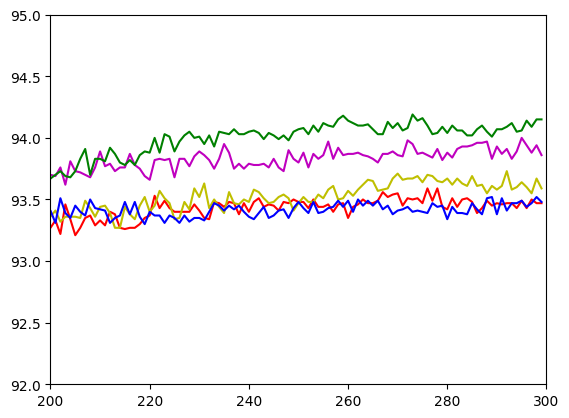

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(vgg19_accuracy, color = 'r')
plt.plot(se_sa_accuracy_vgg, color = 'y')
plt.plot(sec_sa_accuracy_vgg, color = 'b')
plt.plot(cbam_accuracy_vgg, color = 'm')
plt.plot(ours_accuracy_vgg, color = 'g')
plt.xlim([200, 300])      # X축의 범위: [xmin, xmax]
plt.ylim([92, 95])     # Y축의 범위: [ymin, ymax]
plt.show()

#### Conclusion

<span style="color:blue">__We can see that our model shows the highest accuracy after the 220th epoch.__</span>

## 2. Training of ResNet18 with CIFAR-100

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from resnet_cifar.resnet import *
from resnet_cifar.utils import progress_bar

import numpy as np
import random

#import wandb

#################### Random Seed 고정 ####################
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
##########################################################

device = 'cuda' if torch.cuda.is_available() else 'cpu'
parser = argparse.ArgumentParser(description='PyTorch ResNet Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true',
                        help='resume from checkpoint')
parser.add_argument('--epochs', default=200, type=int, metavar='N',
                        help='number of total epochs to run')
parser.add_argument('--dataset', help='dataset', default='cifar100', type=str)
parser.add_argument('--block', help='block type', default='RESNET', type=str)
parser.add_argument('--save_dir', default='save_temp', type=str)
parser.add_argument('--print-freq', '-p', default=20, type=int,
                    metavar='N', help='print frequency (default: 20)')

args = parser.parse_args(args=[])


### 2.1 load CIFAR-100

In [11]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# classes = ('plane', 'car', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck')

if args.dataset == 'cifar10':
    trainset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
            testset, batch_size=100, shuffle=False, num_workers=2)
else:
    trainset = torchvision.datasets.CIFAR100(
            root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR100(
            root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
            testset, batch_size=100, shuffle=False, num_workers=2)


#print(len(testset))
# Model
#print('==> Building model..')


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


### 2.2 Implement funcions

In [12]:
# Training
def train(epoch, trainloader, net, criterion, optimizer):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    last_idx = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        last_idx = batch_idx

        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        if batch_idx % args.print_freq == 0:
            print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


    #wandb.log({
    #    'train_acc': 100.*correct/total,
    #    'train_loss': train_loss/(last_idx+1)
    #})


def test(epoch, testloader, net, criterion, best_acc):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            #print("batch_idx : ", batch_idx)

            #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            if batch_idx % args.print_freq == 0:
                print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    #wandb.log({
    #    'test_acc': 100.*correct/total,
    #    'test_loss': test_loss/(batch_idx+1)
    #})
    acc = 100.*correct/total
    if acc > best_acc:
        #print('Saving..')
        #state = {
        #    'net': net.state_dict(),
        #    'acc': acc,
        #    'epoch': epoch,
        #}
        #save_path = os.path.join(args.save_dir, args.block)
        #if not os.path.exists(save_path):
        #    os.makedirs(save_path)
        #torch.save(state, os.path.join(save_path, 'checkpoint_{}.pth'.format(epoch)))
        best_acc = acc

    return acc

### 2.3 Implement main function for training

In [13]:
def run_model(net):
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch

    print("model : ", net)
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        # cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr,
                          momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    test_accuracy = []
    for idx in range(start_epoch, start_epoch+args.epochs):
        train(idx, trainloader, net, criterion, optimizer)
        acc = test(idx, testloader, net, criterion, best_acc)
        scheduler.step()
        test_accuracy.append(acc)
    return test_accuracy

#### 2.3.1 Train ResNet18 (base model)

In [14]:
args.block = "RESNET"
net = ResNet18(block=args.block, num_classes=100 if args.dataset == 'cifar100' else 10)
resnet_accuracy = run_model(net)

model :  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1

120 391 Loss: 2.762 | Acc: 28.919% (4479/15488)
140 391 Loss: 2.755 | Acc: 29.161% (5263/18048)
160 391 Loss: 2.745 | Acc: 29.382% (6055/20608)
180 391 Loss: 2.731 | Acc: 29.683% (6877/23168)
200 391 Loss: 2.718 | Acc: 29.855% (7681/25728)
220 391 Loss: 2.712 | Acc: 29.938% (8469/28288)
240 391 Loss: 2.705 | Acc: 30.109% (9288/30848)
260 391 Loss: 2.696 | Acc: 30.373% (10147/33408)
280 391 Loss: 2.686 | Acc: 30.661% (11028/35968)
300 391 Loss: 2.678 | Acc: 30.785% (11861/38528)
320 391 Loss: 2.668 | Acc: 30.973% (12726/41088)
340 391 Loss: 2.659 | Acc: 31.172% (13606/43648)
360 391 Loss: 2.648 | Acc: 31.401% (14510/46208)
380 391 Loss: 2.638 | Acc: 31.574% (15398/48768)
0 100 Loss: 2.477 | Acc: 36.000% (36/100)
20 100 Loss: 2.530 | Acc: 34.619% (727/2100)
40 100 Loss: 2.509 | Acc: 34.951% (1433/4100)
60 100 Loss: 2.524 | Acc: 34.574% (2109/6100)
80 100 Loss: 2.528 | Acc: 34.481% (2793/8100)
acc :  34.72

Epoch: 4
0 391 Loss: 2.386 | Acc: 32.812% (42/128)
20 391 Loss: 2.298 | Acc: 37.57

20 391 Loss: 1.513 | Acc: 55.655% (1496/2688)
40 391 Loss: 1.483 | Acc: 56.879% (2985/5248)
60 391 Loss: 1.466 | Acc: 57.877% (4519/7808)
80 391 Loss: 1.464 | Acc: 58.044% (6018/10368)
100 391 Loss: 1.469 | Acc: 58.091% (7510/12928)
120 391 Loss: 1.466 | Acc: 58.258% (9023/15488)
140 391 Loss: 1.472 | Acc: 58.217% (10507/18048)
160 391 Loss: 1.468 | Acc: 58.303% (12015/20608)
180 391 Loss: 1.470 | Acc: 58.192% (13482/23168)
200 391 Loss: 1.467 | Acc: 58.248% (14986/25728)
220 391 Loss: 1.477 | Acc: 58.000% (16407/28288)
240 391 Loss: 1.480 | Acc: 58.017% (17897/30848)
260 391 Loss: 1.488 | Acc: 57.980% (19370/33408)
280 391 Loss: 1.487 | Acc: 57.974% (20852/35968)
300 391 Loss: 1.485 | Acc: 57.971% (22335/38528)
320 391 Loss: 1.489 | Acc: 57.830% (23761/41088)
340 391 Loss: 1.492 | Acc: 57.721% (25194/43648)
360 391 Loss: 1.493 | Acc: 57.691% (26658/46208)
380 391 Loss: 1.493 | Acc: 57.694% (28136/48768)
0 100 Loss: 1.884 | Acc: 53.000% (53/100)
20 100 Loss: 1.973 | Acc: 49.762% (1045/

20 100 Loss: 1.689 | Acc: 56.238% (1181/2100)
40 100 Loss: 1.713 | Acc: 54.146% (2220/4100)
60 100 Loss: 1.729 | Acc: 53.738% (3278/6100)
80 100 Loss: 1.740 | Acc: 53.704% (4350/8100)
acc :  54.0

Epoch: 17
0 391 Loss: 1.095 | Acc: 69.531% (89/128)
20 391 Loss: 1.193 | Acc: 66.332% (1783/2688)
40 391 Loss: 1.168 | Acc: 66.597% (3495/5248)
60 391 Loss: 1.152 | Acc: 67.188% (5246/7808)
80 391 Loss: 1.159 | Acc: 66.782% (6924/10368)
100 391 Loss: 1.159 | Acc: 66.638% (8615/12928)
120 391 Loss: 1.173 | Acc: 66.142% (10244/15488)
140 391 Loss: 1.170 | Acc: 66.273% (11961/18048)
160 391 Loss: 1.188 | Acc: 65.727% (13545/20608)
180 391 Loss: 1.197 | Acc: 65.470% (15168/23168)
200 391 Loss: 1.203 | Acc: 65.256% (16789/25728)
220 391 Loss: 1.210 | Acc: 65.017% (18392/28288)
240 391 Loss: 1.217 | Acc: 64.798% (19989/30848)
260 391 Loss: 1.225 | Acc: 64.595% (21580/33408)
280 391 Loss: 1.229 | Acc: 64.488% (23195/35968)
300 391 Loss: 1.234 | Acc: 64.345% (24791/38528)
320 391 Loss: 1.239 | Acc: 6

320 391 Loss: 1.129 | Acc: 67.127% (27581/41088)
340 391 Loss: 1.133 | Acc: 67.009% (29248/43648)
360 391 Loss: 1.136 | Acc: 66.919% (30922/46208)
380 391 Loss: 1.141 | Acc: 66.786% (32570/48768)
0 100 Loss: 1.839 | Acc: 62.000% (62/100)
20 100 Loss: 1.879 | Acc: 54.619% (1147/2100)
40 100 Loss: 1.852 | Acc: 54.463% (2233/4100)
60 100 Loss: 1.827 | Acc: 54.443% (3321/6100)
80 100 Loss: 1.838 | Acc: 53.926% (4368/8100)
acc :  54.02

Epoch: 24
0 391 Loss: 1.051 | Acc: 71.094% (91/128)
20 391 Loss: 1.087 | Acc: 68.266% (1835/2688)
40 391 Loss: 1.082 | Acc: 68.140% (3576/5248)
60 391 Loss: 1.074 | Acc: 68.635% (5359/7808)
80 391 Loss: 1.081 | Acc: 68.509% (7103/10368)
100 391 Loss: 1.087 | Acc: 68.340% (8835/12928)
120 391 Loss: 1.092 | Acc: 68.111% (10549/15488)
140 391 Loss: 1.100 | Acc: 67.958% (12265/18048)
160 391 Loss: 1.107 | Acc: 67.663% (13944/20608)
180 391 Loss: 1.113 | Acc: 67.580% (15657/23168)
200 391 Loss: 1.116 | Acc: 67.514% (17370/25728)
220 391 Loss: 1.116 | Acc: 67.347%

220 391 Loss: 1.048 | Acc: 69.079% (19541/28288)
240 391 Loss: 1.048 | Acc: 69.087% (21312/30848)
260 391 Loss: 1.048 | Acc: 69.082% (23079/33408)
280 391 Loss: 1.051 | Acc: 69.070% (24843/35968)
300 391 Loss: 1.053 | Acc: 69.015% (26590/38528)
320 391 Loss: 1.056 | Acc: 68.906% (28312/41088)
340 391 Loss: 1.061 | Acc: 68.777% (30020/43648)
360 391 Loss: 1.064 | Acc: 68.687% (31739/46208)
380 391 Loss: 1.067 | Acc: 68.656% (33482/48768)
0 100 Loss: 1.644 | Acc: 57.000% (57/100)
20 100 Loss: 1.790 | Acc: 54.429% (1143/2100)
40 100 Loss: 1.787 | Acc: 54.317% (2227/4100)
60 100 Loss: 1.757 | Acc: 55.131% (3363/6100)
80 100 Loss: 1.775 | Acc: 54.988% (4454/8100)
acc :  55.2

Epoch: 31
0 391 Loss: 0.863 | Acc: 75.781% (97/128)
20 391 Loss: 0.977 | Acc: 70.833% (1904/2688)
40 391 Loss: 0.961 | Acc: 71.513% (3753/5248)
60 391 Loss: 0.967 | Acc: 71.311% (5568/7808)
80 391 Loss: 0.985 | Acc: 70.766% (7337/10368)
100 391 Loss: 0.994 | Acc: 70.668% (9136/12928)
120 391 Loss: 1.007 | Acc: 70.222% 

120 391 Loss: 0.942 | Acc: 72.198% (11182/15488)
140 391 Loss: 0.949 | Acc: 72.014% (12997/18048)
160 391 Loss: 0.961 | Acc: 71.652% (14766/20608)
180 391 Loss: 0.970 | Acc: 71.366% (16534/23168)
200 391 Loss: 0.977 | Acc: 71.164% (18309/25728)
220 391 Loss: 0.984 | Acc: 70.977% (20078/28288)
240 391 Loss: 0.989 | Acc: 70.857% (21858/30848)
260 391 Loss: 0.991 | Acc: 70.729% (23629/33408)
280 391 Loss: 0.997 | Acc: 70.621% (25401/35968)
300 391 Loss: 1.000 | Acc: 70.525% (27172/38528)
320 391 Loss: 1.007 | Acc: 70.325% (28895/41088)
340 391 Loss: 1.010 | Acc: 70.312% (30690/43648)
360 391 Loss: 1.013 | Acc: 70.248% (32460/46208)
380 391 Loss: 1.016 | Acc: 70.155% (34213/48768)
0 100 Loss: 1.388 | Acc: 61.000% (61/100)
20 100 Loss: 1.545 | Acc: 60.667% (1274/2100)
40 100 Loss: 1.570 | Acc: 59.390% (2435/4100)
60 100 Loss: 1.566 | Acc: 59.131% (3607/6100)
80 100 Loss: 1.587 | Acc: 58.691% (4754/8100)
acc :  58.82

Epoch: 38
0 391 Loss: 1.062 | Acc: 69.531% (89/128)
20 391 Loss: 0.888 | A

0 391 Loss: 0.905 | Acc: 75.000% (96/128)
20 391 Loss: 0.888 | Acc: 74.182% (1994/2688)
40 391 Loss: 0.892 | Acc: 73.838% (3875/5248)
60 391 Loss: 0.898 | Acc: 73.309% (5724/7808)
80 391 Loss: 0.896 | Acc: 73.438% (7614/10368)
100 391 Loss: 0.890 | Acc: 73.716% (9530/12928)
120 391 Loss: 0.893 | Acc: 73.534% (11389/15488)
140 391 Loss: 0.903 | Acc: 73.305% (13230/18048)
160 391 Loss: 0.913 | Acc: 73.035% (15051/20608)
180 391 Loss: 0.919 | Acc: 72.859% (16880/23168)
200 391 Loss: 0.923 | Acc: 72.707% (18706/25728)
220 391 Loss: 0.924 | Acc: 72.692% (20563/28288)
240 391 Loss: 0.934 | Acc: 72.436% (22345/30848)
260 391 Loss: 0.940 | Acc: 72.234% (24132/33408)
280 391 Loss: 0.943 | Acc: 72.156% (25953/35968)
300 391 Loss: 0.950 | Acc: 71.937% (27716/38528)
320 391 Loss: 0.955 | Acc: 71.826% (29512/41088)
340 391 Loss: 0.959 | Acc: 71.770% (31326/43648)
360 391 Loss: 0.961 | Acc: 71.724% (33142/46208)
380 391 Loss: 0.963 | Acc: 71.697% (34965/48768)
0 100 Loss: 1.422 | Acc: 59.000% (59/10

0 100 Loss: 1.361 | Acc: 61.000% (61/100)
20 100 Loss: 1.569 | Acc: 59.667% (1253/2100)
40 100 Loss: 1.560 | Acc: 60.024% (2461/4100)
60 100 Loss: 1.554 | Acc: 59.869% (3652/6100)
80 100 Loss: 1.567 | Acc: 59.914% (4853/8100)
acc :  60.19

Epoch: 51
0 391 Loss: 0.929 | Acc: 67.969% (87/128)
20 391 Loss: 0.813 | Acc: 74.516% (2003/2688)
40 391 Loss: 0.783 | Acc: 76.467% (4013/5248)
60 391 Loss: 0.779 | Acc: 76.639% (5984/7808)
80 391 Loss: 0.788 | Acc: 76.244% (7905/10368)
100 391 Loss: 0.800 | Acc: 75.681% (9784/12928)
120 391 Loss: 0.812 | Acc: 75.349% (11670/15488)
140 391 Loss: 0.828 | Acc: 75.017% (13539/18048)
160 391 Loss: 0.836 | Acc: 75.000% (15456/20608)
180 391 Loss: 0.850 | Acc: 74.599% (17283/23168)
200 391 Loss: 0.861 | Acc: 74.339% (19126/25728)
220 391 Loss: 0.868 | Acc: 74.275% (21011/28288)
240 391 Loss: 0.873 | Acc: 74.115% (22863/30848)
260 391 Loss: 0.877 | Acc: 73.979% (24715/33408)
280 391 Loss: 0.883 | Acc: 73.852% (26563/35968)
300 391 Loss: 0.891 | Acc: 73.630%

300 391 Loss: 0.878 | Acc: 73.933% (28485/38528)
320 391 Loss: 0.883 | Acc: 73.824% (30333/41088)
340 391 Loss: 0.884 | Acc: 73.761% (32195/43648)
360 391 Loss: 0.887 | Acc: 73.706% (34058/46208)
380 391 Loss: 0.888 | Acc: 73.696% (35940/48768)
0 100 Loss: 1.631 | Acc: 59.000% (59/100)
20 100 Loss: 1.546 | Acc: 59.571% (1251/2100)
40 100 Loss: 1.540 | Acc: 59.146% (2425/4100)
60 100 Loss: 1.557 | Acc: 58.967% (3597/6100)
80 100 Loss: 1.571 | Acc: 59.185% (4794/8100)
acc :  59.51

Epoch: 58
0 391 Loss: 0.794 | Acc: 79.688% (102/128)
20 391 Loss: 0.812 | Acc: 75.930% (2041/2688)
40 391 Loss: 0.807 | Acc: 76.410% (4010/5248)
60 391 Loss: 0.802 | Acc: 76.486% (5972/7808)
80 391 Loss: 0.802 | Acc: 76.447% (7926/10368)
100 391 Loss: 0.810 | Acc: 76.176% (9848/12928)
120 391 Loss: 0.808 | Acc: 76.265% (11812/15488)
140 391 Loss: 0.805 | Acc: 76.269% (13765/18048)
160 391 Loss: 0.807 | Acc: 76.106% (15684/20608)
180 391 Loss: 0.814 | Acc: 75.885% (17581/23168)
200 391 Loss: 0.820 | Acc: 75.797

200 391 Loss: 0.793 | Acc: 76.236% (19614/25728)
220 391 Loss: 0.802 | Acc: 75.997% (21498/28288)
240 391 Loss: 0.810 | Acc: 75.807% (23385/30848)
260 391 Loss: 0.810 | Acc: 75.796% (25322/33408)
280 391 Loss: 0.814 | Acc: 75.742% (27243/35968)
300 391 Loss: 0.819 | Acc: 75.672% (29155/38528)
320 391 Loss: 0.822 | Acc: 75.594% (31060/41088)
340 391 Loss: 0.824 | Acc: 75.490% (32950/43648)
360 391 Loss: 0.827 | Acc: 75.390% (34836/46208)
380 391 Loss: 0.830 | Acc: 75.326% (36735/48768)
0 100 Loss: 1.348 | Acc: 62.000% (62/100)
20 100 Loss: 1.486 | Acc: 60.524% (1271/2100)
40 100 Loss: 1.478 | Acc: 60.878% (2496/4100)
60 100 Loss: 1.474 | Acc: 61.148% (3730/6100)
80 100 Loss: 1.483 | Acc: 61.259% (4962/8100)
acc :  61.51

Epoch: 65
0 391 Loss: 0.718 | Acc: 78.906% (101/128)
20 391 Loss: 0.768 | Acc: 75.930% (2041/2688)
40 391 Loss: 0.746 | Acc: 76.905% (4036/5248)
60 391 Loss: 0.729 | Acc: 77.651% (6063/7808)
80 391 Loss: 0.731 | Acc: 77.672% (8053/10368)
100 391 Loss: 0.725 | Acc: 77.94

80 391 Loss: 0.728 | Acc: 77.951% (8082/10368)
100 391 Loss: 0.725 | Acc: 78.148% (10103/12928)
120 391 Loss: 0.726 | Acc: 78.028% (12085/15488)
140 391 Loss: 0.729 | Acc: 77.920% (14063/18048)
160 391 Loss: 0.739 | Acc: 77.776% (16028/20608)
180 391 Loss: 0.742 | Acc: 77.676% (17996/23168)
200 391 Loss: 0.748 | Acc: 77.550% (19952/25728)
220 391 Loss: 0.752 | Acc: 77.485% (21919/28288)
240 391 Loss: 0.755 | Acc: 77.386% (23872/30848)
260 391 Loss: 0.753 | Acc: 77.404% (25859/33408)
280 391 Loss: 0.751 | Acc: 77.394% (27837/35968)
300 391 Loss: 0.752 | Acc: 77.341% (29798/38528)
320 391 Loss: 0.755 | Acc: 77.251% (31741/41088)
340 391 Loss: 0.760 | Acc: 77.124% (33663/43648)
360 391 Loss: 0.765 | Acc: 76.995% (35578/46208)
380 391 Loss: 0.769 | Acc: 76.876% (37491/48768)
0 100 Loss: 1.431 | Acc: 60.000% (60/100)
20 100 Loss: 1.401 | Acc: 64.143% (1347/2100)
40 100 Loss: 1.426 | Acc: 62.976% (2582/4100)
60 100 Loss: 1.439 | Acc: 62.705% (3825/6100)
80 100 Loss: 1.465 | Acc: 62.469% (506

60 100 Loss: 1.533 | Acc: 61.590% (3757/6100)
80 100 Loss: 1.518 | Acc: 61.802% (5006/8100)
acc :  61.99

Epoch: 78
0 391 Loss: 0.651 | Acc: 82.031% (105/128)
20 391 Loss: 0.648 | Acc: 80.618% (2167/2688)
40 391 Loss: 0.626 | Acc: 81.155% (4259/5248)
60 391 Loss: 0.617 | Acc: 81.314% (6349/7808)
80 391 Loss: 0.617 | Acc: 81.501% (8450/10368)
100 391 Loss: 0.620 | Acc: 81.219% (10500/12928)
120 391 Loss: 0.634 | Acc: 80.798% (12514/15488)
140 391 Loss: 0.638 | Acc: 80.646% (14555/18048)
160 391 Loss: 0.647 | Acc: 80.396% (16568/20608)
180 391 Loss: 0.655 | Acc: 80.154% (18570/23168)
200 391 Loss: 0.667 | Acc: 79.765% (20522/25728)
220 391 Loss: 0.674 | Acc: 79.631% (22526/28288)
240 391 Loss: 0.683 | Acc: 79.383% (24488/30848)
260 391 Loss: 0.690 | Acc: 79.262% (26480/33408)
280 391 Loss: 0.695 | Acc: 79.109% (28454/35968)
300 391 Loss: 0.698 | Acc: 79.002% (30438/38528)
320 391 Loss: 0.702 | Acc: 78.841% (32394/41088)
340 391 Loss: 0.705 | Acc: 78.750% (34373/43648)
360 391 Loss: 0.709

340 391 Loss: 0.656 | Acc: 80.121% (34971/43648)
360 391 Loss: 0.662 | Acc: 79.973% (36954/46208)
380 391 Loss: 0.666 | Acc: 79.821% (38927/48768)
0 100 Loss: 1.475 | Acc: 68.000% (68/100)
20 100 Loss: 1.495 | Acc: 62.571% (1314/2100)
40 100 Loss: 1.491 | Acc: 62.610% (2567/4100)
60 100 Loss: 1.487 | Acc: 62.754% (3828/6100)
80 100 Loss: 1.479 | Acc: 62.654% (5075/8100)
acc :  63.17

Epoch: 85
0 391 Loss: 0.538 | Acc: 80.469% (103/128)
20 391 Loss: 0.594 | Acc: 82.329% (2213/2688)
40 391 Loss: 0.591 | Acc: 82.374% (4323/5248)
60 391 Loss: 0.579 | Acc: 82.646% (6453/7808)
80 391 Loss: 0.569 | Acc: 82.803% (8585/10368)
100 391 Loss: 0.572 | Acc: 82.782% (10702/12928)
120 391 Loss: 0.582 | Acc: 82.393% (12761/15488)
140 391 Loss: 0.584 | Acc: 82.369% (14866/18048)
160 391 Loss: 0.589 | Acc: 82.172% (16934/20608)
180 391 Loss: 0.599 | Acc: 81.785% (18948/23168)
200 391 Loss: 0.604 | Acc: 81.573% (20987/25728)
220 391 Loss: 0.612 | Acc: 81.317% (23003/28288)
240 391 Loss: 0.622 | Acc: 81.11

220 391 Loss: 0.546 | Acc: 83.413% (23596/28288)
240 391 Loss: 0.555 | Acc: 83.114% (25639/30848)
260 391 Loss: 0.561 | Acc: 82.914% (27700/33408)
280 391 Loss: 0.570 | Acc: 82.604% (29711/35968)
300 391 Loss: 0.576 | Acc: 82.363% (31733/38528)
320 391 Loss: 0.583 | Acc: 82.187% (33769/41088)
340 391 Loss: 0.587 | Acc: 82.086% (35829/43648)
360 391 Loss: 0.592 | Acc: 81.882% (37836/46208)
380 391 Loss: 0.596 | Acc: 81.746% (39866/48768)
0 100 Loss: 1.529 | Acc: 65.000% (65/100)
20 100 Loss: 1.443 | Acc: 64.286% (1350/2100)
40 100 Loss: 1.443 | Acc: 64.146% (2630/4100)
60 100 Loss: 1.445 | Acc: 64.016% (3905/6100)
80 100 Loss: 1.454 | Acc: 63.975% (5182/8100)
acc :  64.1

Epoch: 92
0 391 Loss: 0.577 | Acc: 79.688% (102/128)
20 391 Loss: 0.518 | Acc: 83.594% (2247/2688)
40 391 Loss: 0.520 | Acc: 83.822% (4399/5248)
60 391 Loss: 0.521 | Acc: 84.080% (6565/7808)
80 391 Loss: 0.523 | Acc: 83.980% (8707/10368)
100 391 Loss: 0.516 | Acc: 84.166% (10881/12928)
120 391 Loss: 0.514 | Acc: 84.239

100 391 Loss: 0.457 | Acc: 86.023% (11121/12928)
120 391 Loss: 0.461 | Acc: 85.866% (13299/15488)
140 391 Loss: 0.464 | Acc: 85.821% (15489/18048)
160 391 Loss: 0.473 | Acc: 85.535% (17627/20608)
180 391 Loss: 0.481 | Acc: 85.290% (19760/23168)
200 391 Loss: 0.487 | Acc: 85.020% (21874/25728)
220 391 Loss: 0.492 | Acc: 84.891% (24014/28288)
240 391 Loss: 0.497 | Acc: 84.748% (26143/30848)
260 391 Loss: 0.503 | Acc: 84.540% (28243/33408)
280 391 Loss: 0.510 | Acc: 84.336% (30334/35968)
300 391 Loss: 0.515 | Acc: 84.160% (32425/38528)
320 391 Loss: 0.519 | Acc: 84.046% (34533/41088)
340 391 Loss: 0.523 | Acc: 83.892% (36617/43648)
360 391 Loss: 0.526 | Acc: 83.754% (38701/46208)
380 391 Loss: 0.531 | Acc: 83.610% (40775/48768)
0 100 Loss: 1.502 | Acc: 64.000% (64/100)
20 100 Loss: 1.541 | Acc: 63.286% (1329/2100)
40 100 Loss: 1.573 | Acc: 62.610% (2567/4100)
60 100 Loss: 1.591 | Acc: 62.311% (3801/6100)
80 100 Loss: 1.593 | Acc: 61.975% (5020/8100)
acc :  62.29

Epoch: 99
0 391 Loss: 0.3

80 100 Loss: 1.568 | Acc: 62.741% (5082/8100)
acc :  63.21

Epoch: 105
0 391 Loss: 0.631 | Acc: 82.031% (105/128)
20 391 Loss: 0.435 | Acc: 86.905% (2336/2688)
40 391 Loss: 0.411 | Acc: 87.824% (4609/5248)
60 391 Loss: 0.407 | Acc: 88.025% (6873/7808)
80 391 Loss: 0.406 | Acc: 87.982% (9122/10368)
100 391 Loss: 0.407 | Acc: 87.817% (11353/12928)
120 391 Loss: 0.408 | Acc: 87.694% (13582/15488)
140 391 Loss: 0.416 | Acc: 87.583% (15807/18048)
160 391 Loss: 0.418 | Acc: 87.408% (18013/20608)
180 391 Loss: 0.424 | Acc: 87.215% (20206/23168)
200 391 Loss: 0.432 | Acc: 86.956% (22372/25728)
220 391 Loss: 0.436 | Acc: 86.818% (24559/28288)
240 391 Loss: 0.442 | Acc: 86.615% (26719/30848)
260 391 Loss: 0.446 | Acc: 86.452% (28882/33408)
280 391 Loss: 0.451 | Acc: 86.293% (31038/35968)
300 391 Loss: 0.458 | Acc: 86.052% (33154/38528)
320 391 Loss: 0.462 | Acc: 85.889% (35290/41088)
340 391 Loss: 0.468 | Acc: 85.711% (37411/43648)
360 391 Loss: 0.472 | Acc: 85.531% (39522/46208)
380 391 Loss: 0

360 391 Loss: 0.396 | Acc: 87.716% (40532/46208)
380 391 Loss: 0.400 | Acc: 87.566% (42704/48768)
0 100 Loss: 1.388 | Acc: 69.000% (69/100)
20 100 Loss: 1.492 | Acc: 64.429% (1353/2100)
40 100 Loss: 1.498 | Acc: 64.073% (2627/4100)
60 100 Loss: 1.500 | Acc: 64.000% (3904/6100)
80 100 Loss: 1.512 | Acc: 64.173% (5198/8100)
acc :  64.66

Epoch: 112
0 391 Loss: 0.355 | Acc: 91.406% (117/128)
20 391 Loss: 0.357 | Acc: 89.062% (2394/2688)
40 391 Loss: 0.348 | Acc: 89.272% (4685/5248)
60 391 Loss: 0.344 | Acc: 89.472% (6986/7808)
80 391 Loss: 0.348 | Acc: 89.323% (9261/10368)
100 391 Loss: 0.356 | Acc: 89.024% (11509/12928)
120 391 Loss: 0.354 | Acc: 88.998% (13784/15488)
140 391 Loss: 0.353 | Acc: 89.107% (16082/18048)
160 391 Loss: 0.355 | Acc: 88.961% (18333/20608)
180 391 Loss: 0.362 | Acc: 88.709% (20552/23168)
200 391 Loss: 0.369 | Acc: 88.464% (22760/25728)
220 391 Loss: 0.372 | Acc: 88.299% (24978/28288)
240 391 Loss: 0.373 | Acc: 88.203% (27209/30848)
260 391 Loss: 0.376 | Acc: 88.1

240 391 Loss: 0.315 | Acc: 90.281% (27850/30848)
260 391 Loss: 0.316 | Acc: 90.221% (30141/33408)
280 391 Loss: 0.318 | Acc: 90.119% (32414/35968)
300 391 Loss: 0.321 | Acc: 90.012% (34680/38528)
320 391 Loss: 0.327 | Acc: 89.888% (36933/41088)
340 391 Loss: 0.329 | Acc: 89.796% (39194/43648)
360 391 Loss: 0.332 | Acc: 89.703% (41450/46208)
380 391 Loss: 0.335 | Acc: 89.587% (43690/48768)
0 100 Loss: 1.348 | Acc: 66.000% (66/100)
20 100 Loss: 1.346 | Acc: 66.333% (1393/2100)
40 100 Loss: 1.362 | Acc: 66.073% (2709/4100)
60 100 Loss: 1.368 | Acc: 66.164% (4036/6100)
80 100 Loss: 1.373 | Acc: 66.358% (5375/8100)
acc :  66.88

Epoch: 119
0 391 Loss: 0.306 | Acc: 90.625% (116/128)
20 391 Loss: 0.306 | Acc: 90.365% (2429/2688)
40 391 Loss: 0.298 | Acc: 90.625% (4756/5248)
60 391 Loss: 0.295 | Acc: 90.766% (7087/7808)
80 391 Loss: 0.298 | Acc: 90.693% (9403/10368)
100 391 Loss: 0.293 | Acc: 90.989% (11763/12928)
120 391 Loss: 0.293 | Acc: 90.999% (14094/15488)
140 391 Loss: 0.291 | Acc: 91.1

120 391 Loss: 0.238 | Acc: 93.098% (14419/15488)
140 391 Loss: 0.234 | Acc: 93.218% (16824/18048)
160 391 Loss: 0.233 | Acc: 93.255% (19218/20608)
180 391 Loss: 0.233 | Acc: 93.245% (21603/23168)
200 391 Loss: 0.234 | Acc: 93.171% (23971/25728)
220 391 Loss: 0.236 | Acc: 93.103% (26337/28288)
240 391 Loss: 0.240 | Acc: 92.933% (28668/30848)
260 391 Loss: 0.242 | Acc: 92.852% (31020/33408)
280 391 Loss: 0.247 | Acc: 92.694% (33340/35968)
300 391 Loss: 0.252 | Acc: 92.509% (35642/38528)
320 391 Loss: 0.254 | Acc: 92.433% (37979/41088)
340 391 Loss: 0.256 | Acc: 92.385% (40324/43648)
360 391 Loss: 0.259 | Acc: 92.283% (42642/46208)
380 391 Loss: 0.261 | Acc: 92.177% (44953/48768)
0 100 Loss: 1.311 | Acc: 69.000% (69/100)
20 100 Loss: 1.387 | Acc: 67.333% (1414/2100)
40 100 Loss: 1.397 | Acc: 66.634% (2732/4100)
60 100 Loss: 1.400 | Acc: 66.672% (4067/6100)
80 100 Loss: 1.408 | Acc: 66.667% (5400/8100)
acc :  67.09

Epoch: 126
0 391 Loss: 0.286 | Acc: 92.188% (118/128)
20 391 Loss: 0.246 |

acc :  68.17

Epoch: 132
0 391 Loss: 0.187 | Acc: 93.750% (120/128)
20 391 Loss: 0.212 | Acc: 93.490% (2513/2688)
40 391 Loss: 0.198 | Acc: 94.245% (4946/5248)
60 391 Loss: 0.192 | Acc: 94.288% (7362/7808)
80 391 Loss: 0.189 | Acc: 94.406% (9788/10368)
100 391 Loss: 0.190 | Acc: 94.400% (12204/12928)
120 391 Loss: 0.187 | Acc: 94.480% (14633/15488)
140 391 Loss: 0.185 | Acc: 94.542% (17063/18048)
160 391 Loss: 0.184 | Acc: 94.575% (19490/20608)
180 391 Loss: 0.184 | Acc: 94.583% (21913/23168)
200 391 Loss: 0.186 | Acc: 94.512% (24316/25728)
220 391 Loss: 0.186 | Acc: 94.478% (26726/28288)
240 391 Loss: 0.186 | Acc: 94.534% (29162/30848)
260 391 Loss: 0.188 | Acc: 94.486% (31566/33408)
280 391 Loss: 0.189 | Acc: 94.440% (33968/35968)
300 391 Loss: 0.189 | Acc: 94.451% (36390/38528)
320 391 Loss: 0.190 | Acc: 94.417% (38794/41088)
340 391 Loss: 0.192 | Acc: 94.375% (41193/43648)
360 391 Loss: 0.194 | Acc: 94.295% (43572/46208)
380 391 Loss: 0.196 | Acc: 94.213% (45946/48768)
0 100 Loss: 

380 391 Loss: 0.136 | Acc: 96.231% (46930/48768)
0 100 Loss: 1.475 | Acc: 69.000% (69/100)
20 100 Loss: 1.321 | Acc: 69.429% (1458/2100)
40 100 Loss: 1.352 | Acc: 69.098% (2833/4100)
60 100 Loss: 1.353 | Acc: 69.295% (4227/6100)
80 100 Loss: 1.361 | Acc: 69.148% (5601/8100)
acc :  69.55

Epoch: 139
0 391 Loss: 0.080 | Acc: 98.438% (126/128)
20 391 Loss: 0.136 | Acc: 96.391% (2591/2688)
40 391 Loss: 0.142 | Acc: 96.056% (5041/5248)
60 391 Loss: 0.138 | Acc: 96.196% (7511/7808)
80 391 Loss: 0.136 | Acc: 96.277% (9982/10368)
100 391 Loss: 0.138 | Acc: 96.264% (12445/12928)
120 391 Loss: 0.141 | Acc: 96.145% (14891/15488)
140 391 Loss: 0.140 | Acc: 96.121% (17348/18048)
160 391 Loss: 0.140 | Acc: 96.123% (19809/20608)
180 391 Loss: 0.141 | Acc: 96.042% (22251/23168)
200 391 Loss: 0.140 | Acc: 96.070% (24717/25728)
220 391 Loss: 0.140 | Acc: 96.080% (27179/28288)
240 391 Loss: 0.140 | Acc: 96.078% (29638/30848)
260 391 Loss: 0.141 | Acc: 96.100% (32105/33408)
280 391 Loss: 0.142 | Acc: 96.0

260 391 Loss: 0.069 | Acc: 98.339% (32853/33408)
280 391 Loss: 0.070 | Acc: 98.315% (35362/35968)
300 391 Loss: 0.070 | Acc: 98.310% (37877/38528)
320 391 Loss: 0.071 | Acc: 98.289% (40385/41088)
340 391 Loss: 0.072 | Acc: 98.247% (42883/43648)
360 391 Loss: 0.073 | Acc: 98.219% (45385/46208)
380 391 Loss: 0.074 | Acc: 98.187% (47884/48768)
0 100 Loss: 1.068 | Acc: 66.000% (66/100)
20 100 Loss: 1.169 | Acc: 72.429% (1521/2100)
40 100 Loss: 1.204 | Acc: 71.829% (2945/4100)
60 100 Loss: 1.213 | Acc: 71.656% (4371/6100)
80 100 Loss: 1.241 | Acc: 71.321% (5777/8100)
acc :  71.99

Epoch: 146
0 391 Loss: 0.076 | Acc: 98.438% (126/128)
20 391 Loss: 0.068 | Acc: 98.624% (2651/2688)
40 391 Loss: 0.072 | Acc: 98.190% (5153/5248)
60 391 Loss: 0.079 | Acc: 98.028% (7654/7808)
80 391 Loss: 0.080 | Acc: 98.003% (10161/10368)
100 391 Loss: 0.079 | Acc: 98.074% (12679/12928)
120 391 Loss: 0.077 | Acc: 98.160% (15203/15488)
140 391 Loss: 0.076 | Acc: 98.221% (17727/18048)
160 391 Loss: 0.074 | Acc: 98.

140 391 Loss: 0.028 | Acc: 99.640% (17983/18048)
160 391 Loss: 0.028 | Acc: 99.607% (20527/20608)
180 391 Loss: 0.029 | Acc: 99.594% (23074/23168)
200 391 Loss: 0.029 | Acc: 99.588% (25622/25728)
220 391 Loss: 0.030 | Acc: 99.579% (28169/28288)
240 391 Loss: 0.030 | Acc: 99.569% (30715/30848)
260 391 Loss: 0.030 | Acc: 99.560% (33261/33408)
280 391 Loss: 0.030 | Acc: 99.558% (35809/35968)
300 391 Loss: 0.030 | Acc: 99.548% (38354/38528)
320 391 Loss: 0.030 | Acc: 99.550% (40903/41088)
340 391 Loss: 0.030 | Acc: 99.569% (43460/43648)
360 391 Loss: 0.030 | Acc: 99.567% (46008/46208)
380 391 Loss: 0.030 | Acc: 99.567% (48557/48768)
0 100 Loss: 0.894 | Acc: 76.000% (76/100)
20 100 Loss: 1.041 | Acc: 75.381% (1583/2100)
40 100 Loss: 1.076 | Acc: 74.220% (3043/4100)
60 100 Loss: 1.072 | Acc: 74.115% (4521/6100)
80 100 Loss: 1.076 | Acc: 74.111% (6003/8100)
acc :  74.86

Epoch: 153
0 391 Loss: 0.020 | Acc: 100.000% (128/128)
20 391 Loss: 0.023 | Acc: 99.777% (2682/2688)
40 391 Loss: 0.023 | A

20 391 Loss: 0.014 | Acc: 99.851% (2684/2688)
40 391 Loss: 0.015 | Acc: 99.905% (5243/5248)
60 391 Loss: 0.014 | Acc: 99.885% (7799/7808)
80 391 Loss: 0.013 | Acc: 99.913% (10359/10368)
100 391 Loss: 0.013 | Acc: 99.915% (12917/12928)
120 391 Loss: 0.013 | Acc: 99.910% (15474/15488)
140 391 Loss: 0.013 | Acc: 99.917% (18033/18048)
160 391 Loss: 0.013 | Acc: 99.922% (20592/20608)
180 391 Loss: 0.013 | Acc: 99.909% (23147/23168)
200 391 Loss: 0.013 | Acc: 99.911% (25705/25728)
220 391 Loss: 0.013 | Acc: 99.915% (28264/28288)
240 391 Loss: 0.013 | Acc: 99.906% (30819/30848)
260 391 Loss: 0.013 | Acc: 99.904% (33376/33408)
280 391 Loss: 0.014 | Acc: 99.889% (35928/35968)
300 391 Loss: 0.014 | Acc: 99.891% (38486/38528)
320 391 Loss: 0.014 | Acc: 99.893% (41044/41088)
340 391 Loss: 0.014 | Acc: 99.892% (43601/43648)
360 391 Loss: 0.014 | Acc: 99.896% (46160/46208)
380 391 Loss: 0.014 | Acc: 99.900% (48719/48768)
0 100 Loss: 0.966 | Acc: 74.000% (74/100)
20 100 Loss: 0.936 | Acc: 76.762% (16

0 100 Loss: 0.892 | Acc: 74.000% (74/100)
20 100 Loss: 0.914 | Acc: 77.429% (1626/2100)
40 100 Loss: 0.929 | Acc: 76.366% (3131/4100)
60 100 Loss: 0.924 | Acc: 76.672% (4677/6100)
80 100 Loss: 0.931 | Acc: 76.716% (6214/8100)
acc :  77.19

Epoch: 166
0 391 Loss: 0.008 | Acc: 100.000% (128/128)
20 391 Loss: 0.010 | Acc: 100.000% (2688/2688)
40 391 Loss: 0.010 | Acc: 99.981% (5247/5248)
60 391 Loss: 0.011 | Acc: 99.962% (7805/7808)
80 391 Loss: 0.011 | Acc: 99.971% (10365/10368)
100 391 Loss: 0.011 | Acc: 99.977% (12925/12928)
120 391 Loss: 0.011 | Acc: 99.974% (15484/15488)
140 391 Loss: 0.011 | Acc: 99.972% (18043/18048)
160 391 Loss: 0.011 | Acc: 99.976% (20603/20608)
180 391 Loss: 0.011 | Acc: 99.965% (23160/23168)
200 391 Loss: 0.011 | Acc: 99.965% (25719/25728)
220 391 Loss: 0.011 | Acc: 99.968% (28279/28288)
240 391 Loss: 0.011 | Acc: 99.968% (30838/30848)
260 391 Loss: 0.011 | Acc: 99.958% (33394/33408)
280 391 Loss: 0.011 | Acc: 99.961% (35954/35968)
300 391 Loss: 0.011 | Acc: 9

280 391 Loss: 0.010 | Acc: 99.967% (35956/35968)
300 391 Loss: 0.010 | Acc: 99.966% (38515/38528)
320 391 Loss: 0.010 | Acc: 99.961% (41072/41088)
340 391 Loss: 0.010 | Acc: 99.963% (43632/43648)
360 391 Loss: 0.010 | Acc: 99.959% (46189/46208)
380 391 Loss: 0.010 | Acc: 99.959% (48748/48768)
0 100 Loss: 0.872 | Acc: 74.000% (74/100)
20 100 Loss: 0.893 | Acc: 77.952% (1637/2100)
40 100 Loss: 0.918 | Acc: 76.976% (3156/4100)
60 100 Loss: 0.914 | Acc: 77.180% (4708/6100)
80 100 Loss: 0.922 | Acc: 77.247% (6257/8100)
acc :  77.73

Epoch: 173
0 391 Loss: 0.011 | Acc: 100.000% (128/128)
20 391 Loss: 0.009 | Acc: 100.000% (2688/2688)
40 391 Loss: 0.009 | Acc: 99.981% (5247/5248)
60 391 Loss: 0.009 | Acc: 99.974% (7806/7808)
80 391 Loss: 0.009 | Acc: 99.981% (10366/10368)
100 391 Loss: 0.010 | Acc: 99.985% (12926/12928)
120 391 Loss: 0.010 | Acc: 99.961% (15482/15488)
140 391 Loss: 0.010 | Acc: 99.961% (18041/18048)
160 391 Loss: 0.010 | Acc: 99.961% (20600/20608)
180 391 Loss: 0.010 | Acc: 9

160 391 Loss: 0.009 | Acc: 99.976% (20603/20608)
180 391 Loss: 0.009 | Acc: 99.978% (23163/23168)
200 391 Loss: 0.009 | Acc: 99.977% (25722/25728)
220 391 Loss: 0.009 | Acc: 99.975% (28281/28288)
240 391 Loss: 0.009 | Acc: 99.977% (30841/30848)
260 391 Loss: 0.009 | Acc: 99.979% (33401/33408)
280 391 Loss: 0.009 | Acc: 99.981% (35961/35968)
300 391 Loss: 0.009 | Acc: 99.982% (38521/38528)
320 391 Loss: 0.009 | Acc: 99.981% (41080/41088)
340 391 Loss: 0.009 | Acc: 99.982% (43640/43648)
360 391 Loss: 0.009 | Acc: 99.981% (46199/46208)
380 391 Loss: 0.009 | Acc: 99.982% (48759/48768)
0 100 Loss: 0.846 | Acc: 76.000% (76/100)
20 100 Loss: 0.890 | Acc: 78.333% (1645/2100)
40 100 Loss: 0.912 | Acc: 77.195% (3165/4100)
60 100 Loss: 0.909 | Acc: 77.459% (4725/6100)
80 100 Loss: 0.916 | Acc: 77.407% (6270/8100)
acc :  77.88

Epoch: 180
0 391 Loss: 0.008 | Acc: 100.000% (128/128)
20 391 Loss: 0.010 | Acc: 99.963% (2687/2688)
40 391 Loss: 0.010 | Acc: 99.962% (5246/5248)
60 391 Loss: 0.010 | Acc:

40 391 Loss: 0.009 | Acc: 99.962% (5246/5248)
60 391 Loss: 0.009 | Acc: 99.949% (7804/7808)
80 391 Loss: 0.009 | Acc: 99.961% (10364/10368)
100 391 Loss: 0.009 | Acc: 99.969% (12924/12928)
120 391 Loss: 0.009 | Acc: 99.974% (15484/15488)
140 391 Loss: 0.009 | Acc: 99.972% (18043/18048)
160 391 Loss: 0.009 | Acc: 99.976% (20603/20608)
180 391 Loss: 0.009 | Acc: 99.974% (23162/23168)
200 391 Loss: 0.009 | Acc: 99.977% (25722/25728)
220 391 Loss: 0.009 | Acc: 99.972% (28280/28288)
240 391 Loss: 0.009 | Acc: 99.968% (30838/30848)
260 391 Loss: 0.009 | Acc: 99.967% (33397/33408)
280 391 Loss: 0.009 | Acc: 99.967% (35956/35968)
300 391 Loss: 0.010 | Acc: 99.961% (38513/38528)
320 391 Loss: 0.009 | Acc: 99.961% (41072/41088)
340 391 Loss: 0.010 | Acc: 99.956% (43629/43648)
360 391 Loss: 0.010 | Acc: 99.959% (46189/46208)
380 391 Loss: 0.010 | Acc: 99.959% (48748/48768)
0 100 Loss: 0.840 | Acc: 75.000% (75/100)
20 100 Loss: 0.887 | Acc: 78.000% (1638/2100)
40 100 Loss: 0.910 | Acc: 76.756% (31

20 100 Loss: 0.891 | Acc: 78.238% (1643/2100)
40 100 Loss: 0.912 | Acc: 77.073% (3160/4100)
60 100 Loss: 0.908 | Acc: 77.443% (4724/6100)
80 100 Loss: 0.915 | Acc: 77.321% (6263/8100)
acc :  77.85

Epoch: 193
0 391 Loss: 0.008 | Acc: 100.000% (128/128)
20 391 Loss: 0.010 | Acc: 99.926% (2686/2688)
40 391 Loss: 0.009 | Acc: 99.943% (5245/5248)
60 391 Loss: 0.009 | Acc: 99.936% (7803/7808)
80 391 Loss: 0.009 | Acc: 99.932% (10361/10368)
100 391 Loss: 0.009 | Acc: 99.938% (12920/12928)
120 391 Loss: 0.009 | Acc: 99.942% (15479/15488)
140 391 Loss: 0.009 | Acc: 99.950% (18039/18048)
160 391 Loss: 0.009 | Acc: 99.956% (20599/20608)
180 391 Loss: 0.009 | Acc: 99.953% (23157/23168)
200 391 Loss: 0.009 | Acc: 99.949% (25715/25728)
220 391 Loss: 0.009 | Acc: 99.954% (28275/28288)
240 391 Loss: 0.009 | Acc: 99.958% (30835/30848)
260 391 Loss: 0.009 | Acc: 99.958% (33394/33408)
280 391 Loss: 0.009 | Acc: 99.958% (35953/35968)
300 391 Loss: 0.009 | Acc: 99.958% (38512/38528)
320 391 Loss: 0.009 | 

300 391 Loss: 0.009 | Acc: 99.977% (38519/38528)
320 391 Loss: 0.009 | Acc: 99.976% (41078/41088)
340 391 Loss: 0.009 | Acc: 99.973% (43636/43648)
360 391 Loss: 0.009 | Acc: 99.970% (46194/46208)
380 391 Loss: 0.009 | Acc: 99.971% (48754/48768)
0 100 Loss: 0.859 | Acc: 75.000% (75/100)
20 100 Loss: 0.890 | Acc: 78.429% (1647/2100)
40 100 Loss: 0.912 | Acc: 77.122% (3162/4100)
60 100 Loss: 0.908 | Acc: 77.492% (4727/6100)
80 100 Loss: 0.915 | Acc: 77.444% (6273/8100)
acc :  77.94


#### 2.3.2 Train ResNet18 with SE (residual) + SA

In [15]:
args.block = "SE_SA_12"
net = ResNet18(block=args.block, num_classes=100 if args.dataset == 'cifar100' else 10)
se_sa_accuracy = run_model(net)

model :  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (image_module): Sequential(
        (0): SEBlock(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=64, out_features=8, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=8, out_features=64, bias=False)
            (3): Sigmoid()
          )
        

C:\Users\owner\anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 391 Loss: 4.752 | Acc: 0.781% (1/128)
20 391 Loss: 4.919 | Acc: 1.897% (51/2688)
40 391 Loss: 4.752 | Acc: 2.191% (115/5248)
60 391 Loss: 4.624 | Acc: 2.984% (233/7808)
80 391 Loss: 4.523 | Acc: 3.627% (376/10368)
100 391 Loss: 4.440 | Acc: 4.069% (526/12928)
120 391 Loss: 4.382 | Acc: 4.365% (676/15488)
140 391 Loss: 4.335 | Acc: 4.804% (867/18048)
160 391 Loss: 4.292 | Acc: 5.134% (1058/20608)
180 391 Loss: 4.256 | Acc: 5.417% (1255/23168)
200 391 Loss: 4.221 | Acc: 5.737% (1476/25728)
220 391 Loss: 4.197 | Acc: 5.918% (1674/28288)
240 391 Loss: 4.171 | Acc: 6.153% (1898/30848)
260 391 Loss: 4.149 | Acc: 6.355% (2123/33408)
280 391 Loss: 4.126 | Acc: 6.611% (2378/35968)
300 391 Loss: 4.103 | Acc: 6.873% (2648/38528)
320 391 Loss: 4.084 | Acc: 7.099% (2917/41088)
340 391 Loss: 4.065 | Acc: 7.263% (3170/43648)
360 391 Loss: 4.047 | Acc: 7.423% (3430/46208)
380 391 Loss: 4.030 | Acc: 7.634% (3723/48768)
0 100 Loss: 3.728 | Acc: 11.000% (11/100)
20 100 Loss: 3.641 | Acc: 12.857% (270/2

40 100 Loss: 2.066 | Acc: 43.951% (1802/4100)
60 100 Loss: 2.073 | Acc: 44.213% (2697/6100)
80 100 Loss: 2.094 | Acc: 43.827% (3550/8100)
acc :  43.92

Epoch: 7
0 391 Loss: 1.470 | Acc: 57.031% (73/128)
20 391 Loss: 1.658 | Acc: 53.460% (1437/2688)
40 391 Loss: 1.706 | Acc: 52.382% (2749/5248)
60 391 Loss: 1.721 | Acc: 52.139% (4071/7808)
80 391 Loss: 1.733 | Acc: 51.842% (5375/10368)
100 391 Loss: 1.726 | Acc: 52.073% (6732/12928)
120 391 Loss: 1.721 | Acc: 52.208% (8086/15488)
140 391 Loss: 1.709 | Acc: 52.471% (9470/18048)
160 391 Loss: 1.703 | Acc: 52.475% (10814/20608)
180 391 Loss: 1.703 | Acc: 52.460% (12154/23168)
200 391 Loss: 1.709 | Acc: 52.169% (13422/25728)
220 391 Loss: 1.712 | Acc: 52.121% (14744/28288)
240 391 Loss: 1.709 | Acc: 52.282% (16128/30848)
260 391 Loss: 1.712 | Acc: 52.155% (17424/33408)
280 391 Loss: 1.712 | Acc: 52.166% (18763/35968)
300 391 Loss: 1.714 | Acc: 52.185% (20106/38528)
320 391 Loss: 1.718 | Acc: 52.125% (21417/41088)
340 391 Loss: 1.717 | Acc: 

340 391 Loss: 1.338 | Acc: 61.515% (26850/43648)
360 391 Loss: 1.339 | Acc: 61.528% (28431/46208)
380 391 Loss: 1.341 | Acc: 61.520% (30002/48768)
0 100 Loss: 1.544 | Acc: 54.000% (54/100)
20 100 Loss: 1.656 | Acc: 55.143% (1158/2100)
40 100 Loss: 1.661 | Acc: 54.732% (2244/4100)
60 100 Loss: 1.654 | Acc: 54.934% (3351/6100)
80 100 Loss: 1.657 | Acc: 54.728% (4433/8100)
acc :  55.26

Epoch: 14
0 391 Loss: 1.424 | Acc: 60.938% (78/128)
20 391 Loss: 1.263 | Acc: 63.132% (1697/2688)
40 391 Loss: 1.245 | Acc: 63.910% (3354/5248)
60 391 Loss: 1.239 | Acc: 63.883% (4988/7808)
80 391 Loss: 1.250 | Acc: 63.628% (6597/10368)
100 391 Loss: 1.264 | Acc: 63.235% (8175/12928)
120 391 Loss: 1.267 | Acc: 63.268% (9799/15488)
140 391 Loss: 1.275 | Acc: 63.154% (11398/18048)
160 391 Loss: 1.281 | Acc: 63.073% (12998/20608)
180 391 Loss: 1.284 | Acc: 62.949% (14584/23168)
200 391 Loss: 1.287 | Acc: 62.877% (16177/25728)
220 391 Loss: 1.288 | Acc: 62.868% (17784/28288)
240 391 Loss: 1.291 | Acc: 62.831% 

240 391 Loss: 1.142 | Acc: 66.685% (20571/30848)
260 391 Loss: 1.144 | Acc: 66.667% (22272/33408)
280 391 Loss: 1.145 | Acc: 66.640% (23969/35968)
300 391 Loss: 1.151 | Acc: 66.443% (25599/38528)
320 391 Loss: 1.156 | Acc: 66.355% (27264/41088)
340 391 Loss: 1.157 | Acc: 66.324% (28949/43648)
360 391 Loss: 1.162 | Acc: 66.153% (30568/46208)
380 391 Loss: 1.164 | Acc: 66.113% (32242/48768)
0 100 Loss: 1.637 | Acc: 59.000% (59/100)
20 100 Loss: 1.538 | Acc: 58.143% (1221/2100)
40 100 Loss: 1.552 | Acc: 57.561% (2360/4100)
60 100 Loss: 1.563 | Acc: 57.197% (3489/6100)
80 100 Loss: 1.563 | Acc: 57.519% (4659/8100)
acc :  57.98

Epoch: 21
0 391 Loss: 0.902 | Acc: 72.656% (93/128)
20 391 Loss: 1.070 | Acc: 69.122% (1858/2688)
40 391 Loss: 1.092 | Acc: 68.236% (3581/5248)
60 391 Loss: 1.103 | Acc: 67.674% (5284/7808)
80 391 Loss: 1.094 | Acc: 67.949% (7045/10368)
100 391 Loss: 1.102 | Acc: 67.559% (8734/12928)
120 391 Loss: 1.101 | Acc: 67.717% (10488/15488)
140 391 Loss: 1.104 | Acc: 67.603%

140 391 Loss: 1.023 | Acc: 69.941% (12623/18048)
160 391 Loss: 1.026 | Acc: 69.973% (14420/20608)
180 391 Loss: 1.026 | Acc: 69.920% (16199/23168)
200 391 Loss: 1.031 | Acc: 69.788% (17955/25728)
220 391 Loss: 1.036 | Acc: 69.644% (19701/28288)
240 391 Loss: 1.042 | Acc: 69.583% (21465/30848)
260 391 Loss: 1.049 | Acc: 69.349% (23168/33408)
280 391 Loss: 1.054 | Acc: 69.189% (24886/35968)
300 391 Loss: 1.059 | Acc: 69.023% (26593/38528)
320 391 Loss: 1.062 | Acc: 68.920% (28318/41088)
340 391 Loss: 1.064 | Acc: 68.897% (30072/43648)
360 391 Loss: 1.069 | Acc: 68.763% (31774/46208)
380 391 Loss: 1.071 | Acc: 68.736% (33521/48768)
0 100 Loss: 1.583 | Acc: 58.000% (58/100)
20 100 Loss: 1.619 | Acc: 57.048% (1198/2100)
40 100 Loss: 1.645 | Acc: 56.293% (2308/4100)
60 100 Loss: 1.631 | Acc: 56.541% (3449/6100)
80 100 Loss: 1.646 | Acc: 56.099% (4544/8100)
acc :  56.67

Epoch: 28
0 391 Loss: 0.963 | Acc: 75.000% (96/128)
20 391 Loss: 1.036 | Acc: 69.159% (1859/2688)
40 391 Loss: 1.021 | Acc:

20 391 Loss: 0.947 | Acc: 71.205% (1914/2688)
40 391 Loss: 0.932 | Acc: 71.837% (3770/5248)
60 391 Loss: 0.921 | Acc: 72.246% (5641/7808)
80 391 Loss: 0.925 | Acc: 72.280% (7494/10368)
100 391 Loss: 0.940 | Acc: 72.076% (9318/12928)
120 391 Loss: 0.947 | Acc: 71.933% (11141/15488)
140 391 Loss: 0.959 | Acc: 71.598% (12922/18048)
160 391 Loss: 0.967 | Acc: 71.448% (14724/20608)
180 391 Loss: 0.977 | Acc: 71.197% (16495/23168)
200 391 Loss: 0.987 | Acc: 70.771% (18208/25728)
220 391 Loss: 0.991 | Acc: 70.765% (20018/28288)
240 391 Loss: 0.994 | Acc: 70.734% (21820/30848)
260 391 Loss: 0.997 | Acc: 70.624% (23594/33408)
280 391 Loss: 0.999 | Acc: 70.527% (25367/35968)
300 391 Loss: 1.007 | Acc: 70.318% (27092/38528)
320 391 Loss: 1.008 | Acc: 70.310% (28889/41088)
340 391 Loss: 1.011 | Acc: 70.264% (30669/43648)
360 391 Loss: 1.016 | Acc: 70.142% (32411/46208)
380 391 Loss: 1.016 | Acc: 70.105% (34189/48768)
0 100 Loss: 1.426 | Acc: 61.000% (61/100)
20 100 Loss: 1.635 | Acc: 57.714% (1212

20 100 Loss: 1.478 | Acc: 61.048% (1282/2100)
40 100 Loss: 1.494 | Acc: 60.146% (2466/4100)
60 100 Loss: 1.488 | Acc: 60.230% (3674/6100)
80 100 Loss: 1.494 | Acc: 60.370% (4890/8100)
acc :  60.91

Epoch: 41
0 391 Loss: 0.893 | Acc: 70.312% (90/128)
20 391 Loss: 0.920 | Acc: 72.768% (1956/2688)
40 391 Loss: 0.887 | Acc: 73.685% (3867/5248)
60 391 Loss: 0.869 | Acc: 74.142% (5789/7808)
80 391 Loss: 0.872 | Acc: 74.122% (7685/10368)
100 391 Loss: 0.882 | Acc: 73.809% (9542/12928)
120 391 Loss: 0.893 | Acc: 73.405% (11369/15488)
140 391 Loss: 0.900 | Acc: 73.144% (13201/18048)
160 391 Loss: 0.914 | Acc: 72.705% (14983/20608)
180 391 Loss: 0.922 | Acc: 72.553% (16809/23168)
200 391 Loss: 0.926 | Acc: 72.349% (18614/25728)
220 391 Loss: 0.931 | Acc: 72.278% (20446/28288)
240 391 Loss: 0.929 | Acc: 72.332% (22313/30848)
260 391 Loss: 0.932 | Acc: 72.312% (24158/33408)
280 391 Loss: 0.937 | Acc: 72.228% (25979/35968)
300 391 Loss: 0.942 | Acc: 72.176% (27808/38528)
320 391 Loss: 0.943 | Acc: 

320 391 Loss: 0.917 | Acc: 72.863% (29938/41088)
340 391 Loss: 0.921 | Acc: 72.810% (31780/43648)
360 391 Loss: 0.926 | Acc: 72.689% (33588/46208)
380 391 Loss: 0.930 | Acc: 72.529% (35371/48768)
0 100 Loss: 1.749 | Acc: 63.000% (63/100)
20 100 Loss: 1.675 | Acc: 59.857% (1257/2100)
40 100 Loss: 1.701 | Acc: 58.341% (2392/4100)
60 100 Loss: 1.716 | Acc: 57.787% (3525/6100)
80 100 Loss: 1.734 | Acc: 57.444% (4653/8100)
acc :  57.63

Epoch: 48
0 391 Loss: 0.834 | Acc: 74.219% (95/128)
20 391 Loss: 0.790 | Acc: 76.562% (2058/2688)
40 391 Loss: 0.791 | Acc: 76.067% (3992/5248)
60 391 Loss: 0.803 | Acc: 75.845% (5922/7808)
80 391 Loss: 0.804 | Acc: 75.781% (7857/10368)
100 391 Loss: 0.811 | Acc: 75.480% (9758/12928)
120 391 Loss: 0.828 | Acc: 75.019% (11619/15488)
140 391 Loss: 0.836 | Acc: 74.745% (13490/18048)
160 391 Loss: 0.849 | Acc: 74.423% (15337/20608)
180 391 Loss: 0.854 | Acc: 74.400% (17237/23168)
200 391 Loss: 0.865 | Acc: 74.083% (19060/25728)
220 391 Loss: 0.868 | Acc: 74.024%

220 391 Loss: 0.838 | Acc: 74.876% (21181/28288)
240 391 Loss: 0.846 | Acc: 74.605% (23014/30848)
260 391 Loss: 0.851 | Acc: 74.458% (24875/33408)
280 391 Loss: 0.857 | Acc: 74.341% (26739/35968)
300 391 Loss: 0.862 | Acc: 74.115% (28555/38528)
320 391 Loss: 0.866 | Acc: 74.053% (30427/41088)
340 391 Loss: 0.870 | Acc: 73.958% (32281/43648)
360 391 Loss: 0.872 | Acc: 73.946% (34169/46208)
380 391 Loss: 0.875 | Acc: 73.846% (36013/48768)
0 100 Loss: 1.557 | Acc: 60.000% (60/100)
20 100 Loss: 1.495 | Acc: 59.714% (1254/2100)
40 100 Loss: 1.494 | Acc: 59.390% (2435/4100)
60 100 Loss: 1.493 | Acc: 59.443% (3626/6100)
80 100 Loss: 1.508 | Acc: 59.210% (4796/8100)
acc :  59.47

Epoch: 55
0 391 Loss: 0.733 | Acc: 80.469% (103/128)
20 391 Loss: 0.822 | Acc: 75.856% (2039/2688)
40 391 Loss: 0.796 | Acc: 76.639% (4022/5248)
60 391 Loss: 0.788 | Acc: 77.100% (6020/7808)
80 391 Loss: 0.782 | Acc: 76.968% (7980/10368)
100 391 Loss: 0.779 | Acc: 77.042% (9960/12928)
120 391 Loss: 0.776 | Acc: 76.956

120 391 Loss: 0.740 | Acc: 77.460% (11997/15488)
140 391 Loss: 0.749 | Acc: 77.250% (13942/18048)
160 391 Loss: 0.757 | Acc: 77.053% (15879/20608)
180 391 Loss: 0.765 | Acc: 76.878% (17811/23168)
200 391 Loss: 0.769 | Acc: 76.737% (19743/25728)
220 391 Loss: 0.775 | Acc: 76.630% (21677/28288)
240 391 Loss: 0.785 | Acc: 76.446% (23582/30848)
260 391 Loss: 0.792 | Acc: 76.155% (25442/33408)
280 391 Loss: 0.801 | Acc: 75.887% (27295/35968)
300 391 Loss: 0.806 | Acc: 75.745% (29183/38528)
320 391 Loss: 0.810 | Acc: 75.650% (31083/41088)
340 391 Loss: 0.815 | Acc: 75.479% (32945/43648)
360 391 Loss: 0.819 | Acc: 75.377% (34830/46208)
380 391 Loss: 0.824 | Acc: 75.236% (36691/48768)
0 100 Loss: 1.343 | Acc: 66.000% (66/100)
20 100 Loss: 1.446 | Acc: 63.429% (1332/2100)
40 100 Loss: 1.467 | Acc: 62.220% (2551/4100)
60 100 Loss: 1.457 | Acc: 62.180% (3793/6100)
80 100 Loss: 1.475 | Acc: 61.654% (4994/8100)
acc :  61.9

Epoch: 62
0 391 Loss: 0.664 | Acc: 80.469% (103/128)
20 391 Loss: 0.745 | A

0 391 Loss: 0.643 | Acc: 82.031% (105/128)
20 391 Loss: 0.719 | Acc: 78.571% (2112/2688)
40 391 Loss: 0.692 | Acc: 79.192% (4156/5248)
60 391 Loss: 0.698 | Acc: 78.970% (6166/7808)
80 391 Loss: 0.691 | Acc: 79.215% (8213/10368)
100 391 Loss: 0.694 | Acc: 79.223% (10242/12928)
120 391 Loss: 0.697 | Acc: 79.229% (12271/15488)
140 391 Loss: 0.707 | Acc: 78.862% (14233/18048)
160 391 Loss: 0.718 | Acc: 78.523% (16182/20608)
180 391 Loss: 0.726 | Acc: 78.237% (18126/23168)
200 391 Loss: 0.735 | Acc: 77.884% (20038/25728)
220 391 Loss: 0.743 | Acc: 77.648% (21965/28288)
240 391 Loss: 0.749 | Acc: 77.457% (23894/30848)
260 391 Loss: 0.753 | Acc: 77.302% (25825/33408)
280 391 Loss: 0.758 | Acc: 77.210% (27771/35968)
300 391 Loss: 0.764 | Acc: 77.037% (29681/38528)
320 391 Loss: 0.767 | Acc: 76.911% (31601/41088)
340 391 Loss: 0.767 | Acc: 76.860% (33548/43648)
360 391 Loss: 0.772 | Acc: 76.749% (35464/46208)
380 391 Loss: 0.775 | Acc: 76.597% (37355/48768)
0 100 Loss: 1.391 | Acc: 63.000% (63/

0 100 Loss: 1.844 | Acc: 61.000% (61/100)
20 100 Loss: 1.913 | Acc: 57.286% (1203/2100)
40 100 Loss: 1.924 | Acc: 56.902% (2333/4100)
60 100 Loss: 1.917 | Acc: 56.770% (3463/6100)
80 100 Loss: 1.926 | Acc: 56.630% (4587/8100)
acc :  57.26

Epoch: 75
0 391 Loss: 0.644 | Acc: 78.125% (100/128)
20 391 Loss: 0.656 | Acc: 79.725% (2143/2688)
40 391 Loss: 0.669 | Acc: 79.440% (4169/5248)
60 391 Loss: 0.672 | Acc: 79.393% (6199/7808)
80 391 Loss: 0.667 | Acc: 79.745% (8268/10368)
100 391 Loss: 0.671 | Acc: 79.711% (10305/12928)
120 391 Loss: 0.674 | Acc: 79.571% (12324/15488)
140 391 Loss: 0.674 | Acc: 79.571% (14361/18048)
160 391 Loss: 0.675 | Acc: 79.639% (16412/20608)
180 391 Loss: 0.677 | Acc: 79.459% (18409/23168)
200 391 Loss: 0.682 | Acc: 79.248% (20389/25728)
220 391 Loss: 0.685 | Acc: 79.217% (22409/28288)
240 391 Loss: 0.693 | Acc: 78.984% (24365/30848)
260 391 Loss: 0.699 | Acc: 78.828% (26335/33408)
280 391 Loss: 0.703 | Acc: 78.712% (28311/35968)
300 391 Loss: 0.705 | Acc: 78.62

280 391 Loss: 0.640 | Acc: 80.563% (28977/35968)
300 391 Loss: 0.647 | Acc: 80.342% (30954/38528)
320 391 Loss: 0.652 | Acc: 80.201% (32953/41088)
340 391 Loss: 0.657 | Acc: 80.070% (34949/43648)
360 391 Loss: 0.662 | Acc: 79.943% (36940/46208)
380 391 Loss: 0.669 | Acc: 79.765% (38900/48768)
0 100 Loss: 1.615 | Acc: 60.000% (60/100)
20 100 Loss: 1.493 | Acc: 63.190% (1327/2100)
40 100 Loss: 1.488 | Acc: 61.780% (2533/4100)
60 100 Loss: 1.508 | Acc: 61.393% (3745/6100)
80 100 Loss: 1.518 | Acc: 61.296% (4965/8100)
acc :  61.46

Epoch: 82
0 391 Loss: 0.607 | Acc: 82.812% (106/128)
20 391 Loss: 0.610 | Acc: 81.622% (2194/2688)
40 391 Loss: 0.599 | Acc: 82.012% (4304/5248)
60 391 Loss: 0.577 | Acc: 82.646% (6453/7808)
80 391 Loss: 0.570 | Acc: 82.803% (8585/10368)
100 391 Loss: 0.573 | Acc: 82.580% (10676/12928)
120 391 Loss: 0.576 | Acc: 82.438% (12768/15488)
140 391 Loss: 0.587 | Acc: 82.026% (14804/18048)
160 391 Loss: 0.589 | Acc: 82.036% (16906/20608)
180 391 Loss: 0.596 | Acc: 81.80

160 391 Loss: 0.563 | Acc: 82.672% (17037/20608)
180 391 Loss: 0.564 | Acc: 82.709% (19162/23168)
200 391 Loss: 0.570 | Acc: 82.556% (21240/25728)
220 391 Loss: 0.573 | Acc: 82.445% (23322/28288)
240 391 Loss: 0.579 | Acc: 82.261% (25376/30848)
260 391 Loss: 0.582 | Acc: 82.169% (27451/33408)
280 391 Loss: 0.586 | Acc: 82.042% (29509/35968)
300 391 Loss: 0.592 | Acc: 81.850% (31535/38528)
320 391 Loss: 0.597 | Acc: 81.717% (33576/41088)
340 391 Loss: 0.600 | Acc: 81.660% (35643/43648)
360 391 Loss: 0.606 | Acc: 81.421% (37623/46208)
380 391 Loss: 0.609 | Acc: 81.359% (39677/48768)
0 100 Loss: 1.368 | Acc: 63.000% (63/100)
20 100 Loss: 1.429 | Acc: 64.571% (1356/2100)
40 100 Loss: 1.413 | Acc: 64.220% (2633/4100)
60 100 Loss: 1.404 | Acc: 64.311% (3923/6100)
80 100 Loss: 1.426 | Acc: 63.988% (5183/8100)
acc :  64.47

Epoch: 89
0 391 Loss: 0.507 | Acc: 85.938% (110/128)
20 391 Loss: 0.540 | Acc: 83.854% (2254/2688)
40 391 Loss: 0.525 | Acc: 84.280% (4423/5248)
60 391 Loss: 0.508 | Acc: 8

40 391 Loss: 0.517 | Acc: 84.680% (4444/5248)
60 391 Loss: 0.507 | Acc: 84.529% (6600/7808)
80 391 Loss: 0.502 | Acc: 84.597% (8771/10368)
100 391 Loss: 0.495 | Acc: 84.862% (10971/12928)
120 391 Loss: 0.494 | Acc: 84.762% (13128/15488)
140 391 Loss: 0.494 | Acc: 84.719% (15290/18048)
160 391 Loss: 0.497 | Acc: 84.652% (17445/20608)
180 391 Loss: 0.502 | Acc: 84.435% (19562/23168)
200 391 Loss: 0.508 | Acc: 84.231% (21671/25728)
220 391 Loss: 0.513 | Acc: 84.106% (23792/28288)
240 391 Loss: 0.521 | Acc: 83.915% (25886/30848)
260 391 Loss: 0.527 | Acc: 83.678% (27955/33408)
280 391 Loss: 0.531 | Acc: 83.524% (30042/35968)
300 391 Loss: 0.535 | Acc: 83.407% (32135/38528)
320 391 Loss: 0.537 | Acc: 83.309% (34230/41088)
340 391 Loss: 0.540 | Acc: 83.225% (36326/43648)
360 391 Loss: 0.543 | Acc: 83.165% (38429/46208)
380 391 Loss: 0.548 | Acc: 83.057% (40505/48768)
0 100 Loss: 1.506 | Acc: 62.000% (62/100)
20 100 Loss: 1.555 | Acc: 62.238% (1307/2100)
40 100 Loss: 1.541 | Acc: 62.171% (254

20 100 Loss: 1.516 | Acc: 62.286% (1308/2100)
40 100 Loss: 1.490 | Acc: 62.927% (2580/4100)
60 100 Loss: 1.485 | Acc: 62.295% (3800/6100)
80 100 Loss: 1.495 | Acc: 62.173% (5036/8100)
acc :  62.6

Epoch: 102
0 391 Loss: 0.486 | Acc: 86.719% (111/128)
20 391 Loss: 0.451 | Acc: 86.310% (2320/2688)
40 391 Loss: 0.456 | Acc: 86.261% (4527/5248)
60 391 Loss: 0.457 | Acc: 86.283% (6737/7808)
80 391 Loss: 0.448 | Acc: 86.458% (8964/10368)
100 391 Loss: 0.441 | Acc: 86.711% (11210/12928)
120 391 Loss: 0.443 | Acc: 86.609% (13414/15488)
140 391 Loss: 0.448 | Acc: 86.480% (15608/18048)
160 391 Loss: 0.449 | Acc: 86.355% (17796/20608)
180 391 Loss: 0.449 | Acc: 86.192% (19969/23168)
200 391 Loss: 0.455 | Acc: 85.949% (22113/25728)
220 391 Loss: 0.459 | Acc: 85.874% (24292/28288)
240 391 Loss: 0.463 | Acc: 85.753% (26453/30848)
260 391 Loss: 0.466 | Acc: 85.638% (28610/33408)
280 391 Loss: 0.469 | Acc: 85.548% (30770/35968)
300 391 Loss: 0.472 | Acc: 85.455% (32924/38528)
320 391 Loss: 0.473 | Acc

300 391 Loss: 0.409 | Acc: 87.214% (33602/38528)
320 391 Loss: 0.412 | Acc: 87.089% (35783/41088)
340 391 Loss: 0.414 | Acc: 87.014% (37980/43648)
360 391 Loss: 0.418 | Acc: 86.881% (40146/46208)
380 391 Loss: 0.422 | Acc: 86.770% (42316/48768)
0 100 Loss: 1.509 | Acc: 65.000% (65/100)
20 100 Loss: 1.492 | Acc: 65.333% (1372/2100)
40 100 Loss: 1.513 | Acc: 64.707% (2653/4100)
60 100 Loss: 1.515 | Acc: 64.000% (3904/6100)
80 100 Loss: 1.511 | Acc: 63.951% (5180/8100)
acc :  64.26

Epoch: 109
0 391 Loss: 0.402 | Acc: 90.625% (116/128)
20 391 Loss: 0.405 | Acc: 87.574% (2354/2688)
40 391 Loss: 0.385 | Acc: 87.900% (4613/5248)
60 391 Loss: 0.379 | Acc: 88.166% (6884/7808)
80 391 Loss: 0.370 | Acc: 88.580% (9184/10368)
100 391 Loss: 0.370 | Acc: 88.567% (11450/12928)
120 391 Loss: 0.371 | Acc: 88.559% (13716/15488)
140 391 Loss: 0.370 | Acc: 88.608% (15992/18048)
160 391 Loss: 0.369 | Acc: 88.606% (18260/20608)
180 391 Loss: 0.370 | Acc: 88.614% (20530/23168)
200 391 Loss: 0.372 | Acc: 88.4

180 391 Loss: 0.304 | Acc: 90.521% (20972/23168)
200 391 Loss: 0.310 | Acc: 90.411% (23261/25728)
220 391 Loss: 0.313 | Acc: 90.300% (25544/28288)
240 391 Loss: 0.318 | Acc: 90.200% (27825/30848)
260 391 Loss: 0.324 | Acc: 89.975% (30059/33408)
280 391 Loss: 0.332 | Acc: 89.696% (32262/35968)
300 391 Loss: 0.336 | Acc: 89.610% (34525/38528)
320 391 Loss: 0.339 | Acc: 89.484% (36767/41088)
340 391 Loss: 0.343 | Acc: 89.388% (39016/43648)
360 391 Loss: 0.348 | Acc: 89.229% (41231/46208)
380 391 Loss: 0.352 | Acc: 89.104% (43454/48768)
0 100 Loss: 1.348 | Acc: 72.000% (72/100)
20 100 Loss: 1.533 | Acc: 65.190% (1369/2100)
40 100 Loss: 1.524 | Acc: 64.732% (2654/4100)
60 100 Loss: 1.509 | Acc: 64.590% (3940/6100)
80 100 Loss: 1.508 | Acc: 64.543% (5228/8100)
acc :  64.89

Epoch: 116
0 391 Loss: 0.315 | Acc: 91.406% (117/128)
20 391 Loss: 0.342 | Acc: 90.327% (2428/2688)
40 391 Loss: 0.322 | Acc: 90.301% (4739/5248)
60 391 Loss: 0.313 | Acc: 90.753% (7086/7808)
80 391 Loss: 0.306 | Acc: 90.

60 391 Loss: 0.240 | Acc: 92.713% (7239/7808)
80 391 Loss: 0.239 | Acc: 92.747% (9616/10368)
100 391 Loss: 0.233 | Acc: 92.976% (12020/12928)
120 391 Loss: 0.233 | Acc: 92.936% (14394/15488)
140 391 Loss: 0.233 | Acc: 92.930% (16772/18048)
160 391 Loss: 0.236 | Acc: 92.813% (19127/20608)
180 391 Loss: 0.242 | Acc: 92.658% (21467/23168)
200 391 Loss: 0.244 | Acc: 92.600% (23824/25728)
220 391 Loss: 0.247 | Acc: 92.484% (26162/28288)
240 391 Loss: 0.250 | Acc: 92.398% (28503/30848)
260 391 Loss: 0.254 | Acc: 92.268% (30825/33408)
280 391 Loss: 0.256 | Acc: 92.182% (33156/35968)
300 391 Loss: 0.259 | Acc: 92.058% (35468/38528)
320 391 Loss: 0.261 | Acc: 92.003% (37802/41088)
340 391 Loss: 0.264 | Acc: 91.919% (40121/43648)
360 391 Loss: 0.267 | Acc: 91.774% (42407/46208)
380 391 Loss: 0.270 | Acc: 91.706% (44723/48768)
0 100 Loss: 1.193 | Acc: 67.000% (67/100)
20 100 Loss: 1.344 | Acc: 68.333% (1435/2100)
40 100 Loss: 1.362 | Acc: 67.561% (2770/4100)
60 100 Loss: 1.343 | Acc: 67.984% (414

40 100 Loss: 1.317 | Acc: 68.049% (2790/4100)
60 100 Loss: 1.334 | Acc: 67.820% (4137/6100)
80 100 Loss: 1.341 | Acc: 67.926% (5502/8100)
acc :  68.4

Epoch: 129
0 391 Loss: 0.208 | Acc: 92.969% (119/128)
20 391 Loss: 0.207 | Acc: 93.862% (2523/2688)
40 391 Loss: 0.203 | Acc: 93.960% (4931/5248)
60 391 Loss: 0.195 | Acc: 94.249% (7359/7808)
80 391 Loss: 0.193 | Acc: 94.290% (9776/10368)
100 391 Loss: 0.193 | Acc: 94.284% (12189/12928)
120 391 Loss: 0.193 | Acc: 94.279% (14602/15488)
140 391 Loss: 0.192 | Acc: 94.321% (17023/18048)
160 391 Loss: 0.192 | Acc: 94.308% (19435/20608)
180 391 Loss: 0.193 | Acc: 94.268% (21840/23168)
200 391 Loss: 0.195 | Acc: 94.193% (24234/25728)
220 391 Loss: 0.200 | Acc: 94.001% (26591/28288)
240 391 Loss: 0.201 | Acc: 94.003% (28998/30848)
260 391 Loss: 0.204 | Acc: 93.960% (31390/33408)
280 391 Loss: 0.205 | Acc: 93.928% (33784/35968)
300 391 Loss: 0.207 | Acc: 93.898% (36177/38528)
320 391 Loss: 0.208 | Acc: 93.867% (38568/41088)
340 391 Loss: 0.210 | 

320 391 Loss: 0.157 | Acc: 95.553% (39261/41088)
340 391 Loss: 0.158 | Acc: 95.473% (41672/43648)
360 391 Loss: 0.161 | Acc: 95.375% (44071/46208)
380 391 Loss: 0.162 | Acc: 95.345% (46498/48768)
0 100 Loss: 1.403 | Acc: 70.000% (70/100)
20 100 Loss: 1.240 | Acc: 69.619% (1462/2100)
40 100 Loss: 1.219 | Acc: 69.805% (2862/4100)
60 100 Loss: 1.218 | Acc: 70.082% (4275/6100)
80 100 Loss: 1.240 | Acc: 69.778% (5652/8100)
acc :  70.25

Epoch: 136
0 391 Loss: 0.130 | Acc: 97.656% (125/128)
20 391 Loss: 0.139 | Acc: 96.205% (2586/2688)
40 391 Loss: 0.141 | Acc: 96.037% (5040/5248)
60 391 Loss: 0.145 | Acc: 95.889% (7487/7808)
80 391 Loss: 0.143 | Acc: 95.949% (9948/10368)
100 391 Loss: 0.141 | Acc: 95.978% (12408/12928)
120 391 Loss: 0.142 | Acc: 95.926% (14857/15488)
140 391 Loss: 0.143 | Acc: 95.966% (17320/18048)
160 391 Loss: 0.142 | Acc: 95.987% (19781/20608)
180 391 Loss: 0.143 | Acc: 95.986% (22238/23168)
200 391 Loss: 0.141 | Acc: 96.024% (24705/25728)
220 391 Loss: 0.143 | Acc: 95.9

200 391 Loss: 0.095 | Acc: 97.575% (25104/25728)
220 391 Loss: 0.095 | Acc: 97.593% (27607/28288)
240 391 Loss: 0.095 | Acc: 97.585% (30103/30848)
260 391 Loss: 0.096 | Acc: 97.563% (32594/33408)
280 391 Loss: 0.096 | Acc: 97.553% (35088/35968)
300 391 Loss: 0.097 | Acc: 97.529% (37576/38528)
320 391 Loss: 0.098 | Acc: 97.500% (40061/41088)
340 391 Loss: 0.099 | Acc: 97.448% (42534/43648)
360 391 Loss: 0.100 | Acc: 97.403% (45008/46208)
380 391 Loss: 0.102 | Acc: 97.353% (47477/48768)
0 100 Loss: 1.374 | Acc: 73.000% (73/100)
20 100 Loss: 1.247 | Acc: 70.714% (1485/2100)
40 100 Loss: 1.279 | Acc: 70.317% (2883/4100)
60 100 Loss: 1.286 | Acc: 70.246% (4285/6100)
80 100 Loss: 1.322 | Acc: 69.790% (5653/8100)
acc :  70.04

Epoch: 143
0 391 Loss: 0.110 | Acc: 95.312% (122/128)
20 391 Loss: 0.102 | Acc: 97.321% (2616/2688)
40 391 Loss: 0.096 | Acc: 97.389% (5111/5248)
60 391 Loss: 0.091 | Acc: 97.592% (7620/7808)
80 391 Loss: 0.092 | Acc: 97.569% (10116/10368)
100 391 Loss: 0.091 | Acc: 97.

80 391 Loss: 0.041 | Acc: 99.344% (10300/10368)
100 391 Loss: 0.041 | Acc: 99.312% (12839/12928)
120 391 Loss: 0.041 | Acc: 99.283% (15377/15488)
140 391 Loss: 0.039 | Acc: 99.335% (17928/18048)
160 391 Loss: 0.040 | Acc: 99.301% (20464/20608)
180 391 Loss: 0.040 | Acc: 99.279% (23001/23168)
200 391 Loss: 0.041 | Acc: 99.277% (25542/25728)
220 391 Loss: 0.040 | Acc: 99.282% (28085/28288)
240 391 Loss: 0.041 | Acc: 99.261% (30620/30848)
260 391 Loss: 0.041 | Acc: 99.249% (33157/33408)
280 391 Loss: 0.042 | Acc: 99.249% (35698/35968)
300 391 Loss: 0.042 | Acc: 99.252% (38240/38528)
320 391 Loss: 0.042 | Acc: 99.258% (40783/41088)
340 391 Loss: 0.043 | Acc: 99.249% (43320/43648)
360 391 Loss: 0.043 | Acc: 99.240% (45857/46208)
380 391 Loss: 0.043 | Acc: 99.241% (48398/48768)
0 100 Loss: 1.207 | Acc: 74.000% (74/100)
20 100 Loss: 1.117 | Acc: 73.762% (1549/2100)
40 100 Loss: 1.143 | Acc: 73.439% (3011/4100)
60 100 Loss: 1.129 | Acc: 73.475% (4482/6100)
80 100 Loss: 1.129 | Acc: 73.630% (59

60 100 Loss: 1.012 | Acc: 75.492% (4605/6100)
80 100 Loss: 1.023 | Acc: 75.074% (6081/8100)
acc :  75.43

Epoch: 156
0 391 Loss: 0.018 | Acc: 99.219% (127/128)
20 391 Loss: 0.016 | Acc: 99.851% (2684/2688)
40 391 Loss: 0.017 | Acc: 99.848% (5240/5248)
60 391 Loss: 0.019 | Acc: 99.821% (7794/7808)
80 391 Loss: 0.019 | Acc: 99.817% (10349/10368)
100 391 Loss: 0.018 | Acc: 99.845% (12908/12928)
120 391 Loss: 0.018 | Acc: 99.839% (15463/15488)
140 391 Loss: 0.019 | Acc: 99.828% (18017/18048)
160 391 Loss: 0.019 | Acc: 99.825% (20572/20608)
180 391 Loss: 0.019 | Acc: 99.823% (23127/23168)
200 391 Loss: 0.019 | Acc: 99.806% (25678/25728)
220 391 Loss: 0.019 | Acc: 99.806% (28233/28288)
240 391 Loss: 0.019 | Acc: 99.809% (30789/30848)
260 391 Loss: 0.019 | Acc: 99.808% (33344/33408)
280 391 Loss: 0.019 | Acc: 99.814% (35901/35968)
300 391 Loss: 0.019 | Acc: 99.808% (38454/38528)
320 391 Loss: 0.019 | Acc: 99.800% (41006/41088)
340 391 Loss: 0.019 | Acc: 99.810% (43565/43648)
360 391 Loss: 0.0

340 391 Loss: 0.012 | Acc: 99.938% (43621/43648)
360 391 Loss: 0.012 | Acc: 99.937% (46179/46208)
380 391 Loss: 0.012 | Acc: 99.936% (48737/48768)
0 100 Loss: 0.913 | Acc: 80.000% (80/100)
20 100 Loss: 0.902 | Acc: 77.381% (1625/2100)
40 100 Loss: 0.912 | Acc: 77.293% (3169/4100)
60 100 Loss: 0.909 | Acc: 77.393% (4721/6100)
80 100 Loss: 0.925 | Acc: 76.951% (6233/8100)
acc :  77.29

Epoch: 163
0 391 Loss: 0.009 | Acc: 100.000% (128/128)
20 391 Loss: 0.011 | Acc: 99.888% (2685/2688)
40 391 Loss: 0.011 | Acc: 99.924% (5244/5248)
60 391 Loss: 0.011 | Acc: 99.923% (7802/7808)
80 391 Loss: 0.010 | Acc: 99.932% (10361/10368)
100 391 Loss: 0.011 | Acc: 99.923% (12918/12928)
120 391 Loss: 0.011 | Acc: 99.923% (15476/15488)
140 391 Loss: 0.011 | Acc: 99.922% (18034/18048)
160 391 Loss: 0.011 | Acc: 99.927% (20593/20608)
180 391 Loss: 0.012 | Acc: 99.931% (23152/23168)
200 391 Loss: 0.012 | Acc: 99.930% (25710/25728)
220 391 Loss: 0.012 | Acc: 99.933% (28269/28288)
240 391 Loss: 0.012 | Acc: 99

220 391 Loss: 0.010 | Acc: 99.982% (28283/28288)
240 391 Loss: 0.010 | Acc: 99.984% (30843/30848)
260 391 Loss: 0.010 | Acc: 99.985% (33403/33408)
280 391 Loss: 0.010 | Acc: 99.981% (35961/35968)
300 391 Loss: 0.010 | Acc: 99.982% (38521/38528)
320 391 Loss: 0.010 | Acc: 99.976% (41078/41088)
340 391 Loss: 0.010 | Acc: 99.970% (43635/43648)
360 391 Loss: 0.010 | Acc: 99.972% (46195/46208)
380 391 Loss: 0.010 | Acc: 99.971% (48754/48768)
0 100 Loss: 1.011 | Acc: 75.000% (75/100)
20 100 Loss: 0.882 | Acc: 78.714% (1653/2100)
40 100 Loss: 0.901 | Acc: 78.220% (3207/4100)
60 100 Loss: 0.891 | Acc: 78.131% (4766/6100)
80 100 Loss: 0.909 | Acc: 77.605% (6286/8100)
acc :  77.99

Epoch: 170
0 391 Loss: 0.010 | Acc: 100.000% (128/128)
20 391 Loss: 0.008 | Acc: 100.000% (2688/2688)
40 391 Loss: 0.009 | Acc: 100.000% (5248/5248)
60 391 Loss: 0.009 | Acc: 99.987% (7807/7808)
80 391 Loss: 0.009 | Acc: 99.971% (10365/10368)
100 391 Loss: 0.009 | Acc: 99.977% (12925/12928)
120 391 Loss: 0.010 | Acc: 

100 391 Loss: 0.010 | Acc: 99.977% (12925/12928)
120 391 Loss: 0.009 | Acc: 99.981% (15485/15488)
140 391 Loss: 0.010 | Acc: 99.972% (18043/18048)
160 391 Loss: 0.010 | Acc: 99.966% (20601/20608)
180 391 Loss: 0.010 | Acc: 99.970% (23161/23168)
200 391 Loss: 0.010 | Acc: 99.973% (25721/25728)
220 391 Loss: 0.010 | Acc: 99.965% (28278/28288)
240 391 Loss: 0.010 | Acc: 99.958% (30835/30848)
260 391 Loss: 0.010 | Acc: 99.958% (33394/33408)
280 391 Loss: 0.010 | Acc: 99.961% (35954/35968)
300 391 Loss: 0.010 | Acc: 99.964% (38514/38528)
320 391 Loss: 0.010 | Acc: 99.966% (41074/41088)
340 391 Loss: 0.010 | Acc: 99.966% (43633/43648)
360 391 Loss: 0.010 | Acc: 99.965% (46192/46208)
380 391 Loss: 0.010 | Acc: 99.967% (48752/48768)
0 100 Loss: 0.984 | Acc: 78.000% (78/100)
20 100 Loss: 0.868 | Acc: 78.476% (1648/2100)
40 100 Loss: 0.889 | Acc: 78.268% (3209/4100)
60 100 Loss: 0.885 | Acc: 78.197% (4770/6100)
80 100 Loss: 0.902 | Acc: 77.580% (6284/8100)
acc :  78.1

Epoch: 177
0 391 Loss: 0.0

80 100 Loss: 0.897 | Acc: 77.852% (6306/8100)
acc :  78.29

Epoch: 183
0 391 Loss: 0.013 | Acc: 100.000% (128/128)
20 391 Loss: 0.009 | Acc: 99.963% (2687/2688)
40 391 Loss: 0.009 | Acc: 99.981% (5247/5248)
60 391 Loss: 0.009 | Acc: 99.962% (7805/7808)
80 391 Loss: 0.009 | Acc: 99.971% (10365/10368)
100 391 Loss: 0.009 | Acc: 99.977% (12925/12928)
120 391 Loss: 0.009 | Acc: 99.981% (15485/15488)
140 391 Loss: 0.009 | Acc: 99.978% (18044/18048)
160 391 Loss: 0.009 | Acc: 99.976% (20603/20608)
180 391 Loss: 0.009 | Acc: 99.974% (23162/23168)
200 391 Loss: 0.009 | Acc: 99.969% (25720/25728)
220 391 Loss: 0.009 | Acc: 99.972% (28280/28288)
240 391 Loss: 0.009 | Acc: 99.971% (30839/30848)
260 391 Loss: 0.009 | Acc: 99.970% (33398/33408)
280 391 Loss: 0.009 | Acc: 99.972% (35958/35968)
300 391 Loss: 0.009 | Acc: 99.971% (38517/38528)
320 391 Loss: 0.009 | Acc: 99.963% (41073/41088)
340 391 Loss: 0.009 | Acc: 99.963% (43632/43648)
360 391 Loss: 0.009 | Acc: 99.965% (46192/46208)
380 391 Loss:

360 391 Loss: 0.009 | Acc: 99.974% (46196/46208)
380 391 Loss: 0.009 | Acc: 99.973% (48755/48768)
0 100 Loss: 0.950 | Acc: 75.000% (75/100)
20 100 Loss: 0.869 | Acc: 78.571% (1650/2100)
40 100 Loss: 0.887 | Acc: 78.024% (3199/4100)
60 100 Loss: 0.880 | Acc: 78.098% (4764/6100)
80 100 Loss: 0.894 | Acc: 77.704% (6294/8100)
acc :  78.26

Epoch: 190
0 391 Loss: 0.007 | Acc: 100.000% (128/128)
20 391 Loss: 0.008 | Acc: 100.000% (2688/2688)
40 391 Loss: 0.008 | Acc: 100.000% (5248/5248)
60 391 Loss: 0.008 | Acc: 100.000% (7808/7808)
80 391 Loss: 0.009 | Acc: 100.000% (10368/10368)
100 391 Loss: 0.009 | Acc: 100.000% (12928/12928)
120 391 Loss: 0.009 | Acc: 100.000% (15488/15488)
140 391 Loss: 0.009 | Acc: 100.000% (18048/18048)
160 391 Loss: 0.009 | Acc: 100.000% (20608/20608)
180 391 Loss: 0.009 | Acc: 99.996% (23167/23168)
200 391 Loss: 0.009 | Acc: 99.988% (25725/25728)
220 391 Loss: 0.009 | Acc: 99.989% (28285/28288)
240 391 Loss: 0.009 | Acc: 99.990% (30845/30848)
260 391 Loss: 0.009 |

240 391 Loss: 0.009 | Acc: 99.971% (30839/30848)
260 391 Loss: 0.009 | Acc: 99.973% (33399/33408)
280 391 Loss: 0.009 | Acc: 99.975% (35959/35968)
300 391 Loss: 0.009 | Acc: 99.977% (38519/38528)
320 391 Loss: 0.009 | Acc: 99.976% (41078/41088)
340 391 Loss: 0.009 | Acc: 99.973% (43636/43648)
360 391 Loss: 0.009 | Acc: 99.968% (46193/46208)
380 391 Loss: 0.009 | Acc: 99.967% (48752/48768)
0 100 Loss: 0.955 | Acc: 76.000% (76/100)
20 100 Loss: 0.869 | Acc: 78.619% (1651/2100)
40 100 Loss: 0.886 | Acc: 78.146% (3204/4100)
60 100 Loss: 0.879 | Acc: 78.279% (4775/6100)
80 100 Loss: 0.894 | Acc: 77.889% (6309/8100)
acc :  78.39

Epoch: 197
0 391 Loss: 0.009 | Acc: 100.000% (128/128)
20 391 Loss: 0.008 | Acc: 100.000% (2688/2688)
40 391 Loss: 0.008 | Acc: 99.981% (5247/5248)
60 391 Loss: 0.008 | Acc: 99.987% (7807/7808)
80 391 Loss: 0.009 | Acc: 99.981% (10366/10368)
100 391 Loss: 0.009 | Acc: 99.985% (12926/12928)
120 391 Loss: 0.009 | Acc: 99.981% (15485/15488)
140 391 Loss: 0.009 | Acc: 9

#### 2.3.3 Train ResNet18 with SE + SA

In [16]:
args.block = "SEC_SA_12"
net = ResNet18(block=args.block, num_classes=100 if args.dataset == 'cifar100' else 10)
sec_sa_accuracy = run_model(net)

model :  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (image_module): Sequential(
        (0): SEBlockCon(
          (pool): AdaptiveAvgPool2d(output_size=1)
          (conv1): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
          (activ): ReLU(inplace=True)
          (conv2): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
          (sigmoid): Sigmoid()
        )
        (1): SpatialGate(
       

60 391 Loss: 3.505 | Acc: 15.497% (1210/7808)
80 391 Loss: 3.502 | Acc: 15.442% (1601/10368)
100 391 Loss: 3.485 | Acc: 15.726% (2033/12928)
120 391 Loss: 3.482 | Acc: 15.554% (2409/15488)
140 391 Loss: 3.476 | Acc: 15.780% (2848/18048)
160 391 Loss: 3.475 | Acc: 15.834% (3263/20608)
180 391 Loss: 3.458 | Acc: 16.078% (3725/23168)
200 391 Loss: 3.449 | Acc: 16.262% (4184/25728)
220 391 Loss: 3.434 | Acc: 16.519% (4673/28288)
240 391 Loss: 3.425 | Acc: 16.714% (5156/30848)
260 391 Loss: 3.419 | Acc: 16.870% (5636/33408)
280 391 Loss: 3.403 | Acc: 17.143% (6166/35968)
300 391 Loss: 3.391 | Acc: 17.393% (6701/38528)
320 391 Loss: 3.380 | Acc: 17.570% (7219/41088)
340 391 Loss: 3.371 | Acc: 17.708% (7729/43648)
360 391 Loss: 3.363 | Acc: 17.861% (8253/46208)
380 391 Loss: 3.355 | Acc: 17.967% (8762/48768)
0 100 Loss: 3.262 | Acc: 20.000% (20/100)
20 100 Loss: 3.192 | Acc: 21.524% (452/2100)
40 100 Loss: 3.186 | Acc: 21.756% (892/4100)
60 100 Loss: 3.182 | Acc: 21.607% (1318/6100)
80 100 Lo

80 100 Loss: 2.052 | Acc: 45.062% (3650/8100)
acc :  45.23

Epoch: 8
0 391 Loss: 1.577 | Acc: 52.344% (67/128)
20 391 Loss: 1.559 | Acc: 54.985% (1478/2688)
40 391 Loss: 1.529 | Acc: 55.964% (2937/5248)
60 391 Loss: 1.531 | Acc: 56.032% (4375/7808)
80 391 Loss: 1.535 | Acc: 56.125% (5819/10368)
100 391 Loss: 1.557 | Acc: 55.515% (7177/12928)
120 391 Loss: 1.551 | Acc: 55.785% (8640/15488)
140 391 Loss: 1.552 | Acc: 55.768% (10065/18048)
160 391 Loss: 1.556 | Acc: 55.755% (11490/20608)
180 391 Loss: 1.558 | Acc: 55.715% (12908/23168)
200 391 Loss: 1.559 | Acc: 55.799% (14356/25728)
220 391 Loss: 1.562 | Acc: 55.684% (15752/28288)
240 391 Loss: 1.563 | Acc: 55.602% (17152/30848)
260 391 Loss: 1.564 | Acc: 55.657% (18594/33408)
280 391 Loss: 1.563 | Acc: 55.683% (20028/35968)
300 391 Loss: 1.563 | Acc: 55.721% (21468/38528)
320 391 Loss: 1.564 | Acc: 55.680% (22878/41088)
340 391 Loss: 1.563 | Acc: 55.682% (24304/43648)
360 391 Loss: 1.563 | Acc: 55.731% (25752/46208)
380 391 Loss: 1.564 

380 391 Loss: 1.286 | Acc: 62.758% (30606/48768)
0 100 Loss: 2.087 | Acc: 49.000% (49/100)
20 100 Loss: 2.100 | Acc: 46.429% (975/2100)
40 100 Loss: 2.114 | Acc: 46.488% (1906/4100)
60 100 Loss: 2.115 | Acc: 46.639% (2845/6100)
80 100 Loss: 2.102 | Acc: 46.654% (3779/8100)
acc :  46.99

Epoch: 15
0 391 Loss: 1.306 | Acc: 62.500% (80/128)
20 391 Loss: 1.221 | Acc: 64.360% (1730/2688)
40 391 Loss: 1.207 | Acc: 65.091% (3416/5248)
60 391 Loss: 1.220 | Acc: 64.703% (5052/7808)
80 391 Loss: 1.223 | Acc: 64.593% (6697/10368)
100 391 Loss: 1.218 | Acc: 64.797% (8377/12928)
120 391 Loss: 1.230 | Acc: 64.482% (9987/15488)
140 391 Loss: 1.236 | Acc: 64.212% (11589/18048)
160 391 Loss: 1.243 | Acc: 64.009% (13191/20608)
180 391 Loss: 1.242 | Acc: 63.998% (14827/23168)
200 391 Loss: 1.245 | Acc: 63.911% (16443/25728)
220 391 Loss: 1.248 | Acc: 63.776% (18041/28288)
240 391 Loss: 1.247 | Acc: 63.894% (19710/30848)
260 391 Loss: 1.251 | Acc: 63.670% (21271/33408)
280 391 Loss: 1.251 | Acc: 63.707% (

280 391 Loss: 1.128 | Acc: 67.015% (24104/35968)
300 391 Loss: 1.137 | Acc: 66.751% (25718/38528)
320 391 Loss: 1.137 | Acc: 66.764% (27432/41088)
340 391 Loss: 1.139 | Acc: 66.716% (29120/43648)
360 391 Loss: 1.139 | Acc: 66.755% (30846/46208)
380 391 Loss: 1.141 | Acc: 66.695% (32526/48768)
0 100 Loss: 1.503 | Acc: 60.000% (60/100)
20 100 Loss: 1.556 | Acc: 58.619% (1231/2100)
40 100 Loss: 1.574 | Acc: 57.902% (2374/4100)
60 100 Loss: 1.564 | Acc: 57.967% (3536/6100)
80 100 Loss: 1.570 | Acc: 57.963% (4695/8100)
acc :  58.56

Epoch: 22
0 391 Loss: 1.140 | Acc: 66.406% (85/128)
20 391 Loss: 1.030 | Acc: 70.126% (1885/2688)
40 391 Loss: 1.041 | Acc: 69.665% (3656/5248)
60 391 Loss: 1.049 | Acc: 69.288% (5410/7808)
80 391 Loss: 1.060 | Acc: 68.875% (7141/10368)
100 391 Loss: 1.066 | Acc: 68.742% (8887/12928)
120 391 Loss: 1.069 | Acc: 68.685% (10638/15488)
140 391 Loss: 1.076 | Acc: 68.700% (12399/18048)
160 391 Loss: 1.073 | Acc: 68.871% (14193/20608)
180 391 Loss: 1.078 | Acc: 68.759%

180 391 Loss: 1.003 | Acc: 70.369% (16303/23168)
200 391 Loss: 1.012 | Acc: 70.075% (18029/25728)
220 391 Loss: 1.013 | Acc: 69.955% (19789/28288)
240 391 Loss: 1.021 | Acc: 69.713% (21505/30848)
260 391 Loss: 1.029 | Acc: 69.477% (23211/33408)
280 391 Loss: 1.036 | Acc: 69.326% (24935/35968)
300 391 Loss: 1.045 | Acc: 69.061% (26608/38528)
320 391 Loss: 1.049 | Acc: 69.006% (28353/41088)
340 391 Loss: 1.052 | Acc: 68.899% (30073/43648)
360 391 Loss: 1.055 | Acc: 68.815% (31798/46208)
380 391 Loss: 1.057 | Acc: 68.744% (33525/48768)
0 100 Loss: 1.536 | Acc: 61.000% (61/100)
20 100 Loss: 1.508 | Acc: 59.762% (1255/2100)
40 100 Loss: 1.489 | Acc: 60.146% (2466/4100)
60 100 Loss: 1.517 | Acc: 59.803% (3648/6100)
80 100 Loss: 1.545 | Acc: 59.086% (4786/8100)
acc :  59.32

Epoch: 29
0 391 Loss: 1.112 | Acc: 65.625% (84/128)
20 391 Loss: 0.995 | Acc: 71.057% (1910/2688)
40 391 Loss: 0.956 | Acc: 71.970% (3777/5248)
60 391 Loss: 0.962 | Acc: 71.849% (5610/7808)
80 391 Loss: 0.953 | Acc: 71.88

80 391 Loss: 0.892 | Acc: 73.592% (7630/10368)
100 391 Loss: 0.903 | Acc: 73.136% (9455/12928)
120 391 Loss: 0.919 | Acc: 72.650% (11252/15488)
140 391 Loss: 0.929 | Acc: 72.352% (13058/18048)
160 391 Loss: 0.934 | Acc: 72.283% (14896/20608)
180 391 Loss: 0.936 | Acc: 72.220% (16732/23168)
200 391 Loss: 0.942 | Acc: 72.159% (18565/25728)
220 391 Loss: 0.955 | Acc: 71.776% (20304/28288)
240 391 Loss: 0.962 | Acc: 71.616% (22092/30848)
260 391 Loss: 0.967 | Acc: 71.399% (23853/33408)
280 391 Loss: 0.970 | Acc: 71.316% (25651/35968)
300 391 Loss: 0.980 | Acc: 71.037% (27369/38528)
320 391 Loss: 0.988 | Acc: 70.787% (29085/41088)
340 391 Loss: 0.990 | Acc: 70.771% (30890/43648)
360 391 Loss: 0.992 | Acc: 70.698% (32668/46208)
380 391 Loss: 0.994 | Acc: 70.665% (34462/48768)
0 100 Loss: 1.499 | Acc: 65.000% (65/100)
20 100 Loss: 1.623 | Acc: 57.571% (1209/2100)
40 100 Loss: 1.628 | Acc: 56.585% (2320/4100)
60 100 Loss: 1.630 | Acc: 56.656% (3456/6100)
80 100 Loss: 1.633 | Acc: 56.531% (4579

80 100 Loss: 1.702 | Acc: 56.630% (4587/8100)
acc :  56.74

Epoch: 42
0 391 Loss: 0.919 | Acc: 70.312% (90/128)
20 391 Loss: 0.893 | Acc: 73.512% (1976/2688)
40 391 Loss: 0.869 | Acc: 74.181% (3893/5248)
60 391 Loss: 0.877 | Acc: 74.103% (5786/7808)
80 391 Loss: 0.880 | Acc: 73.872% (7659/10368)
100 391 Loss: 0.880 | Acc: 73.755% (9535/12928)
120 391 Loss: 0.882 | Acc: 73.663% (11409/15488)
140 391 Loss: 0.887 | Acc: 73.582% (13280/18048)
160 391 Loss: 0.899 | Acc: 73.268% (15099/20608)
180 391 Loss: 0.905 | Acc: 73.187% (16956/23168)
200 391 Loss: 0.911 | Acc: 73.006% (18783/25728)
220 391 Loss: 0.918 | Acc: 72.808% (20596/28288)
240 391 Loss: 0.926 | Acc: 72.527% (22373/30848)
260 391 Loss: 0.932 | Acc: 72.300% (24154/33408)
280 391 Loss: 0.934 | Acc: 72.198% (25968/35968)
300 391 Loss: 0.938 | Acc: 72.135% (27792/38528)
320 391 Loss: 0.943 | Acc: 72.067% (29611/41088)
340 391 Loss: 0.944 | Acc: 72.118% (31478/43648)
360 391 Loss: 0.943 | Acc: 72.137% (33333/46208)
380 391 Loss: 0.94

360 391 Loss: 0.897 | Acc: 73.318% (33879/46208)
380 391 Loss: 0.900 | Acc: 73.243% (35719/48768)
0 100 Loss: 1.449 | Acc: 60.000% (60/100)
20 100 Loss: 1.472 | Acc: 60.857% (1278/2100)
40 100 Loss: 1.479 | Acc: 59.902% (2456/4100)
60 100 Loss: 1.502 | Acc: 59.508% (3630/6100)
80 100 Loss: 1.514 | Acc: 59.741% (4839/8100)
acc :  59.82

Epoch: 49
0 391 Loss: 0.700 | Acc: 78.125% (100/128)
20 391 Loss: 0.779 | Acc: 76.749% (2063/2688)
40 391 Loss: 0.782 | Acc: 76.639% (4022/5248)
60 391 Loss: 0.773 | Acc: 76.729% (5991/7808)
80 391 Loss: 0.779 | Acc: 76.640% (7946/10368)
100 391 Loss: 0.799 | Acc: 75.982% (9823/12928)
120 391 Loss: 0.816 | Acc: 75.562% (11703/15488)
140 391 Loss: 0.821 | Acc: 75.460% (13619/18048)
160 391 Loss: 0.829 | Acc: 75.180% (15493/20608)
180 391 Loss: 0.833 | Acc: 75.117% (17403/23168)
200 391 Loss: 0.840 | Acc: 74.973% (19289/25728)
220 391 Loss: 0.854 | Acc: 74.601% (21103/28288)
240 391 Loss: 0.861 | Acc: 74.446% (22965/30848)
260 391 Loss: 0.869 | Acc: 74.258

260 391 Loss: 0.828 | Acc: 75.195% (25121/33408)
280 391 Loss: 0.835 | Acc: 74.994% (26974/35968)
300 391 Loss: 0.840 | Acc: 74.920% (28865/38528)
320 391 Loss: 0.847 | Acc: 74.725% (30703/41088)
340 391 Loss: 0.850 | Acc: 74.656% (32586/43648)
360 391 Loss: 0.852 | Acc: 74.554% (34450/46208)
380 391 Loss: 0.856 | Acc: 74.475% (36320/48768)
0 100 Loss: 1.619 | Acc: 57.000% (57/100)
20 100 Loss: 1.704 | Acc: 55.333% (1162/2100)
40 100 Loss: 1.698 | Acc: 55.293% (2267/4100)
60 100 Loss: 1.705 | Acc: 55.574% (3390/6100)
80 100 Loss: 1.725 | Acc: 55.247% (4475/8100)
acc :  56.09

Epoch: 56
0 391 Loss: 0.618 | Acc: 78.125% (100/128)
20 391 Loss: 0.792 | Acc: 76.749% (2063/2688)
40 391 Loss: 0.781 | Acc: 76.639% (4022/5248)
60 391 Loss: 0.751 | Acc: 77.677% (6065/7808)
80 391 Loss: 0.759 | Acc: 77.382% (8023/10368)
100 391 Loss: 0.756 | Acc: 77.498% (10019/12928)
120 391 Loss: 0.762 | Acc: 77.324% (11976/15488)
140 391 Loss: 0.777 | Acc: 76.734% (13849/18048)
160 391 Loss: 0.785 | Acc: 76.59

140 391 Loss: 0.755 | Acc: 77.576% (14001/18048)
160 391 Loss: 0.758 | Acc: 77.504% (15972/20608)
180 391 Loss: 0.765 | Acc: 77.344% (17919/23168)
200 391 Loss: 0.765 | Acc: 77.274% (19881/25728)
220 391 Loss: 0.776 | Acc: 76.856% (21741/28288)
240 391 Loss: 0.779 | Acc: 76.715% (23665/30848)
260 391 Loss: 0.786 | Acc: 76.613% (25595/33408)
280 391 Loss: 0.793 | Acc: 76.410% (27483/35968)
300 391 Loss: 0.802 | Acc: 76.134% (29333/38528)
320 391 Loss: 0.807 | Acc: 75.976% (31217/41088)
340 391 Loss: 0.809 | Acc: 75.884% (33122/43648)
360 391 Loss: 0.813 | Acc: 75.770% (35012/46208)
380 391 Loss: 0.819 | Acc: 75.679% (36907/48768)
0 100 Loss: 1.833 | Acc: 57.000% (57/100)
20 100 Loss: 1.631 | Acc: 57.476% (1207/2100)
40 100 Loss: 1.635 | Acc: 56.927% (2334/4100)
60 100 Loss: 1.652 | Acc: 56.410% (3441/6100)
80 100 Loss: 1.657 | Acc: 56.111% (4545/8100)
acc :  56.7

Epoch: 63
0 391 Loss: 0.813 | Acc: 75.781% (97/128)
20 391 Loss: 0.748 | Acc: 77.344% (2079/2688)
40 391 Loss: 0.730 | Acc: 

20 391 Loss: 0.666 | Acc: 80.432% (2162/2688)
40 391 Loss: 0.664 | Acc: 79.802% (4188/5248)
60 391 Loss: 0.668 | Acc: 79.572% (6213/7808)
80 391 Loss: 0.680 | Acc: 79.176% (8209/10368)
100 391 Loss: 0.677 | Acc: 79.525% (10281/12928)
120 391 Loss: 0.684 | Acc: 79.416% (12300/15488)
140 391 Loss: 0.695 | Acc: 78.973% (14253/18048)
160 391 Loss: 0.703 | Acc: 78.615% (16201/20608)
180 391 Loss: 0.712 | Acc: 78.462% (18178/23168)
200 391 Loss: 0.723 | Acc: 78.094% (20092/25728)
220 391 Loss: 0.727 | Acc: 78.037% (22075/28288)
240 391 Loss: 0.731 | Acc: 77.992% (24059/30848)
260 391 Loss: 0.734 | Acc: 77.874% (26016/33408)
280 391 Loss: 0.736 | Acc: 77.780% (27976/35968)
300 391 Loss: 0.742 | Acc: 77.606% (29900/38528)
320 391 Loss: 0.748 | Acc: 77.422% (31811/41088)
340 391 Loss: 0.755 | Acc: 77.222% (33706/43648)
360 391 Loss: 0.760 | Acc: 77.056% (35606/46208)
380 391 Loss: 0.766 | Acc: 76.907% (37506/48768)
0 100 Loss: 1.492 | Acc: 63.000% (63/100)
20 100 Loss: 1.398 | Acc: 62.714% (131

0 100 Loss: 1.562 | Acc: 62.000% (62/100)
20 100 Loss: 1.792 | Acc: 58.048% (1219/2100)
40 100 Loss: 1.789 | Acc: 57.512% (2358/4100)
60 100 Loss: 1.825 | Acc: 56.475% (3445/6100)
80 100 Loss: 1.835 | Acc: 56.691% (4592/8100)
acc :  57.04

Epoch: 76
0 391 Loss: 0.552 | Acc: 84.375% (108/128)
20 391 Loss: 0.695 | Acc: 79.762% (2144/2688)
40 391 Loss: 0.667 | Acc: 80.469% (4223/5248)
60 391 Loss: 0.651 | Acc: 80.571% (6291/7808)
80 391 Loss: 0.646 | Acc: 80.594% (8356/10368)
100 391 Loss: 0.646 | Acc: 80.608% (10421/12928)
120 391 Loss: 0.651 | Acc: 80.436% (12458/15488)
140 391 Loss: 0.658 | Acc: 80.120% (14460/18048)
160 391 Loss: 0.663 | Acc: 79.964% (16479/20608)
180 391 Loss: 0.666 | Acc: 79.882% (18507/23168)
200 391 Loss: 0.668 | Acc: 79.843% (20542/25728)
220 391 Loss: 0.673 | Acc: 79.719% (22551/28288)
240 391 Loss: 0.677 | Acc: 79.561% (24543/30848)
260 391 Loss: 0.683 | Acc: 79.427% (26535/33408)
280 391 Loss: 0.687 | Acc: 79.307% (28525/35968)
300 391 Loss: 0.695 | Acc: 79.04

280 391 Loss: 0.640 | Acc: 80.580% (28983/35968)
300 391 Loss: 0.646 | Acc: 80.399% (30976/38528)
320 391 Loss: 0.650 | Acc: 80.269% (32981/41088)
340 391 Loss: 0.655 | Acc: 80.137% (34978/43648)
360 391 Loss: 0.659 | Acc: 80.029% (36980/46208)
380 391 Loss: 0.663 | Acc: 79.901% (38966/48768)
0 100 Loss: 1.488 | Acc: 63.000% (63/100)
20 100 Loss: 1.467 | Acc: 62.429% (1311/2100)
40 100 Loss: 1.488 | Acc: 61.732% (2531/4100)
60 100 Loss: 1.508 | Acc: 61.443% (3748/6100)
80 100 Loss: 1.526 | Acc: 61.457% (4978/8100)
acc :  61.67

Epoch: 83
0 391 Loss: 0.591 | Acc: 82.812% (106/128)
20 391 Loss: 0.580 | Acc: 82.440% (2216/2688)
40 391 Loss: 0.575 | Acc: 82.374% (4323/5248)
60 391 Loss: 0.567 | Acc: 82.390% (6433/7808)
80 391 Loss: 0.575 | Acc: 82.253% (8528/10368)
100 391 Loss: 0.582 | Acc: 82.039% (10606/12928)
120 391 Loss: 0.580 | Acc: 82.096% (12715/15488)
140 391 Loss: 0.584 | Acc: 81.959% (14792/18048)
160 391 Loss: 0.593 | Acc: 81.721% (16841/20608)
180 391 Loss: 0.599 | Acc: 81.51

160 391 Loss: 0.534 | Acc: 83.754% (17260/20608)
180 391 Loss: 0.540 | Acc: 83.624% (19374/23168)
200 391 Loss: 0.544 | Acc: 83.497% (21482/25728)
220 391 Loss: 0.548 | Acc: 83.311% (23567/28288)
240 391 Loss: 0.558 | Acc: 83.026% (25612/30848)
260 391 Loss: 0.564 | Acc: 82.774% (27653/33408)
280 391 Loss: 0.569 | Acc: 82.673% (29736/35968)
300 391 Loss: 0.572 | Acc: 82.535% (31799/38528)
320 391 Loss: 0.578 | Acc: 82.367% (33843/41088)
340 391 Loss: 0.581 | Acc: 82.235% (35894/43648)
360 391 Loss: 0.583 | Acc: 82.165% (37967/46208)
380 391 Loss: 0.586 | Acc: 82.099% (40038/48768)
0 100 Loss: 1.622 | Acc: 62.000% (62/100)
20 100 Loss: 1.577 | Acc: 61.381% (1289/2100)
40 100 Loss: 1.563 | Acc: 61.756% (2532/4100)
60 100 Loss: 1.559 | Acc: 62.066% (3786/6100)
80 100 Loss: 1.569 | Acc: 61.914% (5015/8100)
acc :  62.22

Epoch: 90
0 391 Loss: 0.589 | Acc: 80.469% (103/128)
20 391 Loss: 0.541 | Acc: 83.445% (2243/2688)
40 391 Loss: 0.520 | Acc: 84.089% (4413/5248)
60 391 Loss: 0.513 | Acc: 8

40 391 Loss: 0.497 | Acc: 85.194% (4471/5248)
60 391 Loss: 0.487 | Acc: 85.502% (6676/7808)
80 391 Loss: 0.485 | Acc: 85.446% (8859/10368)
100 391 Loss: 0.486 | Acc: 85.435% (11045/12928)
120 391 Loss: 0.482 | Acc: 85.511% (13244/15488)
140 391 Loss: 0.479 | Acc: 85.616% (15452/18048)
160 391 Loss: 0.483 | Acc: 85.481% (17616/20608)
180 391 Loss: 0.489 | Acc: 85.320% (19767/23168)
200 391 Loss: 0.491 | Acc: 85.238% (21930/25728)
220 391 Loss: 0.491 | Acc: 85.245% (24114/28288)
240 391 Loss: 0.494 | Acc: 85.244% (26296/30848)
260 391 Loss: 0.497 | Acc: 85.120% (28437/33408)
280 391 Loss: 0.501 | Acc: 84.973% (30563/35968)
300 391 Loss: 0.506 | Acc: 84.811% (32676/38528)
320 391 Loss: 0.511 | Acc: 84.582% (34753/41088)
340 391 Loss: 0.516 | Acc: 84.391% (36835/43648)
360 391 Loss: 0.519 | Acc: 84.239% (38925/46208)
380 391 Loss: 0.523 | Acc: 84.110% (41019/48768)
0 100 Loss: 1.203 | Acc: 72.000% (72/100)
20 100 Loss: 1.451 | Acc: 63.952% (1343/2100)
40 100 Loss: 1.437 | Acc: 63.341% (259

20 100 Loss: 1.424 | Acc: 65.333% (1372/2100)
40 100 Loss: 1.434 | Acc: 64.610% (2649/4100)
60 100 Loss: 1.455 | Acc: 64.443% (3931/6100)
80 100 Loss: 1.463 | Acc: 64.420% (5218/8100)
acc :  64.17

Epoch: 103
0 391 Loss: 0.466 | Acc: 83.594% (107/128)
20 391 Loss: 0.432 | Acc: 86.458% (2324/2688)
40 391 Loss: 0.418 | Acc: 86.776% (4554/5248)
60 391 Loss: 0.420 | Acc: 86.885% (6784/7808)
80 391 Loss: 0.421 | Acc: 86.786% (8998/10368)
100 391 Loss: 0.418 | Acc: 86.881% (11232/12928)
120 391 Loss: 0.417 | Acc: 86.945% (13466/15488)
140 391 Loss: 0.416 | Acc: 87.062% (15713/18048)
160 391 Loss: 0.414 | Acc: 87.165% (17963/20608)
180 391 Loss: 0.418 | Acc: 87.017% (20160/23168)
200 391 Loss: 0.421 | Acc: 86.948% (22370/25728)
220 391 Loss: 0.426 | Acc: 86.779% (24548/28288)
240 391 Loss: 0.429 | Acc: 86.690% (26742/30848)
260 391 Loss: 0.433 | Acc: 86.554% (28916/33408)
280 391 Loss: 0.438 | Acc: 86.374% (31067/35968)
300 391 Loss: 0.443 | Acc: 86.278% (33241/38528)
320 391 Loss: 0.450 | Ac

300 391 Loss: 0.379 | Acc: 88.211% (33986/38528)
320 391 Loss: 0.385 | Acc: 87.977% (36148/41088)
340 391 Loss: 0.391 | Acc: 87.798% (38322/43648)
360 391 Loss: 0.395 | Acc: 87.671% (40511/46208)
380 391 Loss: 0.399 | Acc: 87.543% (42693/48768)
0 100 Loss: 1.314 | Acc: 66.000% (66/100)
20 100 Loss: 1.398 | Acc: 65.476% (1375/2100)
40 100 Loss: 1.399 | Acc: 65.049% (2667/4100)
60 100 Loss: 1.389 | Acc: 65.574% (4000/6100)
80 100 Loss: 1.392 | Acc: 65.815% (5331/8100)
acc :  66.18

Epoch: 110
0 391 Loss: 0.325 | Acc: 88.281% (113/128)
20 391 Loss: 0.348 | Acc: 88.914% (2390/2688)
40 391 Loss: 0.342 | Acc: 89.272% (4685/5248)
60 391 Loss: 0.333 | Acc: 89.933% (7022/7808)
80 391 Loss: 0.328 | Acc: 89.921% (9323/10368)
100 391 Loss: 0.329 | Acc: 89.844% (11615/12928)
120 391 Loss: 0.327 | Acc: 89.870% (13919/15488)
140 391 Loss: 0.328 | Acc: 89.822% (16211/18048)
160 391 Loss: 0.332 | Acc: 89.684% (18482/20608)
180 391 Loss: 0.338 | Acc: 89.442% (20722/23168)
200 391 Loss: 0.345 | Acc: 89.2

180 391 Loss: 0.304 | Acc: 90.638% (20999/23168)
200 391 Loss: 0.309 | Acc: 90.419% (23263/25728)
220 391 Loss: 0.311 | Acc: 90.385% (25568/28288)
240 391 Loss: 0.314 | Acc: 90.311% (27859/30848)
260 391 Loss: 0.318 | Acc: 90.149% (30117/33408)
280 391 Loss: 0.322 | Acc: 90.036% (32384/35968)
300 391 Loss: 0.326 | Acc: 89.903% (34638/38528)
320 391 Loss: 0.330 | Acc: 89.800% (36897/41088)
340 391 Loss: 0.332 | Acc: 89.688% (39147/43648)
360 391 Loss: 0.335 | Acc: 89.610% (41407/46208)
380 391 Loss: 0.337 | Acc: 89.559% (43676/48768)
0 100 Loss: 1.356 | Acc: 67.000% (67/100)
20 100 Loss: 1.486 | Acc: 65.714% (1380/2100)
40 100 Loss: 1.449 | Acc: 66.293% (2718/4100)
60 100 Loss: 1.456 | Acc: 65.951% (4023/6100)
80 100 Loss: 1.474 | Acc: 65.444% (5301/8100)
acc :  65.71

Epoch: 117
0 391 Loss: 0.324 | Acc: 91.406% (117/128)
20 391 Loss: 0.319 | Acc: 90.588% (2435/2688)
40 391 Loss: 0.313 | Acc: 90.301% (4739/5248)
60 391 Loss: 0.296 | Acc: 91.035% (7108/7808)
80 391 Loss: 0.294 | Acc: 90.

60 391 Loss: 0.235 | Acc: 93.251% (7281/7808)
80 391 Loss: 0.232 | Acc: 93.248% (9668/10368)
100 391 Loss: 0.229 | Acc: 93.317% (12064/12928)
120 391 Loss: 0.229 | Acc: 93.182% (14432/15488)
140 391 Loss: 0.229 | Acc: 93.190% (16819/18048)
160 391 Loss: 0.231 | Acc: 93.124% (19191/20608)
180 391 Loss: 0.232 | Acc: 93.033% (21554/23168)
200 391 Loss: 0.233 | Acc: 92.988% (23924/25728)
220 391 Loss: 0.234 | Acc: 92.930% (26288/28288)
240 391 Loss: 0.237 | Acc: 92.826% (28635/30848)
260 391 Loss: 0.241 | Acc: 92.711% (30973/33408)
280 391 Loss: 0.246 | Acc: 92.510% (33274/35968)
300 391 Loss: 0.250 | Acc: 92.393% (35597/38528)
320 391 Loss: 0.254 | Acc: 92.243% (37901/41088)
340 391 Loss: 0.257 | Acc: 92.144% (40219/43648)
360 391 Loss: 0.260 | Acc: 92.051% (42535/46208)
380 391 Loss: 0.262 | Acc: 92.017% (44875/48768)
0 100 Loss: 1.442 | Acc: 67.000% (67/100)
20 100 Loss: 1.460 | Acc: 66.000% (1386/2100)
40 100 Loss: 1.478 | Acc: 65.805% (2698/4100)
60 100 Loss: 1.487 | Acc: 65.590% (400

40 100 Loss: 1.289 | Acc: 69.439% (2847/4100)
60 100 Loss: 1.273 | Acc: 69.967% (4268/6100)
80 100 Loss: 1.285 | Acc: 69.790% (5653/8100)
acc :  69.92

Epoch: 130
0 391 Loss: 0.210 | Acc: 93.750% (120/128)
20 391 Loss: 0.199 | Acc: 94.122% (2530/2688)
40 391 Loss: 0.187 | Acc: 94.455% (4957/5248)
60 391 Loss: 0.181 | Acc: 94.672% (7392/7808)
80 391 Loss: 0.176 | Acc: 94.869% (9836/10368)
100 391 Loss: 0.172 | Acc: 95.050% (12288/12928)
120 391 Loss: 0.172 | Acc: 95.022% (14717/15488)
140 391 Loss: 0.171 | Acc: 95.058% (17156/18048)
160 391 Loss: 0.172 | Acc: 95.089% (19596/20608)
180 391 Loss: 0.174 | Acc: 95.058% (22023/23168)
200 391 Loss: 0.175 | Acc: 95.033% (24450/25728)
220 391 Loss: 0.177 | Acc: 94.948% (26859/28288)
240 391 Loss: 0.180 | Acc: 94.836% (29255/30848)
260 391 Loss: 0.182 | Acc: 94.756% (31656/33408)
280 391 Loss: 0.184 | Acc: 94.712% (34066/35968)
300 391 Loss: 0.184 | Acc: 94.684% (36480/38528)
320 391 Loss: 0.185 | Acc: 94.655% (38892/41088)
340 391 Loss: 0.186 |

320 391 Loss: 0.154 | Acc: 95.583% (39273/41088)
340 391 Loss: 0.158 | Acc: 95.461% (41667/43648)
360 391 Loss: 0.160 | Acc: 95.412% (44088/46208)
380 391 Loss: 0.161 | Acc: 95.360% (46505/48768)
0 100 Loss: 1.229 | Acc: 73.000% (73/100)
20 100 Loss: 1.283 | Acc: 70.571% (1482/2100)
40 100 Loss: 1.297 | Acc: 70.024% (2871/4100)
60 100 Loss: 1.308 | Acc: 69.820% (4259/6100)
80 100 Loss: 1.319 | Acc: 69.469% (5627/8100)
acc :  69.77

Epoch: 137
0 391 Loss: 0.167 | Acc: 96.094% (123/128)
20 391 Loss: 0.161 | Acc: 95.387% (2564/2688)
40 391 Loss: 0.156 | Acc: 95.655% (5020/5248)
60 391 Loss: 0.157 | Acc: 95.633% (7467/7808)
80 391 Loss: 0.152 | Acc: 95.775% (9930/10368)
100 391 Loss: 0.147 | Acc: 95.893% (12397/12928)
120 391 Loss: 0.149 | Acc: 95.945% (14860/15488)
140 391 Loss: 0.147 | Acc: 95.961% (17319/18048)
160 391 Loss: 0.147 | Acc: 95.972% (19778/20608)
180 391 Loss: 0.146 | Acc: 95.986% (22238/23168)
200 391 Loss: 0.146 | Acc: 95.919% (24678/25728)
220 391 Loss: 0.147 | Acc: 95.8

200 391 Loss: 0.080 | Acc: 98.146% (25251/25728)
220 391 Loss: 0.081 | Acc: 98.109% (27753/28288)
240 391 Loss: 0.083 | Acc: 98.058% (30249/30848)
260 391 Loss: 0.084 | Acc: 98.015% (32745/33408)
280 391 Loss: 0.084 | Acc: 98.007% (35251/35968)
300 391 Loss: 0.085 | Acc: 97.978% (37749/38528)
320 391 Loss: 0.086 | Acc: 97.934% (40239/41088)
340 391 Loss: 0.087 | Acc: 97.897% (42730/43648)
360 391 Loss: 0.088 | Acc: 97.845% (45212/46208)
380 391 Loss: 0.090 | Acc: 97.812% (47701/48768)
0 100 Loss: 1.294 | Acc: 69.000% (69/100)
20 100 Loss: 1.167 | Acc: 72.095% (1514/2100)
40 100 Loss: 1.216 | Acc: 71.366% (2926/4100)
60 100 Loss: 1.204 | Acc: 71.590% (4367/6100)
80 100 Loss: 1.214 | Acc: 71.321% (5777/8100)
acc :  71.91

Epoch: 144
0 391 Loss: 0.039 | Acc: 100.000% (128/128)
20 391 Loss: 0.090 | Acc: 97.842% (2630/2688)
40 391 Loss: 0.092 | Acc: 97.599% (5122/5248)
60 391 Loss: 0.092 | Acc: 97.592% (7620/7808)
80 391 Loss: 0.089 | Acc: 97.782% (10138/10368)
100 391 Loss: 0.088 | Acc: 97

80 391 Loss: 0.049 | Acc: 99.074% (10272/10368)
100 391 Loss: 0.047 | Acc: 99.118% (12814/12928)
120 391 Loss: 0.047 | Acc: 99.148% (15356/15488)
140 391 Loss: 0.046 | Acc: 99.191% (17902/18048)
160 391 Loss: 0.045 | Acc: 99.180% (20439/20608)
180 391 Loss: 0.045 | Acc: 99.206% (22984/23168)
200 391 Loss: 0.045 | Acc: 99.219% (25527/25728)
220 391 Loss: 0.045 | Acc: 99.198% (28061/28288)
240 391 Loss: 0.044 | Acc: 99.212% (30605/30848)
260 391 Loss: 0.044 | Acc: 99.207% (33143/33408)
280 391 Loss: 0.044 | Acc: 99.222% (35688/35968)
300 391 Loss: 0.043 | Acc: 99.232% (38232/38528)
320 391 Loss: 0.043 | Acc: 99.226% (40770/41088)
340 391 Loss: 0.043 | Acc: 99.232% (43313/43648)
360 391 Loss: 0.043 | Acc: 99.227% (45851/46208)
380 391 Loss: 0.044 | Acc: 99.213% (48384/48768)
0 100 Loss: 0.850 | Acc: 74.000% (74/100)
20 100 Loss: 1.074 | Acc: 75.429% (1584/2100)
40 100 Loss: 1.081 | Acc: 75.000% (3075/4100)
60 100 Loss: 1.085 | Acc: 74.721% (4558/6100)
80 100 Loss: 1.081 | Acc: 74.815% (60

60 100 Loss: 0.961 | Acc: 76.295% (4654/6100)
80 100 Loss: 0.968 | Acc: 76.259% (6177/8100)
acc :  76.65

Epoch: 157
0 391 Loss: 0.012 | Acc: 100.000% (128/128)
20 391 Loss: 0.014 | Acc: 99.926% (2686/2688)
40 391 Loss: 0.016 | Acc: 99.867% (5241/5248)
60 391 Loss: 0.016 | Acc: 99.834% (7795/7808)
80 391 Loss: 0.016 | Acc: 99.836% (10351/10368)
100 391 Loss: 0.016 | Acc: 99.838% (12907/12928)
120 391 Loss: 0.017 | Acc: 99.826% (15461/15488)
140 391 Loss: 0.017 | Acc: 99.834% (18018/18048)
160 391 Loss: 0.017 | Acc: 99.835% (20574/20608)
180 391 Loss: 0.017 | Acc: 99.832% (23129/23168)
200 391 Loss: 0.017 | Acc: 99.833% (25685/25728)
220 391 Loss: 0.017 | Acc: 99.837% (28242/28288)
240 391 Loss: 0.017 | Acc: 99.838% (30798/30848)
260 391 Loss: 0.017 | Acc: 99.841% (33355/33408)
280 391 Loss: 0.017 | Acc: 99.836% (35909/35968)
300 391 Loss: 0.017 | Acc: 99.834% (38464/38528)
320 391 Loss: 0.017 | Acc: 99.837% (41021/41088)
340 391 Loss: 0.017 | Acc: 99.844% (43580/43648)
360 391 Loss: 0.

340 391 Loss: 0.012 | Acc: 99.934% (43619/43648)
360 391 Loss: 0.012 | Acc: 99.929% (46175/46208)
380 391 Loss: 0.012 | Acc: 99.928% (48733/48768)
0 100 Loss: 0.779 | Acc: 78.000% (78/100)
20 100 Loss: 0.871 | Acc: 78.286% (1644/2100)
40 100 Loss: 0.897 | Acc: 77.805% (3190/4100)
60 100 Loss: 0.904 | Acc: 77.656% (4737/6100)
80 100 Loss: 0.907 | Acc: 77.914% (6311/8100)
acc :  78.29

Epoch: 164
0 391 Loss: 0.007 | Acc: 100.000% (128/128)
20 391 Loss: 0.012 | Acc: 99.963% (2687/2688)
40 391 Loss: 0.011 | Acc: 99.981% (5247/5248)
60 391 Loss: 0.012 | Acc: 99.936% (7803/7808)
80 391 Loss: 0.012 | Acc: 99.952% (10363/10368)
100 391 Loss: 0.012 | Acc: 99.954% (12922/12928)
120 391 Loss: 0.012 | Acc: 99.955% (15481/15488)
140 391 Loss: 0.012 | Acc: 99.956% (18040/18048)
160 391 Loss: 0.012 | Acc: 99.951% (20598/20608)
180 391 Loss: 0.012 | Acc: 99.948% (23156/23168)
200 391 Loss: 0.012 | Acc: 99.949% (25715/25728)
220 391 Loss: 0.011 | Acc: 99.951% (28274/28288)
240 391 Loss: 0.012 | Acc: 99

220 391 Loss: 0.010 | Acc: 99.972% (28280/28288)
240 391 Loss: 0.010 | Acc: 99.961% (30836/30848)
260 391 Loss: 0.010 | Acc: 99.961% (33395/33408)
280 391 Loss: 0.010 | Acc: 99.958% (35953/35968)
300 391 Loss: 0.010 | Acc: 99.958% (38512/38528)
320 391 Loss: 0.010 | Acc: 99.956% (41070/41088)
340 391 Loss: 0.010 | Acc: 99.959% (43630/43648)
360 391 Loss: 0.010 | Acc: 99.959% (46189/46208)
380 391 Loss: 0.011 | Acc: 99.955% (48746/48768)
0 100 Loss: 0.757 | Acc: 81.000% (81/100)
20 100 Loss: 0.859 | Acc: 78.571% (1650/2100)
40 100 Loss: 0.890 | Acc: 77.561% (3180/4100)
60 100 Loss: 0.897 | Acc: 77.607% (4734/6100)
80 100 Loss: 0.901 | Acc: 77.568% (6283/8100)
acc :  78.03

Epoch: 171
0 391 Loss: 0.010 | Acc: 100.000% (128/128)
20 391 Loss: 0.009 | Acc: 100.000% (2688/2688)
40 391 Loss: 0.010 | Acc: 99.981% (5247/5248)
60 391 Loss: 0.010 | Acc: 99.974% (7806/7808)
80 391 Loss: 0.010 | Acc: 99.971% (10365/10368)
100 391 Loss: 0.010 | Acc: 99.977% (12925/12928)
120 391 Loss: 0.010 | Acc: 9

100 391 Loss: 0.009 | Acc: 99.985% (12926/12928)
120 391 Loss: 0.009 | Acc: 99.987% (15486/15488)
140 391 Loss: 0.010 | Acc: 99.961% (18041/18048)
160 391 Loss: 0.010 | Acc: 99.966% (20601/20608)
180 391 Loss: 0.010 | Acc: 99.961% (23159/23168)
200 391 Loss: 0.010 | Acc: 99.965% (25719/25728)
220 391 Loss: 0.010 | Acc: 99.965% (28278/28288)
240 391 Loss: 0.010 | Acc: 99.964% (30837/30848)
260 391 Loss: 0.010 | Acc: 99.964% (33396/33408)
280 391 Loss: 0.010 | Acc: 99.964% (35955/35968)
300 391 Loss: 0.010 | Acc: 99.966% (38515/38528)
320 391 Loss: 0.010 | Acc: 99.966% (41074/41088)
340 391 Loss: 0.010 | Acc: 99.966% (43633/43648)
360 391 Loss: 0.010 | Acc: 99.968% (46193/46208)
380 391 Loss: 0.010 | Acc: 99.969% (48753/48768)
0 100 Loss: 0.773 | Acc: 80.000% (80/100)
20 100 Loss: 0.851 | Acc: 79.429% (1668/2100)
40 100 Loss: 0.885 | Acc: 78.512% (3219/4100)
60 100 Loss: 0.887 | Acc: 78.459% (4786/6100)
80 100 Loss: 0.891 | Acc: 78.444% (6354/8100)
acc :  78.81

Epoch: 178
0 391 Loss: 0.

80 100 Loss: 0.889 | Acc: 78.654% (6371/8100)
acc :  78.96

Epoch: 184
0 391 Loss: 0.010 | Acc: 100.000% (128/128)
20 391 Loss: 0.009 | Acc: 99.963% (2687/2688)
40 391 Loss: 0.009 | Acc: 99.981% (5247/5248)
60 391 Loss: 0.009 | Acc: 99.974% (7806/7808)
80 391 Loss: 0.009 | Acc: 99.971% (10365/10368)
100 391 Loss: 0.009 | Acc: 99.977% (12925/12928)
120 391 Loss: 0.009 | Acc: 99.974% (15484/15488)
140 391 Loss: 0.009 | Acc: 99.972% (18043/18048)
160 391 Loss: 0.009 | Acc: 99.971% (20602/20608)
180 391 Loss: 0.009 | Acc: 99.970% (23161/23168)
200 391 Loss: 0.009 | Acc: 99.973% (25721/25728)
220 391 Loss: 0.009 | Acc: 99.972% (28280/28288)
240 391 Loss: 0.009 | Acc: 99.974% (30840/30848)
260 391 Loss: 0.009 | Acc: 99.973% (33399/33408)
280 391 Loss: 0.009 | Acc: 99.975% (35959/35968)
300 391 Loss: 0.009 | Acc: 99.974% (38518/38528)
320 391 Loss: 0.009 | Acc: 99.976% (41078/41088)
340 391 Loss: 0.009 | Acc: 99.973% (43636/43648)
360 391 Loss: 0.009 | Acc: 99.974% (46196/46208)
380 391 Loss:

360 391 Loss: 0.009 | Acc: 99.968% (46193/46208)
380 391 Loss: 0.009 | Acc: 99.967% (48752/48768)
0 100 Loss: 0.770 | Acc: 80.000% (80/100)
20 100 Loss: 0.851 | Acc: 79.381% (1667/2100)
40 100 Loss: 0.882 | Acc: 78.512% (3219/4100)
60 100 Loss: 0.885 | Acc: 78.557% (4792/6100)
80 100 Loss: 0.889 | Acc: 78.654% (6371/8100)
acc :  79.03

Epoch: 191
0 391 Loss: 0.009 | Acc: 100.000% (128/128)
20 391 Loss: 0.011 | Acc: 99.888% (2685/2688)
40 391 Loss: 0.010 | Acc: 99.943% (5245/5248)
60 391 Loss: 0.010 | Acc: 99.949% (7804/7808)
80 391 Loss: 0.009 | Acc: 99.961% (10364/10368)
100 391 Loss: 0.009 | Acc: 99.969% (12924/12928)
120 391 Loss: 0.009 | Acc: 99.968% (15483/15488)
140 391 Loss: 0.009 | Acc: 99.967% (18042/18048)
160 391 Loss: 0.009 | Acc: 99.966% (20601/20608)
180 391 Loss: 0.009 | Acc: 99.970% (23161/23168)
200 391 Loss: 0.009 | Acc: 99.969% (25720/25728)
220 391 Loss: 0.009 | Acc: 99.965% (28278/28288)
240 391 Loss: 0.009 | Acc: 99.964% (30837/30848)
260 391 Loss: 0.009 | Acc: 99

240 391 Loss: 0.009 | Acc: 99.981% (30842/30848)
260 391 Loss: 0.009 | Acc: 99.982% (33402/33408)
280 391 Loss: 0.009 | Acc: 99.983% (35962/35968)
300 391 Loss: 0.009 | Acc: 99.979% (38520/38528)
320 391 Loss: 0.009 | Acc: 99.976% (41078/41088)
340 391 Loss: 0.009 | Acc: 99.977% (43638/43648)
360 391 Loss: 0.009 | Acc: 99.976% (46197/46208)
380 391 Loss: 0.009 | Acc: 99.977% (48757/48768)
0 100 Loss: 0.772 | Acc: 82.000% (82/100)
20 100 Loss: 0.848 | Acc: 79.476% (1669/2100)
40 100 Loss: 0.878 | Acc: 78.659% (3225/4100)
60 100 Loss: 0.883 | Acc: 78.475% (4787/6100)
80 100 Loss: 0.887 | Acc: 78.543% (6362/8100)
acc :  78.93

Epoch: 198
0 391 Loss: 0.006 | Acc: 100.000% (128/128)
20 391 Loss: 0.010 | Acc: 99.926% (2686/2688)
40 391 Loss: 0.009 | Acc: 99.943% (5245/5248)
60 391 Loss: 0.009 | Acc: 99.962% (7805/7808)
80 391 Loss: 0.009 | Acc: 99.961% (10364/10368)
100 391 Loss: 0.009 | Acc: 99.961% (12923/12928)
120 391 Loss: 0.009 | Acc: 99.968% (15483/15488)
140 391 Loss: 0.009 | Acc: 99

#### 2.3.4 Train ResNet18 with CBAM

In [17]:
args.block = "CBAM_12"
net = ResNet18(block=args.block, num_classes=100 if args.dataset == 'cifar100' else 10)
cbam_accuracy = run_model(net)

model :  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (image_module): CBAM(
        (ChannelGate): ChannelGate(
          (mlp): Sequential(
            (0): Flatten()
            (1): Linear(in_features=64, out_features=4, bias=True)
            (2): ReLU()
            (3): Linear(in_features=4, out_features=64, bias=True)
          )
        )
        (SpatialGate): SpatialGate(
          (compress): 

80 391 Loss: 3.715 | Acc: 11.507% (1193/10368)
100 391 Loss: 3.697 | Acc: 11.603% (1500/12928)
120 391 Loss: 3.685 | Acc: 11.841% (1834/15488)
140 391 Loss: 3.680 | Acc: 11.879% (2144/18048)
160 391 Loss: 3.668 | Acc: 12.097% (2493/20608)
180 391 Loss: 3.659 | Acc: 12.228% (2833/23168)
200 391 Loss: 3.647 | Acc: 12.473% (3209/25728)
220 391 Loss: 3.638 | Acc: 12.663% (3582/28288)
240 391 Loss: 3.625 | Acc: 12.899% (3979/30848)
260 391 Loss: 3.611 | Acc: 13.144% (4391/33408)
280 391 Loss: 3.598 | Acc: 13.440% (4834/35968)
300 391 Loss: 3.586 | Acc: 13.694% (5276/38528)
320 391 Loss: 3.570 | Acc: 13.989% (5748/41088)
340 391 Loss: 3.561 | Acc: 14.117% (6162/43648)
360 391 Loss: 3.550 | Acc: 14.327% (6620/46208)
380 391 Loss: 3.535 | Acc: 14.573% (7107/48768)
0 100 Loss: 3.339 | Acc: 21.000% (21/100)
20 100 Loss: 3.338 | Acc: 18.476% (388/2100)
40 100 Loss: 3.330 | Acc: 18.659% (765/4100)
60 100 Loss: 3.321 | Acc: 19.180% (1170/6100)
80 100 Loss: 3.335 | Acc: 18.765% (1520/8100)
acc :  18

acc :  42.46

Epoch: 8
0 391 Loss: 1.750 | Acc: 46.094% (59/128)
20 391 Loss: 1.681 | Acc: 53.125% (1428/2688)
40 391 Loss: 1.635 | Acc: 54.059% (2837/5248)
60 391 Loss: 1.605 | Acc: 55.020% (4296/7808)
80 391 Loss: 1.601 | Acc: 55.064% (5709/10368)
100 391 Loss: 1.608 | Acc: 54.834% (7089/12928)
120 391 Loss: 1.616 | Acc: 54.481% (8438/15488)
140 391 Loss: 1.621 | Acc: 54.366% (9812/18048)
160 391 Loss: 1.625 | Acc: 54.304% (11191/20608)
180 391 Loss: 1.622 | Acc: 54.295% (12579/23168)
200 391 Loss: 1.628 | Acc: 54.073% (13912/25728)
220 391 Loss: 1.628 | Acc: 54.097% (15303/28288)
240 391 Loss: 1.626 | Acc: 54.214% (16724/30848)
260 391 Loss: 1.627 | Acc: 54.152% (18091/33408)
280 391 Loss: 1.630 | Acc: 54.112% (19463/35968)
300 391 Loss: 1.633 | Acc: 54.067% (20831/38528)
320 391 Loss: 1.632 | Acc: 54.050% (22208/41088)
340 391 Loss: 1.635 | Acc: 53.991% (23566/43648)
360 391 Loss: 1.631 | Acc: 54.127% (25011/46208)
380 391 Loss: 1.632 | Acc: 54.109% (26388/48768)
0 100 Loss: 1.858 

0 100 Loss: 1.981 | Acc: 50.000% (50/100)
20 100 Loss: 1.975 | Acc: 49.476% (1039/2100)
40 100 Loss: 2.003 | Acc: 48.976% (2008/4100)
60 100 Loss: 1.999 | Acc: 48.951% (2986/6100)
80 100 Loss: 2.010 | Acc: 48.741% (3948/8100)
acc :  49.02

Epoch: 15
0 391 Loss: 1.271 | Acc: 59.375% (76/128)
20 391 Loss: 1.251 | Acc: 64.211% (1726/2688)
40 391 Loss: 1.218 | Acc: 64.825% (3402/5248)
60 391 Loss: 1.215 | Acc: 64.754% (5056/7808)
80 391 Loss: 1.235 | Acc: 64.246% (6661/10368)
100 391 Loss: 1.255 | Acc: 63.699% (8235/12928)
120 391 Loss: 1.266 | Acc: 63.514% (9837/15488)
140 391 Loss: 1.265 | Acc: 63.508% (11462/18048)
160 391 Loss: 1.267 | Acc: 63.480% (13082/20608)
180 391 Loss: 1.267 | Acc: 63.437% (14697/23168)
200 391 Loss: 1.272 | Acc: 63.316% (16290/25728)
220 391 Loss: 1.273 | Acc: 63.207% (17880/28288)
240 391 Loss: 1.276 | Acc: 63.096% (19464/30848)
260 391 Loss: 1.279 | Acc: 62.997% (21046/33408)
280 391 Loss: 1.280 | Acc: 62.934% (22636/35968)
300 391 Loss: 1.283 | Acc: 62.879% 

300 391 Loss: 1.157 | Acc: 66.572% (25649/38528)
320 391 Loss: 1.159 | Acc: 66.601% (27365/41088)
340 391 Loss: 1.161 | Acc: 66.484% (29019/43648)
360 391 Loss: 1.163 | Acc: 66.417% (30690/46208)
380 391 Loss: 1.165 | Acc: 66.363% (32364/48768)
0 100 Loss: 1.966 | Acc: 51.000% (51/100)
20 100 Loss: 1.886 | Acc: 51.667% (1085/2100)
40 100 Loss: 1.874 | Acc: 51.854% (2126/4100)
60 100 Loss: 1.892 | Acc: 51.279% (3128/6100)
80 100 Loss: 1.890 | Acc: 51.296% (4155/8100)
acc :  51.42

Epoch: 22
0 391 Loss: 1.231 | Acc: 67.188% (86/128)
20 391 Loss: 1.063 | Acc: 69.643% (1872/2688)
40 391 Loss: 1.041 | Acc: 69.893% (3668/5248)
60 391 Loss: 1.066 | Acc: 68.865% (5377/7808)
80 391 Loss: 1.082 | Acc: 68.335% (7085/10368)
100 391 Loss: 1.100 | Acc: 67.729% (8756/12928)
120 391 Loss: 1.107 | Acc: 67.717% (10488/15488)
140 391 Loss: 1.112 | Acc: 67.442% (12172/18048)
160 391 Loss: 1.116 | Acc: 67.391% (13888/20608)
180 391 Loss: 1.122 | Acc: 67.313% (15595/23168)
200 391 Loss: 1.126 | Acc: 67.254%

200 391 Loss: 1.048 | Acc: 69.201% (17804/25728)
220 391 Loss: 1.050 | Acc: 69.164% (19565/28288)
240 391 Loss: 1.058 | Acc: 68.961% (21273/30848)
260 391 Loss: 1.063 | Acc: 68.852% (23002/33408)
280 391 Loss: 1.063 | Acc: 68.853% (24765/35968)
300 391 Loss: 1.069 | Acc: 68.719% (26476/38528)
320 391 Loss: 1.072 | Acc: 68.633% (28200/41088)
340 391 Loss: 1.075 | Acc: 68.493% (29896/43648)
360 391 Loss: 1.076 | Acc: 68.408% (31610/46208)
380 391 Loss: 1.080 | Acc: 68.295% (33306/48768)
0 100 Loss: 1.572 | Acc: 57.000% (57/100)
20 100 Loss: 1.607 | Acc: 57.857% (1215/2100)
40 100 Loss: 1.640 | Acc: 56.659% (2323/4100)
60 100 Loss: 1.646 | Acc: 56.541% (3449/6100)
80 100 Loss: 1.656 | Acc: 56.420% (4570/8100)
acc :  56.67

Epoch: 29
0 391 Loss: 1.039 | Acc: 72.656% (93/128)
20 391 Loss: 1.002 | Acc: 70.722% (1901/2688)
40 391 Loss: 0.993 | Acc: 70.675% (3709/5248)
60 391 Loss: 1.002 | Acc: 70.159% (5478/7808)
80 391 Loss: 1.006 | Acc: 70.370% (7296/10368)
100 391 Loss: 1.011 | Acc: 70.212

100 391 Loss: 0.939 | Acc: 72.068% (9317/12928)
120 391 Loss: 0.948 | Acc: 71.791% (11119/15488)
140 391 Loss: 0.956 | Acc: 71.637% (12929/18048)
160 391 Loss: 0.969 | Acc: 71.225% (14678/20608)
180 391 Loss: 0.975 | Acc: 70.999% (16449/23168)
200 391 Loss: 0.985 | Acc: 70.868% (18233/25728)
220 391 Loss: 0.996 | Acc: 70.578% (19965/28288)
240 391 Loss: 0.996 | Acc: 70.549% (21763/30848)
260 391 Loss: 1.002 | Acc: 70.345% (23501/33408)
280 391 Loss: 1.006 | Acc: 70.285% (25280/35968)
300 391 Loss: 1.010 | Acc: 70.149% (27027/38528)
320 391 Loss: 1.011 | Acc: 70.145% (28821/41088)
340 391 Loss: 1.013 | Acc: 70.118% (30605/43648)
360 391 Loss: 1.020 | Acc: 69.890% (32295/46208)
380 391 Loss: 1.026 | Acc: 69.781% (34031/48768)
0 100 Loss: 1.457 | Acc: 61.000% (61/100)
20 100 Loss: 1.610 | Acc: 58.048% (1219/2100)
40 100 Loss: 1.599 | Acc: 57.561% (2360/4100)
60 100 Loss: 1.610 | Acc: 57.230% (3491/6100)
80 100 Loss: 1.608 | Acc: 57.370% (4647/8100)
acc :  57.63

Epoch: 36
0 391 Loss: 0.91

acc :  59.58

Epoch: 42
0 391 Loss: 0.980 | Acc: 74.219% (95/128)
20 391 Loss: 0.921 | Acc: 72.321% (1944/2688)
40 391 Loss: 0.923 | Acc: 72.561% (3808/5248)
60 391 Loss: 0.899 | Acc: 73.438% (5734/7808)
80 391 Loss: 0.900 | Acc: 73.447% (7615/10368)
100 391 Loss: 0.897 | Acc: 73.492% (9501/12928)
120 391 Loss: 0.901 | Acc: 73.244% (11344/15488)
140 391 Loss: 0.911 | Acc: 73.005% (13176/18048)
160 391 Loss: 0.920 | Acc: 72.734% (14989/20608)
180 391 Loss: 0.927 | Acc: 72.583% (16816/23168)
200 391 Loss: 0.933 | Acc: 72.439% (18637/25728)
220 391 Loss: 0.932 | Acc: 72.423% (20487/28288)
240 391 Loss: 0.936 | Acc: 72.348% (22318/30848)
260 391 Loss: 0.939 | Acc: 72.162% (24108/33408)
280 391 Loss: 0.944 | Acc: 71.950% (25879/35968)
300 391 Loss: 0.945 | Acc: 71.958% (27724/38528)
320 391 Loss: 0.948 | Acc: 71.921% (29551/41088)
340 391 Loss: 0.951 | Acc: 71.880% (31374/43648)
360 391 Loss: 0.953 | Acc: 71.881% (33215/46208)
380 391 Loss: 0.956 | Acc: 71.793% (35012/48768)
0 100 Loss: 1.7

380 391 Loss: 0.919 | Acc: 72.820% (35513/48768)
0 100 Loss: 1.529 | Acc: 61.000% (61/100)
20 100 Loss: 1.532 | Acc: 60.905% (1279/2100)
40 100 Loss: 1.555 | Acc: 60.024% (2461/4100)
60 100 Loss: 1.551 | Acc: 60.295% (3678/6100)
80 100 Loss: 1.559 | Acc: 59.975% (4858/8100)
acc :  60.21

Epoch: 49
0 391 Loss: 0.902 | Acc: 72.656% (93/128)
20 391 Loss: 0.855 | Acc: 73.996% (1989/2688)
40 391 Loss: 0.845 | Acc: 74.657% (3918/5248)
60 391 Loss: 0.848 | Acc: 74.334% (5804/7808)
80 391 Loss: 0.851 | Acc: 74.257% (7699/10368)
100 391 Loss: 0.855 | Acc: 74.335% (9610/12928)
120 391 Loss: 0.861 | Acc: 74.122% (11480/15488)
140 391 Loss: 0.863 | Acc: 74.158% (13384/18048)
160 391 Loss: 0.863 | Acc: 74.151% (15281/20608)
180 391 Loss: 0.869 | Acc: 73.943% (17131/23168)
200 391 Loss: 0.874 | Acc: 73.733% (18970/25728)
220 391 Loss: 0.882 | Acc: 73.600% (20820/28288)
240 391 Loss: 0.889 | Acc: 73.434% (22653/30848)
260 391 Loss: 0.897 | Acc: 73.201% (24455/33408)
280 391 Loss: 0.904 | Acc: 73.082%

280 391 Loss: 0.857 | Acc: 74.349% (26742/35968)
300 391 Loss: 0.863 | Acc: 74.214% (28593/38528)
320 391 Loss: 0.870 | Acc: 74.007% (30408/41088)
340 391 Loss: 0.874 | Acc: 73.930% (32269/43648)
360 391 Loss: 0.877 | Acc: 73.875% (34136/46208)
380 391 Loss: 0.881 | Acc: 73.757% (35970/48768)
0 100 Loss: 1.407 | Acc: 63.000% (63/100)
20 100 Loss: 1.691 | Acc: 59.286% (1245/2100)
40 100 Loss: 1.656 | Acc: 58.317% (2391/4100)
60 100 Loss: 1.660 | Acc: 58.328% (3558/6100)
80 100 Loss: 1.672 | Acc: 58.321% (4724/8100)
acc :  58.44

Epoch: 56
0 391 Loss: 0.810 | Acc: 76.562% (98/128)
20 391 Loss: 0.796 | Acc: 75.186% (2021/2688)
40 391 Loss: 0.782 | Acc: 75.819% (3979/5248)
60 391 Loss: 0.785 | Acc: 75.871% (5924/7808)
80 391 Loss: 0.801 | Acc: 75.511% (7829/10368)
100 391 Loss: 0.799 | Acc: 75.774% (9796/12928)
120 391 Loss: 0.800 | Acc: 75.852% (11748/15488)
140 391 Loss: 0.804 | Acc: 75.637% (13651/18048)
160 391 Loss: 0.811 | Acc: 75.543% (15568/20608)
180 391 Loss: 0.817 | Acc: 75.470%

180 391 Loss: 0.783 | Acc: 76.692% (17768/23168)
200 391 Loss: 0.791 | Acc: 76.469% (19674/25728)
220 391 Loss: 0.795 | Acc: 76.340% (21595/28288)
240 391 Loss: 0.797 | Acc: 76.248% (23521/30848)
260 391 Loss: 0.800 | Acc: 76.102% (25424/33408)
280 391 Loss: 0.800 | Acc: 76.076% (27363/35968)
300 391 Loss: 0.807 | Acc: 75.823% (29213/38528)
320 391 Loss: 0.812 | Acc: 75.706% (31106/41088)
340 391 Loss: 0.813 | Acc: 75.678% (33032/43648)
360 391 Loss: 0.816 | Acc: 75.621% (34943/46208)
380 391 Loss: 0.819 | Acc: 75.570% (36854/48768)
0 100 Loss: 1.469 | Acc: 61.000% (61/100)
20 100 Loss: 1.442 | Acc: 62.190% (1306/2100)
40 100 Loss: 1.503 | Acc: 60.805% (2493/4100)
60 100 Loss: 1.500 | Acc: 60.902% (3715/6100)
80 100 Loss: 1.508 | Acc: 60.815% (4926/8100)
acc :  61.26

Epoch: 63
0 391 Loss: 0.918 | Acc: 76.562% (98/128)
20 391 Loss: 0.791 | Acc: 76.786% (2064/2688)
40 391 Loss: 0.794 | Acc: 76.944% (4038/5248)
60 391 Loss: 0.767 | Acc: 77.433% (6046/7808)
80 391 Loss: 0.756 | Acc: 77.73

60 391 Loss: 0.711 | Acc: 78.112% (6099/7808)
80 391 Loss: 0.715 | Acc: 78.202% (8108/10368)
100 391 Loss: 0.710 | Acc: 78.365% (10131/12928)
120 391 Loss: 0.704 | Acc: 78.467% (12153/15488)
140 391 Loss: 0.704 | Acc: 78.480% (14164/18048)
160 391 Loss: 0.708 | Acc: 78.479% (16173/20608)
180 391 Loss: 0.715 | Acc: 78.367% (18156/23168)
200 391 Loss: 0.723 | Acc: 78.156% (20108/25728)
220 391 Loss: 0.726 | Acc: 78.114% (22097/28288)
240 391 Loss: 0.732 | Acc: 77.905% (24032/30848)
260 391 Loss: 0.736 | Acc: 77.802% (25992/33408)
280 391 Loss: 0.745 | Acc: 77.580% (27904/35968)
300 391 Loss: 0.750 | Acc: 77.419% (29828/38528)
320 391 Loss: 0.754 | Acc: 77.295% (31759/41088)
340 391 Loss: 0.760 | Acc: 77.149% (33674/43648)
360 391 Loss: 0.766 | Acc: 76.952% (35558/46208)
380 391 Loss: 0.773 | Acc: 76.747% (37428/48768)
0 100 Loss: 1.659 | Acc: 59.000% (59/100)
20 100 Loss: 1.695 | Acc: 58.286% (1224/2100)
40 100 Loss: 1.696 | Acc: 57.195% (2345/4100)
60 100 Loss: 1.707 | Acc: 57.082% (348

60 100 Loss: 1.443 | Acc: 62.557% (3816/6100)
80 100 Loss: 1.462 | Acc: 62.321% (5048/8100)
acc :  62.66

Epoch: 76
0 391 Loss: 0.530 | Acc: 83.594% (107/128)
20 391 Loss: 0.610 | Acc: 81.287% (2185/2688)
40 391 Loss: 0.622 | Acc: 80.621% (4231/5248)
60 391 Loss: 0.634 | Acc: 80.661% (6298/7808)
80 391 Loss: 0.634 | Acc: 80.700% (8367/10368)
100 391 Loss: 0.635 | Acc: 80.600% (10420/12928)
120 391 Loss: 0.640 | Acc: 80.475% (12464/15488)
140 391 Loss: 0.642 | Acc: 80.375% (14506/18048)
160 391 Loss: 0.651 | Acc: 80.032% (16493/20608)
180 391 Loss: 0.654 | Acc: 79.946% (18522/23168)
200 391 Loss: 0.660 | Acc: 79.827% (20538/25728)
220 391 Loss: 0.668 | Acc: 79.680% (22540/28288)
240 391 Loss: 0.672 | Acc: 79.571% (24546/30848)
260 391 Loss: 0.675 | Acc: 79.475% (26551/33408)
280 391 Loss: 0.678 | Acc: 79.387% (28554/35968)
300 391 Loss: 0.683 | Acc: 79.246% (30532/38528)
320 391 Loss: 0.687 | Acc: 79.186% (32536/41088)
340 391 Loss: 0.694 | Acc: 79.002% (34483/43648)
360 391 Loss: 0.699

340 391 Loss: 0.651 | Acc: 80.150% (34984/43648)
360 391 Loss: 0.655 | Acc: 80.060% (36994/46208)
380 391 Loss: 0.657 | Acc: 79.979% (39004/48768)
0 100 Loss: 1.266 | Acc: 62.000% (62/100)
20 100 Loss: 1.369 | Acc: 63.952% (1343/2100)
40 100 Loss: 1.399 | Acc: 62.927% (2580/4100)
60 100 Loss: 1.406 | Acc: 63.213% (3856/6100)
80 100 Loss: 1.416 | Acc: 62.938% (5098/8100)
acc :  63.29

Epoch: 83
0 391 Loss: 0.842 | Acc: 76.562% (98/128)
20 391 Loss: 0.623 | Acc: 81.250% (2184/2688)
40 391 Loss: 0.612 | Acc: 81.669% (4286/5248)
60 391 Loss: 0.587 | Acc: 82.172% (6416/7808)
80 391 Loss: 0.585 | Acc: 82.166% (8519/10368)
100 391 Loss: 0.573 | Acc: 82.526% (10669/12928)
120 391 Loss: 0.572 | Acc: 82.548% (12785/15488)
140 391 Loss: 0.573 | Acc: 82.469% (14884/18048)
160 391 Loss: 0.580 | Acc: 82.128% (16925/20608)
180 391 Loss: 0.589 | Acc: 81.971% (18991/23168)
200 391 Loss: 0.599 | Acc: 81.693% (21018/25728)
220 391 Loss: 0.604 | Acc: 81.600% (23083/28288)
240 391 Loss: 0.609 | Acc: 81.454

220 391 Loss: 0.560 | Acc: 82.731% (23403/28288)
240 391 Loss: 0.563 | Acc: 82.660% (25499/30848)
260 391 Loss: 0.568 | Acc: 82.561% (27582/33408)
280 391 Loss: 0.574 | Acc: 82.348% (29619/35968)
300 391 Loss: 0.578 | Acc: 82.270% (31697/38528)
320 391 Loss: 0.582 | Acc: 82.092% (33730/41088)
340 391 Loss: 0.587 | Acc: 81.974% (35780/43648)
360 391 Loss: 0.591 | Acc: 81.815% (37805/46208)
380 391 Loss: 0.596 | Acc: 81.640% (39814/48768)
0 100 Loss: 1.752 | Acc: 58.000% (58/100)
20 100 Loss: 1.748 | Acc: 58.714% (1233/2100)
40 100 Loss: 1.766 | Acc: 58.732% (2408/4100)
60 100 Loss: 1.750 | Acc: 58.689% (3580/6100)
80 100 Loss: 1.739 | Acc: 58.926% (4773/8100)
acc :  59.29

Epoch: 90
0 391 Loss: 0.691 | Acc: 79.688% (102/128)
20 391 Loss: 0.556 | Acc: 82.180% (2209/2688)
40 391 Loss: 0.550 | Acc: 82.908% (4351/5248)
60 391 Loss: 0.535 | Acc: 83.248% (6500/7808)
80 391 Loss: 0.524 | Acc: 83.661% (8674/10368)
100 391 Loss: 0.523 | Acc: 83.687% (10819/12928)
120 391 Loss: 0.523 | Acc: 83.59

100 391 Loss: 0.457 | Acc: 85.883% (11103/12928)
120 391 Loss: 0.462 | Acc: 85.699% (13273/15488)
140 391 Loss: 0.466 | Acc: 85.422% (15417/18048)
160 391 Loss: 0.474 | Acc: 85.113% (17540/20608)
180 391 Loss: 0.477 | Acc: 84.971% (19686/23168)
200 391 Loss: 0.483 | Acc: 84.795% (21816/25728)
220 391 Loss: 0.489 | Acc: 84.615% (23936/28288)
240 391 Loss: 0.494 | Acc: 84.437% (26047/30848)
260 391 Loss: 0.500 | Acc: 84.243% (28144/33408)
280 391 Loss: 0.507 | Acc: 84.116% (30255/35968)
300 391 Loss: 0.511 | Acc: 84.001% (32364/38528)
320 391 Loss: 0.516 | Acc: 83.922% (34482/41088)
340 391 Loss: 0.519 | Acc: 83.827% (36589/43648)
360 391 Loss: 0.523 | Acc: 83.695% (38674/46208)
380 391 Loss: 0.529 | Acc: 83.508% (40725/48768)
0 100 Loss: 1.419 | Acc: 63.000% (63/100)
20 100 Loss: 1.551 | Acc: 62.667% (1316/2100)
40 100 Loss: 1.596 | Acc: 61.244% (2511/4100)
60 100 Loss: 1.584 | Acc: 61.377% (3744/6100)
80 100 Loss: 1.578 | Acc: 61.580% (4988/8100)
acc :  62.03

Epoch: 97
0 391 Loss: 0.5

80 100 Loss: 1.414 | Acc: 65.568% (5311/8100)
acc :  65.94

Epoch: 103
0 391 Loss: 0.356 | Acc: 88.281% (113/128)
20 391 Loss: 0.428 | Acc: 86.012% (2312/2688)
40 391 Loss: 0.420 | Acc: 86.585% (4544/5248)
60 391 Loss: 0.420 | Acc: 86.860% (6782/7808)
80 391 Loss: 0.416 | Acc: 86.960% (9016/10368)
100 391 Loss: 0.417 | Acc: 86.966% (11243/12928)
120 391 Loss: 0.417 | Acc: 86.990% (13473/15488)
140 391 Loss: 0.423 | Acc: 86.868% (15678/18048)
160 391 Loss: 0.427 | Acc: 86.758% (17879/20608)
180 391 Loss: 0.428 | Acc: 86.727% (20093/23168)
200 391 Loss: 0.429 | Acc: 86.676% (22300/25728)
220 391 Loss: 0.438 | Acc: 86.404% (24442/28288)
240 391 Loss: 0.440 | Acc: 86.291% (26619/30848)
260 391 Loss: 0.445 | Acc: 86.105% (28766/33408)
280 391 Loss: 0.451 | Acc: 85.885% (30891/35968)
300 391 Loss: 0.457 | Acc: 85.735% (33032/38528)
320 391 Loss: 0.461 | Acc: 85.611% (35176/41088)
340 391 Loss: 0.464 | Acc: 85.578% (37353/43648)
360 391 Loss: 0.468 | Acc: 85.446% (39483/46208)
380 391 Loss: 0

360 391 Loss: 0.396 | Acc: 87.604% (40480/46208)
380 391 Loss: 0.400 | Acc: 87.461% (42653/48768)
0 100 Loss: 1.485 | Acc: 67.000% (67/100)
20 100 Loss: 1.500 | Acc: 64.048% (1345/2100)
40 100 Loss: 1.549 | Acc: 63.146% (2589/4100)
60 100 Loss: 1.555 | Acc: 63.148% (3852/6100)
80 100 Loss: 1.557 | Acc: 63.395% (5135/8100)
acc :  63.57

Epoch: 110
0 391 Loss: 0.288 | Acc: 91.406% (117/128)
20 391 Loss: 0.372 | Acc: 88.616% (2382/2688)
40 391 Loss: 0.362 | Acc: 89.005% (4671/5248)
60 391 Loss: 0.359 | Acc: 89.024% (6951/7808)
80 391 Loss: 0.364 | Acc: 88.821% (9209/10368)
100 391 Loss: 0.366 | Acc: 88.637% (11459/12928)
120 391 Loss: 0.367 | Acc: 88.643% (13729/15488)
140 391 Loss: 0.367 | Acc: 88.658% (16001/18048)
160 391 Loss: 0.366 | Acc: 88.766% (18293/20608)
180 391 Loss: 0.371 | Acc: 88.545% (20514/23168)
200 391 Loss: 0.374 | Acc: 88.483% (22765/25728)
220 391 Loss: 0.373 | Acc: 88.515% (25039/28288)
240 391 Loss: 0.377 | Acc: 88.372% (27261/30848)
260 391 Loss: 0.379 | Acc: 88.2

240 391 Loss: 0.303 | Acc: 90.680% (27973/30848)
260 391 Loss: 0.307 | Acc: 90.580% (30261/33408)
280 391 Loss: 0.310 | Acc: 90.478% (32543/35968)
300 391 Loss: 0.315 | Acc: 90.280% (34783/38528)
320 391 Loss: 0.318 | Acc: 90.204% (37063/41088)
340 391 Loss: 0.322 | Acc: 90.091% (39323/43648)
360 391 Loss: 0.327 | Acc: 89.932% (41556/46208)
380 391 Loss: 0.333 | Acc: 89.741% (43765/48768)
0 100 Loss: 1.664 | Acc: 66.000% (66/100)
20 100 Loss: 1.532 | Acc: 64.190% (1348/2100)
40 100 Loss: 1.489 | Acc: 64.463% (2643/4100)
60 100 Loss: 1.487 | Acc: 64.738% (3949/6100)
80 100 Loss: 1.495 | Acc: 64.988% (5264/8100)
acc :  65.49

Epoch: 117
0 391 Loss: 0.274 | Acc: 92.969% (119/128)
20 391 Loss: 0.313 | Acc: 90.699% (2438/2688)
40 391 Loss: 0.303 | Acc: 90.644% (4757/5248)
60 391 Loss: 0.297 | Acc: 90.715% (7083/7808)
80 391 Loss: 0.289 | Acc: 91.030% (9438/10368)
100 391 Loss: 0.293 | Acc: 91.035% (11769/12928)
120 391 Loss: 0.298 | Acc: 90.870% (14074/15488)
140 391 Loss: 0.296 | Acc: 90.9

120 391 Loss: 0.233 | Acc: 93.201% (14435/15488)
140 391 Loss: 0.232 | Acc: 93.229% (16826/18048)
160 391 Loss: 0.233 | Acc: 93.255% (19218/20608)
180 391 Loss: 0.234 | Acc: 93.215% (21596/23168)
200 391 Loss: 0.237 | Acc: 93.120% (23958/25728)
220 391 Loss: 0.239 | Acc: 93.050% (26322/28288)
240 391 Loss: 0.242 | Acc: 92.956% (28675/30848)
260 391 Loss: 0.245 | Acc: 92.816% (31008/33408)
280 391 Loss: 0.248 | Acc: 92.710% (33346/35968)
300 391 Loss: 0.249 | Acc: 92.722% (35724/38528)
320 391 Loss: 0.251 | Acc: 92.623% (38057/41088)
340 391 Loss: 0.253 | Acc: 92.520% (40383/43648)
360 391 Loss: 0.255 | Acc: 92.426% (42708/46208)
380 391 Loss: 0.258 | Acc: 92.329% (45027/48768)
0 100 Loss: 1.409 | Acc: 63.000% (63/100)
20 100 Loss: 1.485 | Acc: 65.333% (1372/2100)
40 100 Loss: 1.517 | Acc: 64.829% (2658/4100)
60 100 Loss: 1.512 | Acc: 64.738% (3949/6100)
80 100 Loss: 1.509 | Acc: 64.593% (5232/8100)
acc :  65.38

Epoch: 124
0 391 Loss: 0.232 | Acc: 94.531% (121/128)
20 391 Loss: 0.266 |

acc :  67.32

Epoch: 130
0 391 Loss: 0.287 | Acc: 92.188% (118/128)
20 391 Loss: 0.218 | Acc: 93.787% (2521/2688)
40 391 Loss: 0.204 | Acc: 94.169% (4942/5248)
60 391 Loss: 0.204 | Acc: 94.019% (7341/7808)
80 391 Loss: 0.204 | Acc: 94.020% (9748/10368)
100 391 Loss: 0.203 | Acc: 94.044% (12158/12928)
120 391 Loss: 0.201 | Acc: 94.034% (14564/15488)
140 391 Loss: 0.199 | Acc: 94.154% (16993/18048)
160 391 Loss: 0.196 | Acc: 94.235% (19420/20608)
180 391 Loss: 0.198 | Acc: 94.177% (21819/23168)
200 391 Loss: 0.199 | Acc: 94.131% (24218/25728)
220 391 Loss: 0.198 | Acc: 94.181% (26642/28288)
240 391 Loss: 0.198 | Acc: 94.197% (29058/30848)
260 391 Loss: 0.198 | Acc: 94.175% (31462/33408)
280 391 Loss: 0.200 | Acc: 94.120% (33853/35968)
300 391 Loss: 0.200 | Acc: 94.116% (36261/38528)
320 391 Loss: 0.201 | Acc: 94.093% (38661/41088)
340 391 Loss: 0.201 | Acc: 94.050% (41051/43648)
360 391 Loss: 0.203 | Acc: 93.951% (43413/46208)
380 391 Loss: 0.205 | Acc: 93.902% (45794/48768)
0 100 Loss: 

380 391 Loss: 0.142 | Acc: 96.077% (46855/48768)
0 100 Loss: 1.168 | Acc: 69.000% (69/100)
20 100 Loss: 1.382 | Acc: 67.667% (1421/2100)
40 100 Loss: 1.377 | Acc: 67.780% (2779/4100)
60 100 Loss: 1.381 | Acc: 67.689% (4129/6100)
80 100 Loss: 1.393 | Acc: 67.654% (5480/8100)
acc :  68.0

Epoch: 137
0 391 Loss: 0.177 | Acc: 95.312% (122/128)
20 391 Loss: 0.155 | Acc: 95.499% (2567/2688)
40 391 Loss: 0.149 | Acc: 95.865% (5031/5248)
60 391 Loss: 0.144 | Acc: 95.966% (7493/7808)
80 391 Loss: 0.138 | Acc: 96.171% (9971/10368)
100 391 Loss: 0.136 | Acc: 96.264% (12445/12928)
120 391 Loss: 0.132 | Acc: 96.365% (14925/15488)
140 391 Loss: 0.130 | Acc: 96.398% (17398/18048)
160 391 Loss: 0.129 | Acc: 96.433% (19873/20608)
180 391 Loss: 0.130 | Acc: 96.400% (22334/23168)
200 391 Loss: 0.130 | Acc: 96.370% (24794/25728)
220 391 Loss: 0.130 | Acc: 96.341% (27253/28288)
240 391 Loss: 0.131 | Acc: 96.330% (29716/30848)
260 391 Loss: 0.131 | Acc: 96.330% (32182/33408)
280 391 Loss: 0.132 | Acc: 96.29

260 391 Loss: 0.081 | Acc: 98.093% (32771/33408)
280 391 Loss: 0.083 | Acc: 98.026% (35258/35968)
300 391 Loss: 0.084 | Acc: 97.986% (37752/38528)
320 391 Loss: 0.085 | Acc: 97.980% (40258/41088)
340 391 Loss: 0.086 | Acc: 97.954% (42755/43648)
360 391 Loss: 0.087 | Acc: 97.892% (45234/46208)
380 391 Loss: 0.089 | Acc: 97.851% (47720/48768)
0 100 Loss: 1.103 | Acc: 71.000% (71/100)
20 100 Loss: 1.176 | Acc: 72.143% (1515/2100)
40 100 Loss: 1.191 | Acc: 71.488% (2931/4100)
60 100 Loss: 1.189 | Acc: 71.738% (4376/6100)
80 100 Loss: 1.200 | Acc: 71.457% (5788/8100)
acc :  71.62

Epoch: 144
0 391 Loss: 0.087 | Acc: 97.656% (125/128)
20 391 Loss: 0.082 | Acc: 98.028% (2635/2688)
40 391 Loss: 0.082 | Acc: 97.980% (5142/5248)
60 391 Loss: 0.078 | Acc: 98.105% (7660/7808)
80 391 Loss: 0.078 | Acc: 98.052% (10166/10368)
100 391 Loss: 0.079 | Acc: 98.051% (12676/12928)
120 391 Loss: 0.077 | Acc: 98.121% (15197/15488)
140 391 Loss: 0.076 | Acc: 98.166% (17717/18048)
160 391 Loss: 0.076 | Acc: 98.

140 391 Loss: 0.036 | Acc: 99.446% (17948/18048)
160 391 Loss: 0.035 | Acc: 99.457% (20496/20608)
180 391 Loss: 0.035 | Acc: 99.465% (23044/23168)
200 391 Loss: 0.036 | Acc: 99.452% (25587/25728)
220 391 Loss: 0.036 | Acc: 99.449% (28132/28288)
240 391 Loss: 0.036 | Acc: 99.436% (30674/30848)
260 391 Loss: 0.037 | Acc: 99.425% (33216/33408)
280 391 Loss: 0.037 | Acc: 99.424% (35761/35968)
300 391 Loss: 0.037 | Acc: 99.426% (38307/38528)
320 391 Loss: 0.037 | Acc: 99.421% (40850/41088)
340 391 Loss: 0.037 | Acc: 99.418% (43394/43648)
360 391 Loss: 0.037 | Acc: 99.414% (45937/46208)
380 391 Loss: 0.038 | Acc: 99.393% (48472/48768)
0 100 Loss: 0.972 | Acc: 75.000% (75/100)
20 100 Loss: 1.061 | Acc: 73.810% (1550/2100)
40 100 Loss: 1.107 | Acc: 72.195% (2960/4100)
60 100 Loss: 1.113 | Acc: 72.393% (4416/6100)
80 100 Loss: 1.128 | Acc: 72.210% (5849/8100)
acc :  72.92

Epoch: 151
0 391 Loss: 0.019 | Acc: 100.000% (128/128)
20 391 Loss: 0.037 | Acc: 99.479% (2674/2688)
40 391 Loss: 0.036 | A

20 391 Loss: 0.017 | Acc: 99.777% (2682/2688)
40 391 Loss: 0.018 | Acc: 99.771% (5236/5248)
60 391 Loss: 0.018 | Acc: 99.757% (7789/7808)
80 391 Loss: 0.018 | Acc: 99.778% (10345/10368)
100 391 Loss: 0.018 | Acc: 99.783% (12900/12928)
120 391 Loss: 0.018 | Acc: 99.787% (15455/15488)
140 391 Loss: 0.018 | Acc: 99.795% (18011/18048)
160 391 Loss: 0.018 | Acc: 99.796% (20566/20608)
180 391 Loss: 0.018 | Acc: 99.797% (23121/23168)
200 391 Loss: 0.018 | Acc: 99.813% (25680/25728)
220 391 Loss: 0.018 | Acc: 99.820% (28237/28288)
240 391 Loss: 0.018 | Acc: 99.825% (30794/30848)
260 391 Loss: 0.018 | Acc: 99.826% (33350/33408)
280 391 Loss: 0.018 | Acc: 99.833% (35908/35968)
300 391 Loss: 0.018 | Acc: 99.826% (38461/38528)
320 391 Loss: 0.018 | Acc: 99.827% (41017/41088)
340 391 Loss: 0.018 | Acc: 99.828% (43573/43648)
360 391 Loss: 0.017 | Acc: 99.829% (46129/46208)
380 391 Loss: 0.017 | Acc: 99.832% (48686/48768)
0 100 Loss: 0.825 | Acc: 77.000% (77/100)
20 100 Loss: 0.953 | Acc: 75.762% (15

0 100 Loss: 0.743 | Acc: 81.000% (81/100)
20 100 Loss: 0.905 | Acc: 77.143% (1620/2100)
40 100 Loss: 0.918 | Acc: 76.805% (3149/4100)
60 100 Loss: 0.915 | Acc: 77.049% (4700/6100)
80 100 Loss: 0.922 | Acc: 76.926% (6231/8100)
acc :  77.3

Epoch: 164
0 391 Loss: 0.007 | Acc: 100.000% (128/128)
20 391 Loss: 0.010 | Acc: 99.926% (2686/2688)
40 391 Loss: 0.010 | Acc: 99.924% (5244/5248)
60 391 Loss: 0.010 | Acc: 99.949% (7804/7808)
80 391 Loss: 0.010 | Acc: 99.961% (10364/10368)
100 391 Loss: 0.011 | Acc: 99.946% (12921/12928)
120 391 Loss: 0.011 | Acc: 99.948% (15480/15488)
140 391 Loss: 0.011 | Acc: 99.945% (18038/18048)
160 391 Loss: 0.011 | Acc: 99.942% (20596/20608)
180 391 Loss: 0.011 | Acc: 99.944% (23155/23168)
200 391 Loss: 0.011 | Acc: 99.949% (25715/25728)
220 391 Loss: 0.011 | Acc: 99.951% (28274/28288)
240 391 Loss: 0.011 | Acc: 99.955% (30834/30848)
260 391 Loss: 0.011 | Acc: 99.955% (33393/33408)
280 391 Loss: 0.011 | Acc: 99.944% (35948/35968)
300 391 Loss: 0.011 | Acc: 99.

280 391 Loss: 0.010 | Acc: 99.942% (35947/35968)
300 391 Loss: 0.010 | Acc: 99.938% (38504/38528)
320 391 Loss: 0.010 | Acc: 99.939% (41063/41088)
340 391 Loss: 0.010 | Acc: 99.943% (43623/43648)
360 391 Loss: 0.010 | Acc: 99.937% (46179/46208)
380 391 Loss: 0.010 | Acc: 99.936% (48737/48768)
0 100 Loss: 0.779 | Acc: 79.000% (79/100)
20 100 Loss: 0.885 | Acc: 77.667% (1631/2100)
40 100 Loss: 0.890 | Acc: 77.366% (3172/4100)
60 100 Loss: 0.893 | Acc: 77.541% (4730/6100)
80 100 Loss: 0.905 | Acc: 77.198% (6253/8100)
acc :  77.62

Epoch: 171
0 391 Loss: 0.007 | Acc: 100.000% (128/128)
20 391 Loss: 0.009 | Acc: 99.963% (2687/2688)
40 391 Loss: 0.010 | Acc: 99.962% (5246/5248)
60 391 Loss: 0.010 | Acc: 99.974% (7806/7808)
80 391 Loss: 0.010 | Acc: 99.981% (10366/10368)
100 391 Loss: 0.010 | Acc: 99.985% (12926/12928)
120 391 Loss: 0.010 | Acc: 99.968% (15483/15488)
140 391 Loss: 0.010 | Acc: 99.961% (18041/18048)
160 391 Loss: 0.010 | Acc: 99.961% (20600/20608)
180 391 Loss: 0.010 | Acc: 99

160 391 Loss: 0.010 | Acc: 99.966% (20601/20608)
180 391 Loss: 0.010 | Acc: 99.970% (23161/23168)
200 391 Loss: 0.010 | Acc: 99.973% (25721/25728)
220 391 Loss: 0.010 | Acc: 99.965% (28278/28288)
240 391 Loss: 0.010 | Acc: 99.968% (30838/30848)
260 391 Loss: 0.010 | Acc: 99.970% (33398/33408)
280 391 Loss: 0.010 | Acc: 99.967% (35956/35968)
300 391 Loss: 0.010 | Acc: 99.966% (38515/38528)
320 391 Loss: 0.010 | Acc: 99.966% (41074/41088)
340 391 Loss: 0.010 | Acc: 99.966% (43633/43648)
360 391 Loss: 0.010 | Acc: 99.968% (46193/46208)
380 391 Loss: 0.010 | Acc: 99.967% (48752/48768)
0 100 Loss: 0.786 | Acc: 79.000% (79/100)
20 100 Loss: 0.890 | Acc: 77.810% (1634/2100)
40 100 Loss: 0.890 | Acc: 77.537% (3179/4100)
60 100 Loss: 0.889 | Acc: 77.607% (4734/6100)
80 100 Loss: 0.899 | Acc: 77.432% (6272/8100)
acc :  77.77

Epoch: 178
0 391 Loss: 0.005 | Acc: 100.000% (128/128)
20 391 Loss: 0.009 | Acc: 99.963% (2687/2688)
40 391 Loss: 0.009 | Acc: 99.962% (5246/5248)
60 391 Loss: 0.009 | Acc:

40 391 Loss: 0.009 | Acc: 99.962% (5246/5248)
60 391 Loss: 0.009 | Acc: 99.962% (7805/7808)
80 391 Loss: 0.009 | Acc: 99.961% (10364/10368)
100 391 Loss: 0.009 | Acc: 99.969% (12924/12928)
120 391 Loss: 0.009 | Acc: 99.968% (15483/15488)
140 391 Loss: 0.009 | Acc: 99.972% (18043/18048)
160 391 Loss: 0.009 | Acc: 99.976% (20603/20608)
180 391 Loss: 0.009 | Acc: 99.970% (23161/23168)
200 391 Loss: 0.009 | Acc: 99.969% (25720/25728)
220 391 Loss: 0.009 | Acc: 99.965% (28278/28288)
240 391 Loss: 0.009 | Acc: 99.964% (30837/30848)
260 391 Loss: 0.009 | Acc: 99.961% (33395/33408)
280 391 Loss: 0.009 | Acc: 99.961% (35954/35968)
300 391 Loss: 0.009 | Acc: 99.961% (38513/38528)
320 391 Loss: 0.009 | Acc: 99.963% (41073/41088)
340 391 Loss: 0.009 | Acc: 99.963% (43632/43648)
360 391 Loss: 0.009 | Acc: 99.965% (46192/46208)
380 391 Loss: 0.009 | Acc: 99.965% (48751/48768)
0 100 Loss: 0.761 | Acc: 81.000% (81/100)
20 100 Loss: 0.875 | Acc: 78.476% (1648/2100)
40 100 Loss: 0.880 | Acc: 78.024% (31

20 100 Loss: 0.876 | Acc: 78.190% (1642/2100)
40 100 Loss: 0.879 | Acc: 77.732% (3187/4100)
60 100 Loss: 0.879 | Acc: 77.951% (4755/6100)
80 100 Loss: 0.890 | Acc: 77.642% (6289/8100)
acc :  77.95

Epoch: 191
0 391 Loss: 0.009 | Acc: 100.000% (128/128)
20 391 Loss: 0.009 | Acc: 99.926% (2686/2688)
40 391 Loss: 0.009 | Acc: 99.962% (5246/5248)
60 391 Loss: 0.009 | Acc: 99.962% (7805/7808)
80 391 Loss: 0.009 | Acc: 99.971% (10365/10368)
100 391 Loss: 0.009 | Acc: 99.969% (12924/12928)
120 391 Loss: 0.009 | Acc: 99.968% (15483/15488)
140 391 Loss: 0.009 | Acc: 99.967% (18042/18048)
160 391 Loss: 0.009 | Acc: 99.971% (20602/20608)
180 391 Loss: 0.009 | Acc: 99.974% (23162/23168)
200 391 Loss: 0.009 | Acc: 99.973% (25721/25728)
220 391 Loss: 0.009 | Acc: 99.972% (28280/28288)
240 391 Loss: 0.009 | Acc: 99.968% (30838/30848)
260 391 Loss: 0.009 | Acc: 99.970% (33398/33408)
280 391 Loss: 0.009 | Acc: 99.972% (35958/35968)
300 391 Loss: 0.009 | Acc: 99.966% (38515/38528)
320 391 Loss: 0.009 | 

300 391 Loss: 0.009 | Acc: 99.984% (38522/38528)
320 391 Loss: 0.009 | Acc: 99.981% (41080/41088)
340 391 Loss: 0.009 | Acc: 99.982% (43640/43648)
360 391 Loss: 0.009 | Acc: 99.983% (46200/46208)
380 391 Loss: 0.009 | Acc: 99.979% (48758/48768)
0 100 Loss: 0.783 | Acc: 80.000% (80/100)
20 100 Loss: 0.881 | Acc: 78.190% (1642/2100)
40 100 Loss: 0.882 | Acc: 77.951% (3196/4100)
60 100 Loss: 0.882 | Acc: 78.131% (4766/6100)
80 100 Loss: 0.893 | Acc: 77.765% (6299/8100)
acc :  78.17

Epoch: 198
0 391 Loss: 0.007 | Acc: 100.000% (128/128)
20 391 Loss: 0.008 | Acc: 100.000% (2688/2688)
40 391 Loss: 0.008 | Acc: 100.000% (5248/5248)
60 391 Loss: 0.008 | Acc: 100.000% (7808/7808)
80 391 Loss: 0.008 | Acc: 99.990% (10367/10368)
100 391 Loss: 0.008 | Acc: 99.985% (12926/12928)
120 391 Loss: 0.009 | Acc: 99.981% (15485/15488)
140 391 Loss: 0.008 | Acc: 99.983% (18045/18048)
160 391 Loss: 0.009 | Acc: 99.985% (20605/20608)
180 391 Loss: 0.009 | Acc: 99.987% (23165/23168)
200 391 Loss: 0.009 | Acc:

#### 2.3.5 Train ResNet18 with our model

In [18]:
args.block = "NEW_12"
net = ResNet18(block=args.block, num_classes=100 if args.dataset == 'cifar100' else 10)
ours_accuracy = run_model(net)

model :  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (image_module): NewBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=8, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=8, out_features=64, bias=False)
          (3): Sigmoid()
        )
        (sg): SpatialGate(
          (compress

80 391 Loss: 3.599 | Acc: 13.677% (1418/10368)
100 391 Loss: 3.586 | Acc: 13.753% (1778/12928)
120 391 Loss: 3.572 | Acc: 13.953% (2161/15488)
140 391 Loss: 3.563 | Acc: 14.062% (2538/18048)
160 391 Loss: 3.551 | Acc: 14.266% (2940/20608)
180 391 Loss: 3.535 | Acc: 14.533% (3367/23168)
200 391 Loss: 3.522 | Acc: 14.758% (3797/25728)
220 391 Loss: 3.508 | Acc: 14.996% (4242/28288)
240 391 Loss: 3.495 | Acc: 15.246% (4703/30848)
260 391 Loss: 3.483 | Acc: 15.448% (5161/33408)
280 391 Loss: 3.468 | Acc: 15.739% (5661/35968)
300 391 Loss: 3.459 | Acc: 15.965% (6151/38528)
320 391 Loss: 3.444 | Acc: 16.173% (6645/41088)
340 391 Loss: 3.431 | Acc: 16.415% (7165/43648)
360 391 Loss: 3.419 | Acc: 16.638% (7688/46208)
380 391 Loss: 3.409 | Acc: 16.794% (8190/48768)
0 100 Loss: 3.425 | Acc: 19.000% (19/100)
20 100 Loss: 3.242 | Acc: 19.286% (405/2100)
40 100 Loss: 3.213 | Acc: 20.756% (851/4100)
60 100 Loss: 3.208 | Acc: 20.623% (1258/6100)
80 100 Loss: 3.219 | Acc: 20.432% (1655/8100)
acc :  20

acc :  47.45

Epoch: 8
0 391 Loss: 1.273 | Acc: 64.844% (83/128)
20 391 Loss: 1.548 | Acc: 55.692% (1497/2688)
40 391 Loss: 1.492 | Acc: 57.184% (3001/5248)
60 391 Loss: 1.488 | Acc: 57.159% (4463/7808)
80 391 Loss: 1.490 | Acc: 57.128% (5923/10368)
100 391 Loss: 1.501 | Acc: 57.062% (7377/12928)
120 391 Loss: 1.517 | Acc: 56.993% (8827/15488)
140 391 Loss: 1.522 | Acc: 56.787% (10249/18048)
160 391 Loss: 1.529 | Acc: 56.628% (11670/20608)
180 391 Loss: 1.533 | Acc: 56.539% (13099/23168)
200 391 Loss: 1.535 | Acc: 56.440% (14521/25728)
220 391 Loss: 1.535 | Acc: 56.406% (15956/28288)
240 391 Loss: 1.538 | Acc: 56.318% (17373/30848)
260 391 Loss: 1.542 | Acc: 56.253% (18793/33408)
280 391 Loss: 1.545 | Acc: 56.253% (20233/35968)
300 391 Loss: 1.545 | Acc: 56.281% (21684/38528)
320 391 Loss: 1.544 | Acc: 56.243% (23109/41088)
340 391 Loss: 1.544 | Acc: 56.243% (24549/43648)
360 391 Loss: 1.542 | Acc: 56.324% (26026/46208)
380 391 Loss: 1.543 | Acc: 56.281% (27447/48768)
0 100 Loss: 1.885

380 391 Loss: 1.272 | Acc: 63.382% (30910/48768)
0 100 Loss: 1.758 | Acc: 57.000% (57/100)
20 100 Loss: 1.688 | Acc: 55.190% (1159/2100)
40 100 Loss: 1.762 | Acc: 53.585% (2197/4100)
60 100 Loss: 1.751 | Acc: 53.951% (3291/6100)
80 100 Loss: 1.763 | Acc: 53.877% (4364/8100)
acc :  54.11

Epoch: 15
0 391 Loss: 1.252 | Acc: 65.625% (84/128)
20 391 Loss: 1.159 | Acc: 67.522% (1815/2688)
40 391 Loss: 1.168 | Acc: 66.521% (3491/5248)
60 391 Loss: 1.175 | Acc: 66.035% (5156/7808)
80 391 Loss: 1.177 | Acc: 66.088% (6852/10368)
100 391 Loss: 1.193 | Acc: 65.517% (8470/12928)
120 391 Loss: 1.199 | Acc: 65.083% (10080/15488)
140 391 Loss: 1.213 | Acc: 64.622% (11663/18048)
160 391 Loss: 1.217 | Acc: 64.567% (13306/20608)
180 391 Loss: 1.220 | Acc: 64.606% (14968/23168)
200 391 Loss: 1.226 | Acc: 64.471% (16587/25728)
220 391 Loss: 1.228 | Acc: 64.367% (18208/28288)
240 391 Loss: 1.232 | Acc: 64.263% (19824/30848)
260 391 Loss: 1.239 | Acc: 64.134% (21426/33408)
280 391 Loss: 1.243 | Acc: 64.099%

280 391 Loss: 1.121 | Acc: 67.210% (24174/35968)
300 391 Loss: 1.124 | Acc: 67.115% (25858/38528)
320 391 Loss: 1.125 | Acc: 67.093% (27567/41088)
340 391 Loss: 1.128 | Acc: 67.011% (29249/43648)
360 391 Loss: 1.130 | Acc: 66.965% (30943/46208)
380 391 Loss: 1.134 | Acc: 66.911% (32631/48768)
0 100 Loss: 1.621 | Acc: 53.000% (53/100)
20 100 Loss: 1.782 | Acc: 55.286% (1161/2100)
40 100 Loss: 1.817 | Acc: 53.951% (2212/4100)
60 100 Loss: 1.794 | Acc: 53.984% (3293/6100)
80 100 Loss: 1.795 | Acc: 54.000% (4374/8100)
acc :  54.26

Epoch: 22
0 391 Loss: 1.347 | Acc: 61.719% (79/128)
20 391 Loss: 1.068 | Acc: 68.787% (1849/2688)
40 391 Loss: 1.025 | Acc: 70.160% (3682/5248)
60 391 Loss: 1.017 | Acc: 70.248% (5485/7808)
80 391 Loss: 1.038 | Acc: 69.743% (7231/10368)
100 391 Loss: 1.048 | Acc: 69.160% (8941/12928)
120 391 Loss: 1.056 | Acc: 69.021% (10690/15488)
140 391 Loss: 1.065 | Acc: 68.700% (12399/18048)
160 391 Loss: 1.077 | Acc: 68.493% (14115/20608)
180 391 Loss: 1.084 | Acc: 68.219%

180 391 Loss: 1.016 | Acc: 70.304% (16288/23168)
200 391 Loss: 1.017 | Acc: 70.208% (18063/25728)
220 391 Loss: 1.016 | Acc: 70.214% (19862/28288)
240 391 Loss: 1.023 | Acc: 70.005% (21595/30848)
260 391 Loss: 1.029 | Acc: 69.846% (23334/33408)
280 391 Loss: 1.032 | Acc: 69.806% (25108/35968)
300 391 Loss: 1.037 | Acc: 69.684% (26848/38528)
320 391 Loss: 1.042 | Acc: 69.536% (28571/41088)
340 391 Loss: 1.044 | Acc: 69.430% (30305/43648)
360 391 Loss: 1.045 | Acc: 69.427% (32081/46208)
380 391 Loss: 1.051 | Acc: 69.189% (33742/48768)
0 100 Loss: 1.957 | Acc: 50.000% (50/100)
20 100 Loss: 1.764 | Acc: 55.429% (1164/2100)
40 100 Loss: 1.743 | Acc: 55.317% (2268/4100)
60 100 Loss: 1.725 | Acc: 55.443% (3382/6100)
80 100 Loss: 1.730 | Acc: 55.420% (4489/8100)
acc :  55.71

Epoch: 29
0 391 Loss: 1.227 | Acc: 63.281% (81/128)
20 391 Loss: 1.035 | Acc: 69.754% (1875/2688)
40 391 Loss: 1.009 | Acc: 70.122% (3680/5248)
60 391 Loss: 0.996 | Acc: 70.581% (5511/7808)
80 391 Loss: 0.992 | Acc: 70.68

80 391 Loss: 0.905 | Acc: 73.283% (7598/10368)
100 391 Loss: 0.907 | Acc: 73.120% (9453/12928)
120 391 Loss: 0.909 | Acc: 72.876% (11287/15488)
140 391 Loss: 0.911 | Acc: 72.822% (13143/18048)
160 391 Loss: 0.924 | Acc: 72.511% (14943/20608)
180 391 Loss: 0.931 | Acc: 72.294% (16749/23168)
200 391 Loss: 0.939 | Acc: 72.108% (18552/25728)
220 391 Loss: 0.942 | Acc: 72.084% (20391/28288)
240 391 Loss: 0.951 | Acc: 71.862% (22168/30848)
260 391 Loss: 0.960 | Acc: 71.645% (23935/33408)
280 391 Loss: 0.965 | Acc: 71.477% (25709/35968)
300 391 Loss: 0.966 | Acc: 71.488% (27543/38528)
320 391 Loss: 0.969 | Acc: 71.383% (29330/41088)
340 391 Loss: 0.974 | Acc: 71.229% (31090/43648)
360 391 Loss: 0.976 | Acc: 71.133% (32869/46208)
380 391 Loss: 0.979 | Acc: 71.096% (34672/48768)
0 100 Loss: 1.599 | Acc: 63.000% (63/100)
20 100 Loss: 1.764 | Acc: 55.619% (1168/2100)
40 100 Loss: 1.758 | Acc: 54.585% (2238/4100)
60 100 Loss: 1.777 | Acc: 54.361% (3316/6100)
80 100 Loss: 1.788 | Acc: 54.481% (4413

80 100 Loss: 1.774 | Acc: 54.704% (4431/8100)
acc :  55.07

Epoch: 42
0 391 Loss: 0.824 | Acc: 75.781% (97/128)
20 391 Loss: 0.861 | Acc: 74.442% (2001/2688)
40 391 Loss: 0.878 | Acc: 74.162% (3892/5248)
60 391 Loss: 0.862 | Acc: 74.526% (5819/7808)
80 391 Loss: 0.865 | Acc: 74.238% (7697/10368)
100 391 Loss: 0.870 | Acc: 74.242% (9598/12928)
120 391 Loss: 0.886 | Acc: 73.605% (11400/15488)
140 391 Loss: 0.902 | Acc: 73.000% (13175/18048)
160 391 Loss: 0.906 | Acc: 72.836% (15010/20608)
180 391 Loss: 0.910 | Acc: 72.799% (16866/23168)
200 391 Loss: 0.918 | Acc: 72.645% (18690/25728)
220 391 Loss: 0.923 | Acc: 72.501% (20509/28288)
240 391 Loss: 0.927 | Acc: 72.397% (22333/30848)
260 391 Loss: 0.925 | Acc: 72.408% (24190/33408)
280 391 Loss: 0.930 | Acc: 72.261% (25991/35968)
300 391 Loss: 0.930 | Acc: 72.327% (27866/38528)
320 391 Loss: 0.929 | Acc: 72.386% (29742/41088)
340 391 Loss: 0.930 | Acc: 72.370% (31588/43648)
360 391 Loss: 0.935 | Acc: 72.215% (33369/46208)
380 391 Loss: 0.93

360 391 Loss: 0.897 | Acc: 73.135% (33794/46208)
380 391 Loss: 0.903 | Acc: 72.982% (35592/48768)
0 100 Loss: 1.452 | Acc: 63.000% (63/100)
20 100 Loss: 1.531 | Acc: 59.524% (1250/2100)
40 100 Loss: 1.555 | Acc: 58.951% (2417/4100)
60 100 Loss: 1.567 | Acc: 58.754% (3584/6100)
80 100 Loss: 1.578 | Acc: 58.728% (4757/8100)
acc :  58.98

Epoch: 49
0 391 Loss: 0.809 | Acc: 78.125% (100/128)
20 391 Loss: 0.796 | Acc: 76.860% (2066/2688)
40 391 Loss: 0.781 | Acc: 77.344% (4059/5248)
60 391 Loss: 0.820 | Acc: 75.999% (5934/7808)
80 391 Loss: 0.834 | Acc: 75.367% (7814/10368)
100 391 Loss: 0.829 | Acc: 75.410% (9749/12928)
120 391 Loss: 0.834 | Acc: 75.097% (11631/15488)
140 391 Loss: 0.841 | Acc: 74.850% (13509/18048)
160 391 Loss: 0.845 | Acc: 74.719% (15398/20608)
180 391 Loss: 0.847 | Acc: 74.694% (17305/23168)
200 391 Loss: 0.849 | Acc: 74.631% (19201/25728)
220 391 Loss: 0.855 | Acc: 74.509% (21077/28288)
240 391 Loss: 0.862 | Acc: 74.332% (22930/30848)
260 391 Loss: 0.868 | Acc: 74.246

260 391 Loss: 0.815 | Acc: 75.521% (25230/33408)
280 391 Loss: 0.823 | Acc: 75.175% (27039/35968)
300 391 Loss: 0.829 | Acc: 75.031% (28908/38528)
320 391 Loss: 0.832 | Acc: 74.966% (30802/41088)
340 391 Loss: 0.836 | Acc: 74.805% (32651/43648)
360 391 Loss: 0.840 | Acc: 74.660% (34499/46208)
380 391 Loss: 0.846 | Acc: 74.459% (36312/48768)
0 100 Loss: 1.835 | Acc: 58.000% (58/100)
20 100 Loss: 1.638 | Acc: 58.190% (1222/2100)
40 100 Loss: 1.643 | Acc: 57.805% (2370/4100)
60 100 Loss: 1.658 | Acc: 56.984% (3476/6100)
80 100 Loss: 1.671 | Acc: 56.951% (4613/8100)
acc :  57.24

Epoch: 56
0 391 Loss: 0.808 | Acc: 75.781% (97/128)
20 391 Loss: 0.781 | Acc: 77.604% (2086/2688)
40 391 Loss: 0.785 | Acc: 76.867% (4034/5248)
60 391 Loss: 0.781 | Acc: 77.036% (6015/7808)
80 391 Loss: 0.769 | Acc: 77.296% (8014/10368)
100 391 Loss: 0.771 | Acc: 76.965% (9950/12928)
120 391 Loss: 0.772 | Acc: 76.898% (11910/15488)
140 391 Loss: 0.780 | Acc: 76.662% (13836/18048)
160 391 Loss: 0.783 | Acc: 76.596%

160 391 Loss: 0.743 | Acc: 77.373% (15945/20608)
180 391 Loss: 0.747 | Acc: 77.253% (17898/23168)
200 391 Loss: 0.758 | Acc: 76.928% (19792/25728)
220 391 Loss: 0.766 | Acc: 76.707% (21699/28288)
240 391 Loss: 0.772 | Acc: 76.582% (23624/30848)
260 391 Loss: 0.777 | Acc: 76.509% (25560/33408)
280 391 Loss: 0.781 | Acc: 76.451% (27498/35968)
300 391 Loss: 0.786 | Acc: 76.293% (29394/38528)
320 391 Loss: 0.789 | Acc: 76.193% (31306/41088)
340 391 Loss: 0.797 | Acc: 75.997% (33171/43648)
360 391 Loss: 0.802 | Acc: 75.835% (35042/46208)
380 391 Loss: 0.807 | Acc: 75.753% (36943/48768)
0 100 Loss: 1.592 | Acc: 67.000% (67/100)
20 100 Loss: 1.531 | Acc: 61.571% (1293/2100)
40 100 Loss: 1.543 | Acc: 60.732% (2490/4100)
60 100 Loss: 1.546 | Acc: 60.639% (3699/6100)
80 100 Loss: 1.559 | Acc: 60.185% (4875/8100)
acc :  60.62

Epoch: 63
0 391 Loss: 0.689 | Acc: 84.375% (108/128)
20 391 Loss: 0.733 | Acc: 78.646% (2114/2688)
40 391 Loss: 0.712 | Acc: 79.383% (4166/5248)
60 391 Loss: 0.698 | Acc: 7

40 391 Loss: 0.679 | Acc: 79.135% (4153/5248)
60 391 Loss: 0.665 | Acc: 79.623% (6217/7808)
80 391 Loss: 0.669 | Acc: 79.543% (8247/10368)
100 391 Loss: 0.672 | Acc: 79.502% (10278/12928)
120 391 Loss: 0.672 | Acc: 79.655% (12337/15488)
140 391 Loss: 0.675 | Acc: 79.699% (14384/18048)
160 391 Loss: 0.683 | Acc: 79.561% (16396/20608)
180 391 Loss: 0.693 | Acc: 79.221% (18354/23168)
200 391 Loss: 0.703 | Acc: 78.836% (20283/25728)
220 391 Loss: 0.710 | Acc: 78.542% (22218/28288)
240 391 Loss: 0.716 | Acc: 78.355% (24171/30848)
260 391 Loss: 0.722 | Acc: 78.158% (26111/33408)
280 391 Loss: 0.727 | Acc: 77.997% (28054/35968)
300 391 Loss: 0.731 | Acc: 77.917% (30020/38528)
320 391 Loss: 0.734 | Acc: 77.835% (31981/41088)
340 391 Loss: 0.738 | Acc: 77.729% (33927/43648)
360 391 Loss: 0.741 | Acc: 77.616% (35865/46208)
380 391 Loss: 0.747 | Acc: 77.477% (37784/48768)
0 100 Loss: 1.282 | Acc: 60.000% (60/100)
20 100 Loss: 1.458 | Acc: 60.857% (1278/2100)
40 100 Loss: 1.470 | Acc: 60.634% (248

20 100 Loss: 1.663 | Acc: 59.857% (1257/2100)
40 100 Loss: 1.674 | Acc: 58.927% (2416/4100)
60 100 Loss: 1.673 | Acc: 59.230% (3613/6100)
80 100 Loss: 1.699 | Acc: 58.593% (4746/8100)
acc :  58.79

Epoch: 76
0 391 Loss: 0.597 | Acc: 84.375% (108/128)
20 391 Loss: 0.598 | Acc: 81.734% (2197/2688)
40 391 Loss: 0.590 | Acc: 81.879% (4297/5248)
60 391 Loss: 0.595 | Acc: 81.993% (6402/7808)
80 391 Loss: 0.605 | Acc: 81.636% (8464/10368)
100 391 Loss: 0.610 | Acc: 81.544% (10542/12928)
120 391 Loss: 0.622 | Acc: 81.360% (12601/15488)
140 391 Loss: 0.632 | Acc: 81.111% (14639/18048)
160 391 Loss: 0.640 | Acc: 80.847% (16661/20608)
180 391 Loss: 0.644 | Acc: 80.680% (18692/23168)
200 391 Loss: 0.656 | Acc: 80.197% (20633/25728)
220 391 Loss: 0.664 | Acc: 79.938% (22613/28288)
240 391 Loss: 0.673 | Acc: 79.720% (24592/30848)
260 391 Loss: 0.679 | Acc: 79.508% (26562/33408)
280 391 Loss: 0.686 | Acc: 79.332% (28534/35968)
300 391 Loss: 0.688 | Acc: 79.241% (30530/38528)
320 391 Loss: 0.691 | Acc

300 391 Loss: 0.622 | Acc: 80.972% (31197/38528)
320 391 Loss: 0.630 | Acc: 80.792% (33196/41088)
340 391 Loss: 0.632 | Acc: 80.707% (35227/43648)
360 391 Loss: 0.639 | Acc: 80.590% (37239/46208)
380 391 Loss: 0.646 | Acc: 80.368% (39194/48768)
0 100 Loss: 1.519 | Acc: 65.000% (65/100)
20 100 Loss: 1.740 | Acc: 57.810% (1214/2100)
40 100 Loss: 1.744 | Acc: 57.805% (2370/4100)
60 100 Loss: 1.713 | Acc: 58.016% (3539/6100)
80 100 Loss: 1.725 | Acc: 57.753% (4678/8100)
acc :  58.05

Epoch: 83
0 391 Loss: 0.664 | Acc: 83.594% (107/128)
20 391 Loss: 0.588 | Acc: 82.403% (2215/2688)
40 391 Loss: 0.570 | Acc: 82.832% (4347/5248)
60 391 Loss: 0.553 | Acc: 83.312% (6505/7808)
80 391 Loss: 0.547 | Acc: 83.372% (8644/10368)
100 391 Loss: 0.545 | Acc: 83.400% (10782/12928)
120 391 Loss: 0.555 | Acc: 83.026% (12859/15488)
140 391 Loss: 0.561 | Acc: 82.885% (14959/18048)
160 391 Loss: 0.566 | Acc: 82.672% (17037/20608)
180 391 Loss: 0.575 | Acc: 82.437% (19099/23168)
200 391 Loss: 0.580 | Acc: 82.31

180 391 Loss: 0.554 | Acc: 83.192% (19274/23168)
200 391 Loss: 0.562 | Acc: 82.921% (21334/25728)
220 391 Loss: 0.568 | Acc: 82.710% (23397/28288)
240 391 Loss: 0.574 | Acc: 82.547% (25464/30848)
260 391 Loss: 0.581 | Acc: 82.289% (27491/33408)
280 391 Loss: 0.588 | Acc: 82.051% (29512/35968)
300 391 Loss: 0.592 | Acc: 81.948% (31573/38528)
320 391 Loss: 0.596 | Acc: 81.790% (33606/41088)
340 391 Loss: 0.602 | Acc: 81.617% (35624/43648)
360 391 Loss: 0.603 | Acc: 81.562% (37688/46208)
380 391 Loss: 0.606 | Acc: 81.461% (39727/48768)
0 100 Loss: 1.602 | Acc: 66.000% (66/100)
20 100 Loss: 1.629 | Acc: 61.571% (1293/2100)
40 100 Loss: 1.624 | Acc: 61.073% (2504/4100)
60 100 Loss: 1.641 | Acc: 60.328% (3680/6100)
80 100 Loss: 1.681 | Acc: 59.877% (4850/8100)
acc :  60.11

Epoch: 90
0 391 Loss: 0.476 | Acc: 86.719% (111/128)
20 391 Loss: 0.513 | Acc: 84.040% (2259/2688)
40 391 Loss: 0.484 | Acc: 85.213% (4472/5248)
60 391 Loss: 0.477 | Acc: 85.272% (6658/7808)
80 391 Loss: 0.491 | Acc: 84.8

60 391 Loss: 0.492 | Acc: 85.067% (6642/7808)
80 391 Loss: 0.486 | Acc: 85.195% (8833/10368)
100 391 Loss: 0.489 | Acc: 85.141% (11007/12928)
120 391 Loss: 0.492 | Acc: 85.040% (13171/15488)
140 391 Loss: 0.494 | Acc: 84.707% (15288/18048)
160 391 Loss: 0.495 | Acc: 84.681% (17451/20608)
180 391 Loss: 0.497 | Acc: 84.582% (19596/23168)
200 391 Loss: 0.500 | Acc: 84.507% (21742/25728)
220 391 Loss: 0.502 | Acc: 84.470% (23895/28288)
240 391 Loss: 0.507 | Acc: 84.362% (26024/30848)
260 391 Loss: 0.514 | Acc: 84.145% (28111/33408)
280 391 Loss: 0.517 | Acc: 84.105% (30251/35968)
300 391 Loss: 0.521 | Acc: 84.035% (32377/38528)
320 391 Loss: 0.523 | Acc: 83.915% (34479/41088)
340 391 Loss: 0.526 | Acc: 83.821% (36586/43648)
360 391 Loss: 0.528 | Acc: 83.743% (38696/46208)
380 391 Loss: 0.531 | Acc: 83.659% (40799/48768)
0 100 Loss: 1.664 | Acc: 59.000% (59/100)
20 100 Loss: 1.520 | Acc: 63.190% (1327/2100)
40 100 Loss: 1.499 | Acc: 62.854% (2577/4100)
60 100 Loss: 1.503 | Acc: 62.803% (383

40 100 Loss: 1.379 | Acc: 65.927% (2703/4100)
60 100 Loss: 1.378 | Acc: 65.721% (4009/6100)
80 100 Loss: 1.411 | Acc: 65.457% (5302/8100)
acc :  65.6

Epoch: 103
0 391 Loss: 0.335 | Acc: 89.844% (115/128)
20 391 Loss: 0.403 | Acc: 87.277% (2346/2688)
40 391 Loss: 0.389 | Acc: 88.034% (4620/5248)
60 391 Loss: 0.384 | Acc: 88.102% (6879/7808)
80 391 Loss: 0.389 | Acc: 87.654% (9088/10368)
100 391 Loss: 0.397 | Acc: 87.515% (11314/12928)
120 391 Loss: 0.396 | Acc: 87.455% (13545/15488)
140 391 Loss: 0.402 | Acc: 87.345% (15764/18048)
160 391 Loss: 0.404 | Acc: 87.306% (17992/20608)
180 391 Loss: 0.409 | Acc: 87.146% (20190/23168)
200 391 Loss: 0.413 | Acc: 87.037% (22393/25728)
220 391 Loss: 0.415 | Acc: 86.959% (24599/28288)
240 391 Loss: 0.420 | Acc: 86.848% (26791/30848)
260 391 Loss: 0.426 | Acc: 86.704% (28966/33408)
280 391 Loss: 0.433 | Acc: 86.491% (31109/35968)
300 391 Loss: 0.439 | Acc: 86.262% (33235/38528)
320 391 Loss: 0.443 | Acc: 86.135% (35391/41088)
340 391 Loss: 0.449 | 

320 391 Loss: 0.396 | Acc: 87.809% (36079/41088)
340 391 Loss: 0.401 | Acc: 87.690% (38275/43648)
360 391 Loss: 0.403 | Acc: 87.619% (40487/46208)
380 391 Loss: 0.406 | Acc: 87.500% (42672/48768)
0 100 Loss: 1.354 | Acc: 68.000% (68/100)
20 100 Loss: 1.437 | Acc: 65.381% (1373/2100)
40 100 Loss: 1.424 | Acc: 65.268% (2676/4100)
60 100 Loss: 1.415 | Acc: 65.377% (3988/6100)
80 100 Loss: 1.429 | Acc: 65.469% (5303/8100)
acc :  65.56

Epoch: 110
0 391 Loss: 0.461 | Acc: 85.156% (109/128)
20 391 Loss: 0.359 | Acc: 88.579% (2381/2688)
40 391 Loss: 0.359 | Acc: 88.853% (4663/5248)
60 391 Loss: 0.354 | Acc: 89.395% (6980/7808)
80 391 Loss: 0.354 | Acc: 89.323% (9261/10368)
100 391 Loss: 0.350 | Acc: 89.395% (11557/12928)
120 391 Loss: 0.348 | Acc: 89.360% (13840/15488)
140 391 Loss: 0.347 | Acc: 89.378% (16131/18048)
160 391 Loss: 0.353 | Acc: 89.150% (18372/20608)
180 391 Loss: 0.356 | Acc: 89.011% (20622/23168)
200 391 Loss: 0.359 | Acc: 88.919% (22877/25728)
220 391 Loss: 0.361 | Acc: 88.8

200 391 Loss: 0.309 | Acc: 90.302% (23233/25728)
220 391 Loss: 0.314 | Acc: 90.144% (25500/28288)
240 391 Loss: 0.316 | Acc: 90.054% (27780/30848)
260 391 Loss: 0.318 | Acc: 90.059% (30087/33408)
280 391 Loss: 0.323 | Acc: 89.872% (32325/35968)
300 391 Loss: 0.327 | Acc: 89.768% (34586/38528)
320 391 Loss: 0.328 | Acc: 89.712% (36861/41088)
340 391 Loss: 0.331 | Acc: 89.681% (39144/43648)
360 391 Loss: 0.335 | Acc: 89.521% (41366/46208)
380 391 Loss: 0.339 | Acc: 89.366% (43582/48768)
0 100 Loss: 1.425 | Acc: 70.000% (70/100)
20 100 Loss: 1.378 | Acc: 67.190% (1411/2100)
40 100 Loss: 1.397 | Acc: 66.317% (2719/4100)
60 100 Loss: 1.425 | Acc: 65.836% (4016/6100)
80 100 Loss: 1.421 | Acc: 65.457% (5302/8100)
acc :  65.72

Epoch: 117
0 391 Loss: 0.424 | Acc: 82.812% (106/128)
20 391 Loss: 0.316 | Acc: 90.365% (2429/2688)
40 391 Loss: 0.307 | Acc: 90.701% (4760/5248)
60 391 Loss: 0.300 | Acc: 91.009% (7106/7808)
80 391 Loss: 0.300 | Acc: 90.924% (9427/10368)
100 391 Loss: 0.298 | Acc: 91.0

80 391 Loss: 0.235 | Acc: 92.708% (9612/10368)
100 391 Loss: 0.238 | Acc: 92.621% (11974/12928)
120 391 Loss: 0.238 | Acc: 92.756% (14366/15488)
140 391 Loss: 0.240 | Acc: 92.703% (16731/18048)
160 391 Loss: 0.240 | Acc: 92.653% (19094/20608)
180 391 Loss: 0.243 | Acc: 92.632% (21461/23168)
200 391 Loss: 0.247 | Acc: 92.533% (23807/25728)
220 391 Loss: 0.251 | Acc: 92.385% (26134/28288)
240 391 Loss: 0.252 | Acc: 92.369% (28494/30848)
260 391 Loss: 0.254 | Acc: 92.325% (30844/33408)
280 391 Loss: 0.256 | Acc: 92.235% (33175/35968)
300 391 Loss: 0.257 | Acc: 92.203% (35524/38528)
320 391 Loss: 0.259 | Acc: 92.134% (37856/41088)
340 391 Loss: 0.261 | Acc: 92.087% (40194/43648)
360 391 Loss: 0.263 | Acc: 92.006% (42514/46208)
380 391 Loss: 0.267 | Acc: 91.923% (44829/48768)
0 100 Loss: 1.439 | Acc: 65.000% (65/100)
20 100 Loss: 1.458 | Acc: 67.143% (1410/2100)
40 100 Loss: 1.468 | Acc: 66.024% (2707/4100)
60 100 Loss: 1.492 | Acc: 65.148% (3974/6100)
80 100 Loss: 1.496 | Acc: 65.235% (528

60 100 Loss: 1.476 | Acc: 66.164% (4036/6100)
80 100 Loss: 1.509 | Acc: 65.654% (5318/8100)
acc :  65.94

Epoch: 130
0 391 Loss: 0.279 | Acc: 89.844% (115/128)
20 391 Loss: 0.231 | Acc: 93.527% (2514/2688)
40 391 Loss: 0.228 | Acc: 93.464% (4905/5248)
60 391 Loss: 0.219 | Acc: 93.635% (7311/7808)
80 391 Loss: 0.209 | Acc: 93.895% (9735/10368)
100 391 Loss: 0.203 | Acc: 94.036% (12157/12928)
120 391 Loss: 0.200 | Acc: 94.176% (14586/15488)
140 391 Loss: 0.199 | Acc: 94.238% (17008/18048)
160 391 Loss: 0.198 | Acc: 94.289% (19431/20608)
180 391 Loss: 0.197 | Acc: 94.229% (21831/23168)
200 391 Loss: 0.195 | Acc: 94.337% (24271/25728)
220 391 Loss: 0.197 | Acc: 94.287% (26672/28288)
240 391 Loss: 0.196 | Acc: 94.314% (29094/30848)
260 391 Loss: 0.196 | Acc: 94.349% (31520/33408)
280 391 Loss: 0.197 | Acc: 94.306% (33920/35968)
300 391 Loss: 0.199 | Acc: 94.241% (36309/38528)
320 391 Loss: 0.200 | Acc: 94.188% (38700/41088)
340 391 Loss: 0.202 | Acc: 94.103% (41074/43648)
360 391 Loss: 0.20

340 391 Loss: 0.138 | Acc: 96.199% (41989/43648)
360 391 Loss: 0.140 | Acc: 96.126% (44418/46208)
380 391 Loss: 0.143 | Acc: 96.026% (46830/48768)
0 100 Loss: 1.200 | Acc: 72.000% (72/100)
20 100 Loss: 1.246 | Acc: 70.381% (1478/2100)
40 100 Loss: 1.266 | Acc: 69.951% (2868/4100)
60 100 Loss: 1.272 | Acc: 69.443% (4236/6100)
80 100 Loss: 1.284 | Acc: 69.457% (5626/8100)
acc :  70.03

Epoch: 137
0 391 Loss: 0.153 | Acc: 96.094% (123/128)
20 391 Loss: 0.143 | Acc: 96.168% (2585/2688)
40 391 Loss: 0.142 | Acc: 96.037% (5040/5248)
60 391 Loss: 0.134 | Acc: 96.363% (7524/7808)
80 391 Loss: 0.130 | Acc: 96.470% (10002/10368)
100 391 Loss: 0.130 | Acc: 96.473% (12472/12928)
120 391 Loss: 0.130 | Acc: 96.481% (14943/15488)
140 391 Loss: 0.129 | Acc: 96.548% (17425/18048)
160 391 Loss: 0.126 | Acc: 96.618% (19911/20608)
180 391 Loss: 0.125 | Acc: 96.638% (22389/23168)
200 391 Loss: 0.125 | Acc: 96.607% (24855/25728)
220 391 Loss: 0.127 | Acc: 96.557% (27314/28288)
240 391 Loss: 0.127 | Acc: 96.

220 391 Loss: 0.081 | Acc: 98.077% (27744/28288)
240 391 Loss: 0.081 | Acc: 98.091% (30259/30848)
260 391 Loss: 0.081 | Acc: 98.135% (32785/33408)
280 391 Loss: 0.080 | Acc: 98.121% (35292/35968)
300 391 Loss: 0.081 | Acc: 98.097% (37795/38528)
320 391 Loss: 0.081 | Acc: 98.085% (40301/41088)
340 391 Loss: 0.082 | Acc: 98.064% (42803/43648)
360 391 Loss: 0.083 | Acc: 98.046% (45305/46208)
380 391 Loss: 0.084 | Acc: 98.001% (47793/48768)
0 100 Loss: 1.395 | Acc: 70.000% (70/100)
20 100 Loss: 1.270 | Acc: 70.619% (1483/2100)
40 100 Loss: 1.289 | Acc: 69.756% (2860/4100)
60 100 Loss: 1.307 | Acc: 69.590% (4245/6100)
80 100 Loss: 1.309 | Acc: 69.395% (5621/8100)
acc :  70.1

Epoch: 144
0 391 Loss: 0.053 | Acc: 99.219% (127/128)
20 391 Loss: 0.081 | Acc: 97.954% (2633/2688)
40 391 Loss: 0.079 | Acc: 98.209% (5154/5248)
60 391 Loss: 0.078 | Acc: 98.181% (7666/7808)
80 391 Loss: 0.076 | Acc: 98.302% (10192/10368)
100 391 Loss: 0.077 | Acc: 98.213% (12697/12928)
120 391 Loss: 0.077 | Acc: 98.2

100 391 Loss: 0.038 | Acc: 99.366% (12846/12928)
120 391 Loss: 0.039 | Acc: 99.348% (15387/15488)
140 391 Loss: 0.038 | Acc: 99.374% (17935/18048)
160 391 Loss: 0.038 | Acc: 99.389% (20482/20608)
180 391 Loss: 0.037 | Acc: 99.404% (23030/23168)
200 391 Loss: 0.038 | Acc: 99.370% (25566/25728)
220 391 Loss: 0.038 | Acc: 99.346% (28103/28288)
240 391 Loss: 0.039 | Acc: 99.313% (30636/30848)
260 391 Loss: 0.040 | Acc: 99.288% (33170/33408)
280 391 Loss: 0.040 | Acc: 99.285% (35711/35968)
300 391 Loss: 0.040 | Acc: 99.268% (38246/38528)
320 391 Loss: 0.041 | Acc: 99.275% (40790/41088)
340 391 Loss: 0.041 | Acc: 99.235% (43314/43648)
360 391 Loss: 0.041 | Acc: 99.240% (45857/46208)
380 391 Loss: 0.042 | Acc: 99.231% (48393/48768)
0 100 Loss: 1.213 | Acc: 73.000% (73/100)
20 100 Loss: 1.041 | Acc: 73.952% (1553/2100)
40 100 Loss: 1.073 | Acc: 73.341% (3007/4100)
60 100 Loss: 1.082 | Acc: 73.443% (4480/6100)
80 100 Loss: 1.090 | Acc: 73.506% (5954/8100)
acc :  73.87

Epoch: 151
0 391 Loss: 0.

80 100 Loss: 0.981 | Acc: 75.926% (6150/8100)
acc :  76.42

Epoch: 157
0 391 Loss: 0.010 | Acc: 100.000% (128/128)
20 391 Loss: 0.015 | Acc: 99.888% (2685/2688)
40 391 Loss: 0.015 | Acc: 99.905% (5243/5248)
60 391 Loss: 0.015 | Acc: 99.885% (7799/7808)
80 391 Loss: 0.015 | Acc: 99.884% (10356/10368)
100 391 Loss: 0.015 | Acc: 99.884% (12913/12928)
120 391 Loss: 0.014 | Acc: 99.897% (15472/15488)
140 391 Loss: 0.014 | Acc: 99.884% (18027/18048)
160 391 Loss: 0.015 | Acc: 99.859% (20579/20608)
180 391 Loss: 0.015 | Acc: 99.866% (23137/23168)
200 391 Loss: 0.015 | Acc: 99.864% (25693/25728)
220 391 Loss: 0.015 | Acc: 99.866% (28250/28288)
240 391 Loss: 0.015 | Acc: 99.864% (30806/30848)
260 391 Loss: 0.016 | Acc: 99.862% (33362/33408)
280 391 Loss: 0.015 | Acc: 99.864% (35919/35968)
300 391 Loss: 0.016 | Acc: 99.857% (38473/38528)
320 391 Loss: 0.015 | Acc: 99.861% (41031/41088)
340 391 Loss: 0.015 | Acc: 99.860% (43587/43648)
360 391 Loss: 0.016 | Acc: 99.859% (46143/46208)
380 391 Loss:

360 391 Loss: 0.012 | Acc: 99.926% (46174/46208)
380 391 Loss: 0.012 | Acc: 99.926% (48732/48768)
0 100 Loss: 1.001 | Acc: 73.000% (73/100)
20 100 Loss: 0.882 | Acc: 77.476% (1627/2100)
40 100 Loss: 0.902 | Acc: 77.707% (3186/4100)
60 100 Loss: 0.908 | Acc: 77.393% (4721/6100)
80 100 Loss: 0.916 | Acc: 77.333% (6264/8100)
acc :  77.55

Epoch: 164
0 391 Loss: 0.010 | Acc: 100.000% (128/128)
20 391 Loss: 0.010 | Acc: 100.000% (2688/2688)
40 391 Loss: 0.010 | Acc: 100.000% (5248/5248)
60 391 Loss: 0.011 | Acc: 99.936% (7803/7808)
80 391 Loss: 0.010 | Acc: 99.952% (10363/10368)
100 391 Loss: 0.010 | Acc: 99.946% (12921/12928)
120 391 Loss: 0.011 | Acc: 99.948% (15480/15488)
140 391 Loss: 0.011 | Acc: 99.939% (18037/18048)
160 391 Loss: 0.011 | Acc: 99.937% (20595/20608)
180 391 Loss: 0.011 | Acc: 99.944% (23155/23168)
200 391 Loss: 0.011 | Acc: 99.938% (25712/25728)
220 391 Loss: 0.011 | Acc: 99.940% (28271/28288)
240 391 Loss: 0.011 | Acc: 99.945% (30831/30848)
260 391 Loss: 0.011 | Acc: 

240 391 Loss: 0.010 | Acc: 99.961% (30836/30848)
260 391 Loss: 0.010 | Acc: 99.958% (33394/33408)
280 391 Loss: 0.010 | Acc: 99.956% (35952/35968)
300 391 Loss: 0.010 | Acc: 99.953% (38510/38528)
320 391 Loss: 0.010 | Acc: 99.949% (41067/41088)
340 391 Loss: 0.010 | Acc: 99.947% (43625/43648)
360 391 Loss: 0.010 | Acc: 99.950% (46185/46208)
380 391 Loss: 0.010 | Acc: 99.951% (48744/48768)
0 100 Loss: 0.962 | Acc: 76.000% (76/100)
20 100 Loss: 0.862 | Acc: 78.476% (1648/2100)
40 100 Loss: 0.883 | Acc: 78.268% (3209/4100)
60 100 Loss: 0.890 | Acc: 77.820% (4747/6100)
80 100 Loss: 0.897 | Acc: 77.852% (6306/8100)
acc :  78.2

Epoch: 171
0 391 Loss: 0.010 | Acc: 100.000% (128/128)
20 391 Loss: 0.010 | Acc: 99.963% (2687/2688)
40 391 Loss: 0.010 | Acc: 99.962% (5246/5248)
60 391 Loss: 0.010 | Acc: 99.962% (7805/7808)
80 391 Loss: 0.010 | Acc: 99.961% (10364/10368)
100 391 Loss: 0.010 | Acc: 99.946% (12921/12928)
120 391 Loss: 0.010 | Acc: 99.948% (15480/15488)
140 391 Loss: 0.010 | Acc: 99.

120 391 Loss: 0.009 | Acc: 99.955% (15481/15488)
140 391 Loss: 0.009 | Acc: 99.956% (18040/18048)
160 391 Loss: 0.009 | Acc: 99.956% (20599/20608)
180 391 Loss: 0.009 | Acc: 99.961% (23159/23168)
200 391 Loss: 0.009 | Acc: 99.961% (25718/25728)
220 391 Loss: 0.009 | Acc: 99.965% (28278/28288)
240 391 Loss: 0.009 | Acc: 99.964% (30837/30848)
260 391 Loss: 0.009 | Acc: 99.967% (33397/33408)
280 391 Loss: 0.009 | Acc: 99.964% (35955/35968)
300 391 Loss: 0.009 | Acc: 99.961% (38513/38528)
320 391 Loss: 0.009 | Acc: 99.961% (41072/41088)
340 391 Loss: 0.010 | Acc: 99.959% (43630/43648)
360 391 Loss: 0.010 | Acc: 99.959% (46189/46208)
380 391 Loss: 0.010 | Acc: 99.955% (48746/48768)
0 100 Loss: 1.008 | Acc: 75.000% (75/100)
20 100 Loss: 0.868 | Acc: 78.000% (1638/2100)
40 100 Loss: 0.883 | Acc: 78.268% (3209/4100)
60 100 Loss: 0.890 | Acc: 78.066% (4762/6100)
80 100 Loss: 0.899 | Acc: 77.938% (6313/8100)
acc :  78.35

Epoch: 178
0 391 Loss: 0.007 | Acc: 100.000% (128/128)
20 391 Loss: 0.008 

acc :  78.48

Epoch: 184
0 391 Loss: 0.008 | Acc: 100.000% (128/128)
20 391 Loss: 0.009 | Acc: 100.000% (2688/2688)
40 391 Loss: 0.009 | Acc: 100.000% (5248/5248)
60 391 Loss: 0.009 | Acc: 99.987% (7807/7808)
80 391 Loss: 0.009 | Acc: 99.971% (10365/10368)
100 391 Loss: 0.009 | Acc: 99.954% (12922/12928)
120 391 Loss: 0.009 | Acc: 99.955% (15481/15488)
140 391 Loss: 0.009 | Acc: 99.961% (18041/18048)
160 391 Loss: 0.009 | Acc: 99.961% (20600/20608)
180 391 Loss: 0.009 | Acc: 99.961% (23159/23168)
200 391 Loss: 0.009 | Acc: 99.965% (25719/25728)
220 391 Loss: 0.009 | Acc: 99.968% (28279/28288)
240 391 Loss: 0.009 | Acc: 99.968% (30838/30848)
260 391 Loss: 0.009 | Acc: 99.964% (33396/33408)
280 391 Loss: 0.009 | Acc: 99.967% (35956/35968)
300 391 Loss: 0.009 | Acc: 99.969% (38516/38528)
320 391 Loss: 0.009 | Acc: 99.971% (41076/41088)
340 391 Loss: 0.009 | Acc: 99.966% (43633/43648)
360 391 Loss: 0.009 | Acc: 99.968% (46193/46208)
380 391 Loss: 0.009 | Acc: 99.965% (48751/48768)
0 100 Lo

360 391 Loss: 0.009 | Acc: 99.978% (46198/46208)
380 391 Loss: 0.009 | Acc: 99.977% (48757/48768)
0 100 Loss: 0.957 | Acc: 75.000% (75/100)
20 100 Loss: 0.865 | Acc: 78.000% (1638/2100)
40 100 Loss: 0.881 | Acc: 78.244% (3208/4100)
60 100 Loss: 0.886 | Acc: 78.000% (4758/6100)
80 100 Loss: 0.894 | Acc: 77.914% (6311/8100)
acc :  78.34

Epoch: 191
0 391 Loss: 0.007 | Acc: 100.000% (128/128)
20 391 Loss: 0.009 | Acc: 99.963% (2687/2688)
40 391 Loss: 0.009 | Acc: 99.962% (5246/5248)
60 391 Loss: 0.009 | Acc: 99.962% (7805/7808)
80 391 Loss: 0.009 | Acc: 99.961% (10364/10368)
100 391 Loss: 0.009 | Acc: 99.969% (12924/12928)
120 391 Loss: 0.009 | Acc: 99.974% (15484/15488)
140 391 Loss: 0.009 | Acc: 99.978% (18044/18048)
160 391 Loss: 0.009 | Acc: 99.976% (20603/20608)
180 391 Loss: 0.009 | Acc: 99.974% (23162/23168)
200 391 Loss: 0.009 | Acc: 99.977% (25722/25728)
220 391 Loss: 0.009 | Acc: 99.979% (28282/28288)
240 391 Loss: 0.009 | Acc: 99.974% (30840/30848)
260 391 Loss: 0.009 | Acc: 99

240 391 Loss: 0.009 | Acc: 99.977% (30841/30848)
260 391 Loss: 0.009 | Acc: 99.979% (33401/33408)
280 391 Loss: 0.009 | Acc: 99.978% (35960/35968)
300 391 Loss: 0.009 | Acc: 99.979% (38520/38528)
320 391 Loss: 0.009 | Acc: 99.976% (41078/41088)
340 391 Loss: 0.009 | Acc: 99.973% (43636/43648)
360 391 Loss: 0.009 | Acc: 99.968% (46193/46208)
380 391 Loss: 0.009 | Acc: 99.967% (48752/48768)
0 100 Loss: 0.959 | Acc: 76.000% (76/100)
20 100 Loss: 0.865 | Acc: 78.000% (1638/2100)
40 100 Loss: 0.880 | Acc: 78.146% (3204/4100)
60 100 Loss: 0.886 | Acc: 77.885% (4751/6100)
80 100 Loss: 0.894 | Acc: 77.852% (6306/8100)
acc :  78.28

Epoch: 198
0 391 Loss: 0.013 | Acc: 100.000% (128/128)
20 391 Loss: 0.010 | Acc: 99.963% (2687/2688)
40 391 Loss: 0.009 | Acc: 99.981% (5247/5248)
60 391 Loss: 0.009 | Acc: 99.987% (7807/7808)
80 391 Loss: 0.009 | Acc: 99.952% (10363/10368)
100 391 Loss: 0.009 | Acc: 99.961% (12923/12928)
120 391 Loss: 0.009 | Acc: 99.961% (15482/15488)
140 391 Loss: 0.009 | Acc: 99

### 2.4 Display training results


It shows the __accuracy on the test dataset__ from the 140th to the 200th epoch. <br>
In the graph, each model is represented by the color shown below.

|Model|Graph Color|
|:---:|:---:|
|Base model|red|
|SE (residual) + SA|yellow|
|CBAM|magenta|
|Our model|green|

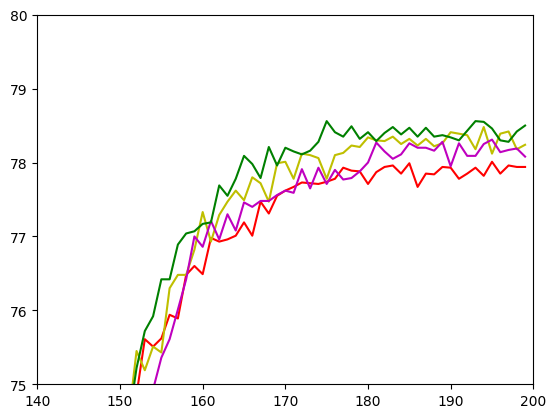

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(resnet_accuracy, color = 'r')
plt.plot(se_sa_accuracy, color = 'y')
#plt.plot(sec_sa_accuracy, color = 'b')
plt.plot(cbam_accuracy, color = 'm')
plt.plot(ours_accuracy, color = 'g')
plt.xlim([140, 200])      # X축의 범위: [xmin, xmax]
plt.ylim([75, 80])     # Y축의 범위: [ymin, ymax]
plt.show()

#### Conclusion


<span style="color:blue">__Our model shows overall higher accuracy than other models.__</span>